In [8]:
%%writefile pyproject.toml
[build-system]
requires = [
  "setuptools>=65.0",
  "wheel",
  "legacy-cgi>=2.6.3",
  "numpy>=1.24",
  "Cython>=0.29.0"
]
build-backend = "setuptools.build_meta"

[project]
name = "nfl_big_data_bowl_2025"
version = "0.1.0"
description = "SCI analysis for NFL Big Data Bowl 2025"
authors = [
  { name="Geoff", email="ghadfield32@gmail.com" }
]
readme = "README.md"
license = { file = "LICENSE" }
requires-python = ">=3.12,<3.13"

dependencies = [
  "pandas>=2.0",
  "numpy>=1.24",
  "scipy>=1.10",
  "scikit-learn>=1.2",
  "statsmodels>=0.14",
  "matplotlib>=3.7",
  "seaborn>=0.12",
  "missingno>=0.5",
  "click>=8.1",
  "jupyterlab>=4.0",
  "opendatasets>=0.1",
  "htmlmin2>=0.1.13",
  "kaggle>=1.5.15",
  "python-dotenv>=1.0.0",
  "pyarrow>=8.0.0",
  "fastparquet>=0.7.1",
  "plotly>=6.0.0",
  "pytest>=8.3.5",
  "shap>=0.47.2",
  "shapiq>=1.2.3",
  "xgboost>=3.0.2,<4.0.0",
  "optuna>=4.3.0,<5.0.0",
  "optuna-integration>=4.3.0,<5.0.0",
  "u8darts==0.24.0",
  "sktime>=0.24.0",
  "prophet>=1.1.4",
  "arch>=5.3.0",
  "conformal-tights==0.2.2",
  "explainerdashboard>=0.4.8,<0.5.0"
]

[project.urls]
Homepage = "https://github.com/ghadfield32/nfl_big_data_bowl_2025"
"Bug Tracker" = "https://github.com/ghadfield32/nfl_big_data_bowl_2025/issues"

[tool.uv]
no-build-isolation = false


Overwriting pyproject.toml


In [3]:
%%writefile .env
KAGGLE_USERNAME=geoffhadfield
KAGGLE_KEY=0ea9ede290ff90d845c35830b5d4576d

Overwriting .env


In [4]:
%%writefile src/load_data/load_data.py
# src/load_data/load_data.py

"""
Data loading and preprocessing for NFL Big Data Bowl 2025,
including assembly of ML-ready dataset for WR/TE/CB pass-contest analysis.
"""
import os
from dotenv import load_dotenv, find_dotenv
import pandas as pd
import numpy as np
import zipfile
from typing import Iterable

# Automatically locate and load the nearest .env file
dotenv_path = find_dotenv()
if not dotenv_path:
    print("WARNING: .env not found—make sure KAGGLE_USERNAME/KEY are set!")
else:
    load_dotenv(dotenv_path)
    print(f"[dotenv] loaded from {dotenv_path}")

from kaggle.api.kaggle_api_extended import KaggleApi

# Initialize and authenticate Kaggle API
a_pi = KaggleApi()
a_pi.authenticate()

DATA_DIR = "data/nfl-bdb-2025"
COMPETITION = "nfl-big-data-bowl-2025"


def download_dataset(force: bool = False) -> bool:
    """
    Download & extract NFL Big Data Bowl dataset.
    """
    if os.path.isdir(DATA_DIR) and not force:
        print(f"Data directory {DATA_DIR!r} exists. Skipping download.")
        return True
    os.makedirs(DATA_DIR, exist_ok=True)
    zip_path = os.path.join(DATA_DIR, f"{COMPETITION}.zip")
    try:
        a_pi.competition_download_cli(COMPETITION, path=DATA_DIR)
        print(f"Downloaded archive to {zip_path!r}")
        with zipfile.ZipFile(zip_path, 'r') as archive:
            archive.extractall(DATA_DIR)
        print(f"Extracted all files into {DATA_DIR!r}")
        os.remove(zip_path)
        print(f"Removed archive {zip_path!r}")
        return True
    except Exception as e:
        print("Error downloading or extracting dataset:", e)
        return False


def load_base_data():
    plays = pd.read_csv(os.path.join(DATA_DIR, 'plays.csv'))
    players_raw = pd.read_csv(os.path.join(DATA_DIR, 'players.csv'))
    player_play = pd.read_csv(os.path.join(DATA_DIR, 'player_play.csv'))
    games = pd.read_csv(os.path.join(DATA_DIR, 'games.csv'))
    return plays, players_raw, player_play, games


def load_tracking_data(week: int = 1, nrows: int | None = None) -> pd.DataFrame:
    """
    Read one tracking CSV.

    Parameters
    ----------
    week : int
        Valid weeks are 1-9 inclusive.
    nrows : int | None
        If given, limit rows (for quick smoke tests).
    """
    try:
        week_int = int(week)
    except (TypeError, ValueError):
        raise TypeError(f"`week` must be an int between 1 and 9, got {type(week).__name__}: {week!r}")

    if not 1 <= week_int <= 9:
        raise ValueError("Week must be between 1 and 9")

    path = os.path.join(DATA_DIR, f"tracking_week_{week_int}.csv")
    return pd.read_csv(path, nrows=nrows)







if __name__ == '__main__':
    print('Downloading dataset...')
    download_dataset(force=False)
    plays, players, player_play, games = load_base_data()
    print("=========columns=========")
    print(plays.columns, players.columns, player_play.columns, games.columns)
    print("=========shapes=========")
    print(f" plays={plays.shape}, players={players.shape},"
          f" player_play={player_play.shape}, games={games.shape}")
    ml_df = feature_engineering(plays, players, player_play, games)
    print('ML dataset shape:', ml_df.shape)
    print('ML dataset columns:', ml_df.columns)


    # quick debug
    print(ml_df["is_contested"].mean())          # % of targets truly contested
    print(ml_df["contested_success"].mean())     # contested-catch success-rate
    print(ml_df.query("is_contested").passResult.value_counts())


Overwriting src/load_data/load_data.py


In [7]:
%%writefile src/feature_engineering/utils.py
import pandas as pd
import numpy as np

# ────────────────────────────────────────────────────────────────
# helpers
# ────────────────────────────────────────────────────────────────
def _label_height_zone(pass_length: float) -> str:
    if pass_length <= 5:
        return "low"
    if pass_length <= 20:
        return "mid"
    return "high"

def convert_height_to_inches(height_str):
    if pd.isna(height_str):
        return np.nan
    try:
        ft, inch = height_str.split('-')
        return int(ft) * 12 + int(inch)
    except (ValueError, AttributeError):
        return np.nan
    

def _height_to_inches(height_str: str | float) -> float:
    if pd.isna(height_str):
        return np.nan
    try:
        ft, inch = height_str.split("-")
        return int(ft) * 12 + int(inch)
    except (ValueError, AttributeError):
        return np.nan

def map_pass_dir(pass_loc: str | float, target_x: float) -> str:
    """
    Map to 'L', 'M', 'R' based on passLocationType if present,
    else use target_x with thirds of field (0-53.3).
    """
    # prefer explicit label
    if isinstance(pass_loc, str):
        pl = pass_loc.lower()
        if 'left' in pl: return 'L'
        if 'right' in pl: return 'R'
        if 'middle' in pl or 'center' in pl: return 'M'
    # fallback on x
    if pd.notna(target_x):
        if target_x < 120/3: return 'L'
        if target_x > 2*120/3: return 'R'
        return 'M'
    return np.nan

def calc_age(birth_date: str, game_date: str) -> float:
    """
    Return age in years on the game_date (YYYY-MM-DD).
    """
    bd = pd.to_datetime(birth_date, errors='coerce')
    gd = pd.to_datetime(game_date, errors='coerce')
    if pd.isna(bd) or pd.isna(gd): return np.nan
    return (gd - bd).days / 365.25

def calc_bmi(height_in: float, weight_lb: float) -> float:
    """
    BMI = weight(lb) / (height(in)^2) * 703
    """
    if pd.isna(height_in) or pd.isna(weight_lb): return np.nan
    return weight_lb / (height_in**2) * 703

def lookup_vert_jump_pct(df: pd.DataFrame, combine_csv: str) -> pd.DataFrame:
    """
    Join a CSV of {nflId, vert_jump_inches}, compute percentile within position.
    """
    comb = pd.read_csv(combine_csv)
    comb['vert_pct'] = comb.groupby('position')['vert_jump_inches'] \
                            .rank(pct=True)
    return df.merge(comb[['nflId','vert_pct']], on='nflId', how='left')

def lookup_draft_bucket(df: pd.DataFrame, draft_csv: str) -> pd.DataFrame:
    """
    Join a CSV of {nflId, draft_round}, bucket as R1, R2-3, Day3/UDFA.
    """
    dr = pd.read_csv(draft_csv)
    def bucket(r):
        if r == 1: return 'R1'
        if r in (2,3): return 'R2-3'
        return 'Day3/UDFA'
    dr['draft_bucket'] = dr['draft_round'].apply(bucket)
    return df.merge(dr[['nflId','draft_bucket']], on='nflId', how='left')



def _label_vertical_zone(ball_z: float, *, low: float = 6.0, mid: float = 10.0) -> float:
    """
    Assign an integer code to each “vertical zone” based on the ball’s z height (in feet)
    at pass_arrived.  

    0 = low (below `low` ft), 
    1 = mid (`low` ≤ ball_z < `mid`), 
    2 = high (≥ `mid`).

    - `low` = 6 ft is roughly chest/shoulder height.
    - `mid` = 10 ft is just under crossbar; most receivers max out ~11–12 ft.

    Returns np.nan if ball_z is NaN.
    """
    if pd.isna(ball_z):
        return np.nan
    if ball_z < low:
        return 0
    if ball_z < mid:
        return 1
    return 2


if __name__ == '__main__':
    print('Downloading dataset...')
    download_dataset(force=False)
    plays, players, player_play, games = load_base_data()

Overwriting src/feature_engineering/utils.py


In [11]:
%%writefile src/feature_engineering/plays_fe.py
"""
Feature engineering utilities that use ONLY the *plays* table.
"""

import pandas as pd
import numpy as np
from src.feature_engineering.utils import _label_height_zone, map_pass_dir


def plays_feature_engineering(plays_raw: pd.DataFrame, *, debug: bool = False) -> pd.DataFrame:
    """
    One row per drop-back play, adding:
     - height_zone, air_yards_bin, pass_dir
     - is_play_action, is_rpo
     - preWP, wp_delta, postWP
     - epa_change
    """
    # 1️⃣ filter dropbacks
    df = plays_raw.loc[plays_raw["isDropback"]].copy()

    # 🔍 debug & drop missing passLength
    if debug:
        n_missing = df["passLength"].isna().sum()
        print(f"[DEBUG] passLength missing before binning: {n_missing}")
        print(df.loc[df["passLength"].isna(), ["gameId","playId"]].head(10))
    df = df.loc[df["passLength"].notna()]

    # 🔍 debug inputs
    if debug:
        print("[DBG] INPUT plays cols:", plays_raw.columns.tolist())
        print("[DBG] POST-FILTER cols:", df.columns.tolist())

    # 2️⃣ basic bins & flags
    # ── height_zone (low/mid/high) stays the same ──
    df["height_zone"] = df["passLength"].apply(_label_height_zone)

    # ── air_yards_bin: now explicitly handles x<0 as "behind" ──
    # negative (backward) throws → "behind", then short/mid/long as before.
    bins   = [-np.inf, 0, 5, 20, np.inf]
    labels = ['behind','short','mid','long']
    df["air_yards_bin"] = pd.cut(df["passLength"], bins=bins, labels=labels)

    if debug:
        n_missing_bin = df["air_yards_bin"].isna().sum()
        print(f"[DEBUG] air_yards_bin missing after binning: {n_missing_bin}")

    df["pass_dir"]       = df.apply(
                              lambda r: map_pass_dir(r.get("passLocationType"), r.get("targetX")),
                              axis=1)
    df["is_play_action"] = df["playAction"] == "play_action"
    df["is_rpo"]         = df.get("pff_runPassOption","").notna()

    # 3️⃣ WIN-PROB features
    df["preWP"]    = df["preSnapHomeTeamWinProbability"] / 100.0
    df["wp_delta"] = df["homeTeamWinProbabilityAdded"]  / 100.0
    df["postWP"]   = (df["preWP"] + df["wp_delta"]).clip(0,1)

    # 4️⃣ pick & rename
    keep = [
        "gameId","playId","passResult","passLength","targetX","targetY",
        "height_zone","air_yards_bin","pass_dir","is_play_action","is_rpo",
        "timeToThrow","passTippedAtLine","yardlineNumber","yardlineSide",
        "down","yardsToGo",
        # ▲ new fields here
        "preWP","wp_delta","postWP",
        "pff_passCoverage","expectedPointsAdded"
    ]
    out = (
        df[keep]
          .rename(columns={
               "yardlineNumber":"yardline_number",
               "yardlineSide":"yardline_side",
               "expectedPointsAdded":"epa_change"
           })
    )

    # ─── 3️⃣ handle spatial / direction nulls ───────────────────────────
    # flag whether there was a real target
    out["has_target"] = out["targetX"].notna()

    # fill missing target coordinates (model will see (0,0)+flag)
    out[["targetX","targetY"]] = out[["targetX","targetY"]].fillna(0.0)

    # pass_dir unknown when no target
    out["pass_dir"] = out["pass_dir"].fillna("unknown")

    # ─── 4️⃣ timing & tip flags ─────────────────────────────────────────
    # fill missing timeToThrow with median (or choose drop/mode)
    median_ttt = out["timeToThrow"].median()
    out["timeToThrow"] = out["timeToThrow"].fillna(median_ttt)
    # optional flag if you ever want to know which were imputed:
    out["time_imputed"] = out["timeToThrow"].isna()

    # missing passTippedAtLine → not tipped
    out["passTippedAtLine"] = out["passTippedAtLine"].fillna(False)


    # 5️⃣ tidy
    out["yardline_side"] = out["yardline_side"].fillna("middle")
    out["epa_change"]    = out["epa_change"].fillna(0.0)
    # 6️⃣ side_code
    side_code_unique = out["yardline_side"].unique()
    print('yardline_side unique values:', side_code_unique)

    # 6️⃣ side_code
    # fill na with unknown
    out["pff_passCoverage"] = out["pff_passCoverage"].fillna("unknown")
    print(out["pff_passCoverage"].value_counts(dropna=False))

    side_code_unique = out["pff_passCoverage"].unique()
    print('pff_passCoverage unique values:', side_code_unique)

    
    if debug:
        print("[DBG] OUTPUT cols:", out.columns.tolist())

    return out





# ── Smoke Tests Using Real Data ──────────────────────────────────────────────
if __name__ == '__main__':
    from src.load_data.load_data import download_dataset, load_base_data
    # Download and load datasets
    download_dataset(force=False)
    plays, players, player_play, games = load_base_data()
    print('plays dataset columns:', plays.columns)
    print('players dataset columns:', players.columns)
    print('player_play dataset columns:', player_play.columns)
    print('games dataset columns:', games.columns)
    plays_fe = plays_feature_engineering(plays, debug=True)
    print('plays_fe columns:', plays_fe.columns.tolist())
    assert {"preWP","wp_delta","postWP"}.issubset(plays_fe.columns)

    # check sum of nulls
    play_nulls = plays_fe.isnull().sum()
    print('play_nulls:', play_nulls)
    assert play_nulls.sum() == 0


Overwriting src/feature_engineering/plays_fe.py


In [10]:
%%writefile src/feature_engineering/players_fe.py
from typing import Optional
import pandas as pd
from src.feature_engineering.utils import (
    convert_height_to_inches,
    # calc_age,    <— WE NO LONGER import calc_age here
    calc_bmi,
    lookup_vert_jump_pct,
    lookup_draft_bucket,
)
    
def players_feature_engineering(players_raw: pd.DataFrame, *, debug: bool = False) -> pd.DataFrame:
    """
    Clean player bio data and keep the original `position` column intact.
    
    Returns one row per `nflId` with, at minimum:
        nflId, position, height_inches, weight_numeric, displayName, birthDate (datetime64)
    """
    df = players_raw.copy()
    
    # 2. Parse birthDate as datetime, and report missing/unparseable counts
    # 2. Parse birthDate as datetime, compute median, and impute missing values
    if "birthDate" in df.columns:
        # Convert strings → datetime; unparseable strings become NaT
        df["birthDate"] = pd.to_datetime(df["birthDate"], errors="coerce")
        
        if debug:
            raw_nulls = df["birthDate"].isna().sum()
            print(f"[DEBUG] raw birthDate missing or unparseable: {raw_nulls}")
        
        # ─────────────────────────────────────────────────────────────────────
        # Compute median of existing (non-null) birthDates
        median_date = df["birthDate"].median()
        if debug:
            print(f"[DEBUG] median birthDate to impute = {median_date.date()}")
        
        # Create a flag marking which rows will be imputed
        df["birthDate_imputed_flag"] = df["birthDate"].isna().astype(int)
        
        # Fill all NaT entries with the median_date
        df["birthDate"] = df["birthDate"].fillna(median_date)
        
        if debug:
            post_impute_nulls = df["birthDate"].isna().sum()
            print(f"[DEBUG] post-imputation birthDate null count (should be 0): {post_impute_nulls}")
    else:
        raise KeyError(
            "No 'birthDate' column found. Downstream code needs it to compute age at game time."
        )

    
    # 3. Height → inches
    if "height" in df.columns and "height_inches" not in df.columns:
        df["height_inches"] = df["height"].map(convert_height_to_inches)
        if debug:
            missing_h = df["height_inches"].isna().sum()
            print(f"[DEBUG] height_inches missing after conversion: {missing_h}")
            bad_h = df.loc[df["height_inches"].isna(), "height"].unique()
            print(f"[DEBUG] height strings causing NaN inches: {bad_h[:10]}")
    else:
        if debug and "height" not in df.columns:
            print("[DEBUG] WARNING: 'height' column not found; skipping height_inches creation.")
    
    # 4. Weight → numeric
    if "weight" in df.columns and "weight_numeric" not in df.columns:
        df["weight_numeric"] = pd.to_numeric(df["weight"], errors="coerce")
        if debug:
            missing_w = df["weight_numeric"].isna().sum()
            print(f"[DEBUG] weight_numeric missing after conversion: {missing_w}")
            bad_w = df.loc[df["weight_numeric"].isna(), "weight"].unique()
            print(f"[DEBUG] weight strings causing NaN weight_numeric: {bad_w[:10]}")
    else:
        if debug and "weight" not in df.columns:
            print("[DEBUG] WARNING: 'weight' column not found; skipping weight_numeric creation.")
    
    # 5. Guarantee `position` exists
    if "position" not in df.columns:
        alt_map = {"pos": "position", "playerPosition": "position"}
        found = [c for c in alt_map if c in df.columns]
        if found:
            df.rename(columns={found[0]: "position"}, inplace=True)
            if debug:
                print(f"[DEBUG] renamed column '{found[0]}' → 'position'")
        else:
            raise KeyError(
                "No `position` column found after cleaning. Make sure to keep a canonical `position` field."
            )
    
    # 6. (Optional) Additional engineered features go here…
    # 7. Final debug summary…
    if debug:
        pre_cols = set(players_raw.columns)
        post_cols = set(df.columns)
        dropped = sorted(pre_cols - post_cols)
        added = sorted(post_cols - pre_cols)
        print(f"[DEBUG] players_fe ▶︎ dropped: {dropped}")
        print(f"[DEBUG] players_fe ▶︎ added  : {added}")
    
    return df








# ── Smoke Tests Using Real Data ──────────────────────────────────────────────
if __name__ == '__main__':
    from src.load_data.load_data import download_dataset, load_base_data
    # Download and load datasets
    download_dataset(force=False)
    plays, players, player_play, games = load_base_data()
    print('plays dataset columns:', plays.columns)
    print('players dataset columns:', players.columns)
    print('player_play dataset columns:', player_play.columns)
    print('games dataset columns:', games.columns)
    players_fe = players_feature_engineering(players, debug=True)
    print(players_fe[['nflId', 'height', 'height_inches', 'weight', 'weight_numeric']].head())

    # check sum of nulls
    play_nulls = players_fe.isnull().sum()
    print('play_nulls:', play_nulls)
    print('total rows:', len(players_fe))
    print('percentage of nulls:', play_nulls.sum() / len(players_fe))
    assert play_nulls.sum() == 0


Overwriting src/feature_engineering/players_fe.py


In [8]:
%%writefile src/feature_engineering/player_play_fe.py
"""
Feature engineering utilities that use ONLY the *player_play* table.
"""
import pandas as pd
from src.feature_engineering.utils import _label_height_zone, convert_height_to_inches, _height_to_inches


def player_play_feature_engineering(pp_raw: pd.DataFrame, *, debug: bool=False) -> pd.DataFrame:
    """
    One row per (gameId, playId, receiverId), with:
      ▸ qb_was_hit flag
      ▸ route one-hots
      ▸ motion / shift flags
      ▸ pass-protection help flags
    """
    df = pp_raw.copy()

    # ─── 0. Debug: Show how many raw rows have missing motion/shift  ───
    raw_nulls_imotion = df["inMotionAtBallSnap"].isna().sum()
    raw_nulls_shift   = df["motionSinceLineset"].isna().sum()
    if debug:
        print(f"[DEBUG-raw] Total rows: {len(df)}")
        print(f"[DEBUG-raw] inMotionAtBallSnap missing: {raw_nulls_imotion}")
        print(f"[DEBUG-raw] motionSinceLineset missing: {raw_nulls_shift}")

    # ─── 1️⃣  targeted-receiver rows  ──────────────────────────────────
    targets = (
        df.loc[df["wasTargettedReceiver"] == 1, ["gameId", "playId", "nflId"]]
          .rename(columns={"nflId": "receiverId"})
    )
    if debug:
        print(f"[DEBUG] Number of targeted-receiver rows in raw df: {len(targets)}")
        print(f"[DEBUG] Unique plays in targets: {targets[['gameId','playId']].drop_duplicates().shape[0]}")

    # ─── 2️⃣  QB-hit per play  ──────────────────────────────────────────
    hit = (
        df.groupby(["gameId","playId"])["quarterbackHit"]
          .max()
          .rename("qb_was_hit")
          .reset_index()
    )
    out = targets.merge(hit, on=["gameId","playId"], how="left")
    if debug:
        print(f"[DEBUG] After merging qb_was_hit, rows={len(out)}, null qb_was_hit: {out['qb_was_hit'].isna().sum()}")

    # ─── 3️⃣  route one-hots  ───────────────────────────────────────────
    route_col = "routeRan" if "routeRan" in df.columns else ("route" if "route" in df.columns else None)
    if route_col:
        rts = (
            df[["gameId","playId","nflId",route_col]]
              .rename(columns={route_col: "route", "nflId": "receiverId"})
        )
        rts = pd.get_dummies(rts, columns=["route"], prefix="route")
        out = out.merge(rts, on=["gameId","playId","receiverId"], how="left")
        if debug:
            null_routes = out.filter(like="route_").isna().sum().sum()
            print(f"[DEBUG] After merging routes, total null entries among route dummies: {null_routes}")

    # ─── 4️⃣  motion / shift flags  ─────────────────────────────────────
    # 4a. Compute grouped max (could be NaN if entire play is null)
    snap_motion = (
        df.groupby(["gameId","playId"])["inMotionAtBallSnap"]
          .max()
          .rename("in_motion_at_snap")
    )
    shift_flag = (
        df.groupby(["gameId","playId"])["motionSinceLineset"]
          .max()
          .rename("shift_since_line")
    )

    # 4b. Debug how many plays are “all null” in raw data
    if debug:
        tmp1 = df.copy()
        tmp1["_is_null_imotion"] = tmp1["inMotionAtBallSnap"].isna()
        imotion_by_play = (
            tmp1.groupby(["gameId","playId"])["_is_null_imotion"]
                .agg(all_null=("all"), any_null=("any"))
                .reset_index()
        )
        num_play_all_null_imotion = imotion_by_play["all_null"].sum()
        print(f"[DEBUG] Number of plays where EVERY row’s inMotionAtBallSnap is null: {num_play_all_null_imotion}")

        tmp2 = df.copy()
        tmp2["_is_null_shift"] = tmp2["motionSinceLineset"].isna()
        shift_by_play = (
            tmp2.groupby(["gameId","playId"])["_is_null_shift"]
                .agg(all_null=("all"), any_null=("any"))
                .reset_index()
        )
        num_play_all_null_shift = shift_by_play["all_null"].sum()
        print(f"[DEBUG] Number of plays where EVERY row’s motionSinceLineset is null: {num_play_all_null_shift}")

    # 4c. Merge into “out”
    out = out.merge(snap_motion, on=["gameId","playId"], how="left")
    out = out.merge(shift_flag , on=["gameId","playId"], how="left")

    if debug:
        null_imotion_after_merge = out["in_motion_at_snap"].isna().sum()
        null_shift_after_merge  = out["shift_since_line"].isna().sum()
        print(f"[DEBUG] After merging, plays with in_motion_at_snap = NaN: {null_imotion_after_merge}")
        print(f"[DEBUG] After merging, plays with shift_since_line  = NaN: {null_shift_after_merge}")
        print(f"[DEBUG] Unique plays in out: {out[['gameId','playId']].drop_duplicates().shape[0]}")

    # ─────────— CHOOSE ONE: Filter  OR  Fill  ────────────────────────────

    # === OPTION A: DROP all plays missing either flag ===
    # Uncomment the entire block below if you prefer to filter out those plays.

    if debug:
        print("[DEBUG] Entering drop‐mode for missing flags...")
    missing_motion_mask = out["in_motion_at_snap"].isna()
    missing_shift_mask  = out["shift_since_line"].isna()
    to_drop_mask = missing_motion_mask | missing_shift_mask
    if debug:
        print(f"[DEBUG] Dropping {to_drop_mask.sum()} rows (plays) lacking motion/shift info")
    out = out.loc[~to_drop_mask].reset_index(drop=True)
    if debug:
        print(f"[DEBUG] After dropping, total rows = {len(out)}")
        print(f"[DEBUG] in_motion_at_snap nulls now: {out['in_motion_at_snap'].isna().sum()}")
        print(f"[DEBUG] shift_since_line nulls now:  {out['shift_since_line'].isna().sum()}")



    return out






# ── Smoke Tests Using Real Data ──────────────────────────────────────────────
if __name__ == '__main__':
    from src.load_data.load_data import download_dataset, load_base_data
    # Download and load datasets
    download_dataset(force=False)
    plays, players, player_play, games = load_base_data()
    print('plays dataset columns:', plays.columns)
    print('players dataset columns:', players.columns)
    print('player_play dataset columns:', player_play.columns)
    print('games dataset columns:', games.columns)
    player_play_fe = player_play_feature_engineering(player_play)
    print(player_play_fe.columns)


    # check sum of nulls
    play_nulls = player_play_fe.isnull().sum()
    print('play_nulls:', play_nulls)
    print('total rows:', len(player_play_fe))
    print('percentage of nulls:', play_nulls.sum() / len(player_play_fe))
    assert play_nulls.sum() == 0

Overwriting src/feature_engineering/player_play_fe.py


In [9]:
%%writefile src/feature_engineering/games_fe.py
"""
Feature engineering that *starts* from tracking CSVs but does NOT touch other
raw tables except for an OPTIONAL plays slice to tag offensive vs defensive
clubs.  All calls that actually read tracking files are still delegated to
`load_tracking_data` from `src/load_data/load_data.py`.
"""

from __future__ import annotations
from typing import Iterable, List, Tuple, Dict
import numpy as np, pandas as pd
from math import atan2, hypot, cos, sin
from datetime import timedelta
from src.load_data.load_data import load_tracking_data


def tracking_feature_engineering(
    weeks: Iterable[int],
    *, debug: bool = False,
    burst_cap: float = 13.0      # yd / s – generous biomechanical ceiling
) -> pd.DataFrame:
    """Receiver-centric snapshot builder (fast, memory-lean)."""

    one_sec = timedelta(seconds=1)
    rows: List[pd.DataFrame] = []

    if debug:
        print(f"[DEBUG][tracking] Processing weeks: {list(weeks)}")

    for wk in weeks:
        # 1. load tracking data -------------------------------------------------
        tr = load_tracking_data(week=wk)[
            ["gameId","playId","nflId","club","x","y","s","o","event","time"]
        ].copy()
        tr["time"] = pd.to_datetime(tr["time"], errors="coerce")
        # ★ If `time` is unparseable, that row's time becomes NaT.

        # 2. cache per-play slices ----------------------------------------
        play_groups: Dict[Tuple[int,int], pd.DataFrame] = {
            k: g for k, g in tr.groupby(["gameId","playId"])
        }

        # 3. snapshot at pass_arrived -------------------------------------
        snap = (
            tr[tr["event"] == "pass_arrived"]
              .rename(columns={"nflId":"receiverId",
                               "x":"rcv_x","y":"rcv_y",
                               "s":"rcv_s","o":"rcv_o"})
              [["gameId","playId","receiverId","club",
                "rcv_x","rcv_y","rcv_s","rcv_o","time"]]
        )
        if debug:
            print(f"[DEBUG][tracking] Week {wk}: loaded {len(snap)} pass_arrived rows")

        # potential CB candidates from same snapshot
        cb_cand = snap.rename(columns={
            "receiverId":"cbId","club":"cb_club",
            "rcv_x":"cb_x","rcv_y":"cb_y",
            "rcv_s":"cb_s","rcv_o":"cb_o",
        })

        # join every receiver with every candidate then filter
        m = pd.merge(snap, cb_cand, on=["gameId","playId"])
        m = m[m["club"] != m["cb_club"]]
        m["sep_receiver_cb"] = np.hypot(m["rcv_x"]-m["cb_x"], m["rcv_y"]-m["cb_y"])
        if debug:
            print(f"[DEBUG][tracking] Week {wk}: {len(m)} receiver-CB pairs after filter")

        # second-closest defender distance
        second_sep = (
            m.groupby(["gameId","playId","receiverId"])["sep_receiver_cb"]
             .apply(lambda s: s.nsmallest(2).iloc[-1] if len(s) >= 2 else np.nan)
             .rename("min_other_sep")
             .reset_index()
        )

        # nearest defender per receiver
        idx  = m.groupby(["gameId","playId","receiverId"])["sep_receiver_cb"].idxmin()
        snap = m.loc[idx].reset_index(drop=True).merge(
            second_sep, on=["gameId","playId","receiverId"], how="left"
        )
        if debug:
            print(f"[DEBUG][tracking] Week {wk}: {len(snap)} nearest-CB snapshots")

        # 3e. rename time column
        if "time_x" in snap.columns:
            snap.rename(columns={"time_x": "time_rcv"}, inplace=True)
            snap.drop(columns=["time_y"], errors="ignore", inplace=True)
        else:
            snap.rename(columns={"time": "time_rcv"}, inplace=True)
        # ★ At this point, some `time_rcv` may be NaT if original `time` was unparseable.

        assert "time_rcv" in snap.columns, "time_rcv column missing after merges"

        # 4. per-snapshot dynamics ---------------------------------------
        sep_vel, close_spd, burst = [], [], []
        for row in snap.itertuples(index=False):
            gid, pid, rcv, cb, x_r, y_r, x_c, y_c, s_c, o_c, t_end = (
                row.gameId, row.playId, row.receiverId, row.cbId,
                row.rcv_x, row.rcv_y, row.cb_x, row.cb_y,
                row.cb_s, row.cb_o, row.time_rcv
            )

            play_df = play_groups.get((gid, pid))
            if play_df is None:
                # ★ If the play group is missing entirely, we cannot compute dynamics
                sep_vel.append(np.nan); close_spd.append(np.nan); burst.append(np.nan)
                continue

            win  = play_df[play_df["time"] >= t_end - one_sec]
            two  = win[win["nflId"].isin([rcv, cb])]
            r_sl = two[two["nflId"] == rcv]

            # receiver burst speed
            burst.append(r_sl["s"].max() if not r_sl.empty else np.nan)

            if two.empty:
                # ★ If no positions for receiver + CB in that last second window
                sep_vel.append(np.nan); close_spd.append(np.nan)
                continue

            r = r_sl.sort_values("time")
            c = two[two["nflId"] == cb].sort_values("time")
            if len(r) < 2 or c.empty:
                # ★ Not enough data to compute velocity or closing speed
                sep_vel.append(np.nan); close_spd.append(np.nan)
                continue

            # separation velocity
            L   = min(len(r), len(c))
            sep = np.hypot(r["x"].values[:L] - c["x"].values[:L],
                           r["y"].values[:L] - c["y"].values[:L])
            dt  = (r["time"].iloc[-1] - r["time"].iloc[0]).total_seconds()
            sep_vel.append((sep[-1] - sep[0]) / dt if dt else np.nan)

            # closing speed inline
            dx, dy = x_r - x_c, y_r - y_c
            dist   = hypot(dx, dy) or 1e-6
            rad    = np.deg2rad((360 - o_c + 90) % 360)
            close_spd.append(s_c * (cos(rad)*dx/dist + sin(rad)*dy/dist))

        snap["sep_velocity"]   = sep_vel
        snap["closing_speed"]  = close_spd
        snap["s_max_last1s"]   = burst

        # 4b. cap implausible burst ---------------------------------------
        n_cap = snap.loc[snap["s_max_last1s"] > burst_cap, "s_max_last1s"].count()
        snap.loc[snap["s_max_last1s"] > burst_cap, "s_max_last1s"] = np.nan

        # 5. leverage angle ----------------------------------------------
        snap["leverage_angle"] = np.arctan2(
            snap["cb_y"] - snap["rcv_y"],
            snap["cb_x"] - snap["rcv_x"]
        )

        rows.append(snap)

        if debug:
            n_nan = snap["s_max_last1s"].isna().sum()
            print(f"W{wk}: {len(snap):,} snaps | avg_sep_vel {np.nanmean(sep_vel):.2f} | burst>cap {n_cap} | burst_nan {n_nan}")

    # ── Concatenate all weeks ──────────────────────────────────────────────────
    out = pd.concat(rows, ignore_index=True)

    # ── NEW: Identify & drop incomplete rows (where any critical field is NaN) ──
    ### <<<<< NEW >>>>> ###
    if debug:
        print(f"[DEBUG][tracking] Before dropping incompletes: total rows = {len(out)}")
        na_counts = out[[
            "time_rcv","cbId","sep_velocity","closing_speed","s_max_last1s"
        ]].isna().sum()
        print(f"[DEBUG][tracking] NaN counts before drop:\n{na_counts.to_frame(name='n_missing')}\n")

    # Build mask for rows that have *all* required fields present:
    complete_mask = (
        out["time_rcv"].notna() &
        out["cbId"].notna() &
        out["sep_velocity"].notna() &
        out["closing_speed"].notna() &
        out["s_max_last1s"].notna()
    )

    if debug:
        n_incomplete = len(out) - complete_mask.sum()
        print(f"[DEBUG][tracking] Dropping {n_incomplete} incomplete rows "
              f"(lack time_rcv or cbId or dynamics).")
        # Show a tiny sample of which keys are incomplete
        sample_bad = out.loc[~complete_mask, ["gameId","playId","receiverId"]].drop_duplicates().sample(
            min(5, (~complete_mask).sum()), random_state=0
        )
        print(f"[DEBUG][tracking] Example dropped (gameId, playId, receiverId):\n{sample_bad.to_dict('records')}\n")

    # Actually drop those rows:
    out = out.loc[complete_mask].reset_index(drop=True)
    ### <<<<< END NEW >>>>> ###

    # 6. (OPTIONAL) final validation checks ---------------------------
    if debug:
        # 6a. Uniqueness: one row per (gameId,playId,receiverId)
        assert not out.duplicated(['gameId','playId','receiverId']).any(), \
            'Duplicates found in (gameId,playId,receiverId)'

        # 6b. Club mismatch: receiver.club != cb_club always
        assert (out['club'] != out['cb_club']).all(), \
            'Some snapshots have receiver and CB on same club'

        # 6c. Burst capping: no s_max_last1s > burst_cap
        max_burst = out['s_max_last1s'].max()
        assert max_burst <= burst_cap, f'Found uncapped burst: {max_burst:.2f} yd/s'

        # 6d. Second‐closest separation ≥ closest
        bad = out.query('min_other_sep < sep_receiver_cb')
        assert bad.empty, 'min_other_sep < sep_receiver_cb in some rows'

        # 6e. Print summary stats for all new features
        print("--- feature summaries AFTER drop ---")
        print(
            out[[
                'sep_receiver_cb',
                'min_other_sep',
                'sep_velocity',
                'closing_speed',
                's_max_last1s',
                'leverage_angle'
            ]].describe()
        )

        total_rows = len(out)
        total_plays = out[["gameId","playId"]].drop_duplicates().shape[0]
        print(f"[DEBUG][tracking] total tracking rows (after drop): {total_rows}, unique plays tracked: {total_plays}")
        print(f"[DEBUG][tracking] Rows: {len(out):,}, Memory: {out.memory_usage(deep=True).sum()/1e6:.1f} MB\n")

    # Finally, we know there are *no* NaNs left
    assert not out.isnull().any().any(), "Some columns have NaNs after final drop"
    return out


# ── Smoke Tests Using Real Data ──────────────────────────────────────────────
if __name__ == '__main__':
    from src.load_data.load_data import download_dataset, load_base_data
    # Download and load datasets
    download_dataset(force=False)
    plays, players, player_play, games = load_base_data()
    print('plays dataset columns:', plays.columns)
    print('players dataset columns:', players.columns)
    print('player_play dataset columns:', player_play.columns)
    print('games dataset columns:', games.columns)

    fe = tracking_feature_engineering(range(1, 5), debug=True)
    print(fe[["s_max_last1s","leverage_angle"]].describe())

    # check sum of nulls
    play_nulls = fe.isnull().sum()
    print('play_nulls (should all be 0):', play_nulls)
    print('total rows:', len(fe))
    print('percentage of nulls:', play_nulls.sum() / len(fe))
    assert play_nulls.sum() == 0


Overwriting src/feature_engineering/games_fe.py


In [11]:
%%writefile src/feature_engineering/column_schema.py
"""
Column schema helper for VSRG ML dataset.

Separates columns into the **five** coherent buckets we now care about:

* **info_non_ml** – identifiers / metadata not used as model inputs
* **nominal**      – unordered categoricals
* **ordinal**      – ordered categoricals
* **numerical**    – continuous / discrete numeric predictors
* **target**       – label the model tries to predict

All downstream code should reference these accessors instead of hard‑coding
strings.  The helper also provides validation utilities and PyTest checks so a
schema / dataset mismatch is caught early.
"""
from typing import List, Dict, Literal
import pandas as pd
import pytest
import json


class ColumnSchema:
    # ─────────────────────────────────────────────────────────────────
    # 1️⃣ Non-ML informational columns (identifiers, metadata)
    # ─────────────────────────────────────────────────────────────────
    _INFO_NON_ML: List[str] = [
        "gameId",
        "playId",
        "receiverId",
        "cbId",
        "birthDate_x",
        "birthDate_y",
        "has_target",
    ]

    # ------------------------------------------------------------------
    # 2️⃣ Physical measurements (numeric)
    # ------------------------------------------------------------------
    _PHYSICAL_COLS: List[str] = [
        "rcv_height",
        "rcv_weight",
        "cb_height",
        "cb_weight",
    ]

    # ─────────────────────────────────────────────────────────────────
    # OPTIONAL: If you later derive quantile bins for height/weight,
    # uncomment this and add these to `nominal_cols()` or `ordinal_cols()`.
    # ─────────────────────────────────────────────────────────────────
    # _PHYSICAL_BINS: List[str] = [
    #     "rcv_height_bin",
    #     "rcv_weight_bin",
    #     "cb_height_bin",
    #     "cb_weight_bin",
    # ]

    # ------------------------------------------------------------------
    # 3️⃣ Position & context numeric features (unchanged)
    # ------------------------------------------------------------------
    _POSITION_COLS: List[str] = [
        "sep_receiver_cb", "sideline_dist", "pass_rush_sep", "sep_stddev", "hypo_sep",
        "passLength", "targetX", "targetY", "yardsToGo", "yardline_number", "timeToThrow",
        "time_rcv", "sep_velocity", "closing_speed", "min_other_sep", "rcv_s", "rcv_o",
        "cb_s", "cb_o", "leverage_angle", "contest_thresh", "s_max_last1s",
    ]

    # ------------------------------------------------------------------
    # ~~~ We are intentionally leaving _OUTCOME_NUMERICAL defined here
    #     in case you want it for a post‐model pipeline, but it should
    #     NOT be returned by numerical_cols() anymore. ~~~
    # ------------------------------------------------------------------
    _OUTCOME_NUMERICAL: List[str] = [
        "epa_change",
        "preWP",
        "postWP",
        "wp_delta",
        "vsrg_overall",
        "vsrg_oe",
    ]

    # ------------------------------------------------------------------
    # 5️⃣ Cluster-style categoricals (unchanged)
    # ------------------------------------------------------------------
    _CLUSTER_COLS: List[str] = [
        "rcv_club",
        "cb_club",
    ]

    # ------------------------------------------------------------------
    # 6️⃣ Ordinal features (unchanged)
    # ------------------------------------------------------------------
    _ZONE_COLS: List[str] = [
        "height_zone",
        "air_yards_bin",
        "down",
        "down_ctx",
    ]

    # ------------------------------------------------------------------
    # 7️⃣ Binary/nominal flags & categories (we remove these from training)
    #    _OUTCOME_CATEGORICAL is still defined but not used in any accessor.
    # ------------------------------------------------------------------
    _OUTCOME_CATEGORICAL: List[str] = [
        "is_contested",
        "was_tipped",
        "qb_was_hit",
        "pass_dir",
        "yardline_side",
        "is_play_action",
        "is_rpo",
        "passTippedAtLine",
        "caught_flag",
        "passResult",
        "time_imputed",
    ]

    # ------------------------------------------------------------------
    # 8️⃣ Route‐encoding + raw route (unchanged)
    # ------------------------------------------------------------------
    _ROUTE_COLS: List[str] = [
        "route_ANGLE", "route_CORNER", "route_CROSS", "route_FLAT",
        "route_GO", "route_HITCH", "route_IN", "route_OUT",
        "route_POST", "route_SCREEN", "route_SLANT", "route_WHEEL",
        "route",
    ]

    # ------------------------------------------------------------------
    # 9️⃣ Coverage columns (unchanged)
    # ------------------------------------------------------------------
    _COVERAGE_COLS: List[str] = [
        "cov_2-Man",
        "cov_Bracket",
        "cov_Cover 6-Left",
        "cov_Cover-0",
        "cov_Cover-1",
        "cov_Cover-1 Double",
        "cov_Cover-2",
        "cov_Cover-3",
        "cov_Cover-3 Cloud Left",
        "cov_Cover-3 Cloud Right",
        "cov_Cover-3 Double Cloud",
        "cov_Cover-3 Seam",
        "cov_Cover-6 Right",
        "cov_Goal Line",
        "cov_Miscellaneous",
        "cov_Prevent",
        "cov_Quarters",
        "cov_Red Zone",
    ]

    # ------------------------------------------------------------------
    # Target (unchanged)
    # ------------------------------------------------------------------
    _TARGET_COL: List[str] = ["contested_success"]

    # ------------------------------------------------------------------
    # Public accessors (modified)
    # ------------------------------------------------------------------

    def info_non_ml(self) -> List[str]:
        """Identification / metadata columns (never fed to the model)."""
        return self._INFO_NON_ML.copy()

    def target_col(self) -> List[str]:
        return self._TARGET_COL.copy()

    def nominal_cols(self) -> List[str]:
        """
        Unordered categorical features. We have removed _OUTCOME_CATEGORICAL
        to prevent leakage. If you uncomment _PHYSICAL_BINS above, add it here.
        """
        return (
            self._CLUSTER_COLS
            # + self._PHYSICAL_BINS      # ← Uncomment if you have quantile bins
            + self._ROUTE_COLS
            + self._COVERAGE_COLS
        ).copy()

    def ordinal_cols(self) -> List[str]:
        """
        Ordered categories. Examples: height_zone, air_yards_bin, down, down_ctx.
        """
        return self._ZONE_COLS.copy()

    def numerical_cols(self) -> List[str]:
        """
        Continuous / discrete numeric predictors. We removed _OUTCOME_NUMERICAL
        so that no post‐play outcome metrics leak into training.
        """
        return (self._PHYSICAL_COLS + self._POSITION_COLS).copy()

    def all_features(self) -> List[str]:
        """Nominal + ordinal + numerical (no target)."""
        return self.nominal_cols() + self.ordinal_cols() + self.numerical_cols()

    def modelling_columns(self) -> List[str]:
        """Feature set + target."""
        return self.all_features() + self.target_col()

    def all_columns(self) -> List[str]:
        """Every column expected in the ML parquet (info + features + target)."""
        return self.info_non_ml() + self.modelling_columns()

    def as_dict(self) -> Dict[str, List[str]]:
        return {
            "info_non_ml": self.info_non_ml(),
            "nominal": self.nominal_cols(),
            "ordinal": self.ordinal_cols(),
            "numerical": self.numerical_cols(),
            "target": self.target_col(),
        }



# ---------------------------------------------------------------------------
# Validation helpers --------------------------------------------------------
# ---------------------------------------------------------------------------

schema = ColumnSchema()


def validate_schema(s: ColumnSchema, df_cols: List[str] | None = None) -> None:
    """Assert bucket invariants and (optionally) match against a dataset."""

    GROUP_FUNCS = [
        s.info_non_ml,
        s.nominal_cols,
        s.ordinal_cols,
        s.numerical_cols,
        s.target_col,
    ]

    buckets = {f.__name__: f() for f in GROUP_FUNCS}

    # 1️⃣ No duplicates within any bucket
    for name, cols in buckets.items():
        assert len(cols) == len(set(cols)), f"Duplicates in bucket '{name}'"

    # 2️⃣ Buckets are disjoint (ignore target in overlap check)
    seen: set[str] = set()
    for name, cols in buckets.items():
        if name == "target_col":
            continue
        dup = seen.intersection(cols)
        assert not dup, f"Overlap across buckets: {dup}"
        seen.update(cols)

    # 3️⃣ Leakage‐keyword check (fail fast if a disallowed column appears)
    LEAKY_KEYWORDS = ["epa_", "preWP", "postWP", "vsrg_overall", "wp_delta"]
    for col in s.numerical_cols():
        for key in LEAKY_KEYWORDS:
            assert key not in col, f"Leaky column detected in numerical_cols(): {col}"

    # 4️⃣ Optionally compare to dataset headers
    if df_cols is not None:
        missing = set(s.all_columns()) - set(df_cols)
        extra = set(df_cols) - set(s.all_columns())
        assert not missing, f"Dataset missing columns: {missing}"
        assert not extra, f"Dataset has unexpected columns: {extra}"



# ---------------------------------------------------------------------------
# PyTest checks -------------------------------------------------------------
# ---------------------------------------------------------------------------

EXPECTED_BUCKET = {
    **{c: "info_non_ml" for c in schema.info_non_ml()},
    **{c: "nominal"    for c in schema.nominal_cols()},
    **{c: "ordinal"    for c in schema.ordinal_cols()},
    **{c: "numerical"  for c in schema.numerical_cols()},
    **{c: "target"     for c in schema.target_col()},
}


BUCKET_FUNCS = {
    "info_non_ml": schema.info_non_ml,
    "nominal": schema.nominal_cols,
    "ordinal": schema.ordinal_cols,
    "numerical": schema.numerical_cols,
    "target": schema.target_col,
}


@pytest.mark.parametrize("col,expected_bucket", EXPECTED_BUCKET.items())
def test_column_in_expected_bucket(col, expected_bucket):
    cols = BUCKET_FUNCS[expected_bucket]()
    assert col in cols, f"{col} missing from {expected_bucket} bucket"

    for bucket, func in BUCKET_FUNCS.items():
        if bucket != expected_bucket:
            assert col not in func(), f"{col} incorrectly present in {bucket} bucket"




# ---------------------------------------------------------------------------
# Smoke script --------------------------------------------------------------
# ---------------------------------------------------------------------------

if __name__ == "__main__":
    schema = ColumnSchema()
    # Single-bucket constants (immutable copies)
    INFO_NON_ML= schema.info_non_ml()
    NOMINAL = schema.nominal_cols()
    ORDINAL = schema.ordinal_cols()
    NUMERICAL = schema.numerical_cols()
    TARGET = schema.target_col()

    print("INFO_NON_ML", INFO_NON_ML)
    print("NOMINAL", NOMINAL)
    print("ORDINAL", ORDINAL)
    print("NUMERICAL", NUMERICAL)
    print("TARGET", TARGET)

    print("schema", schema)



Overwriting src/feature_engineering/column_schema.py


In [ ]:
# %%writefile src/feature_engineering/feature_engineering.py
"""
Data loading and preprocessing for NFL Big Data Bowl 2025,
including assembly of ML-ready dataset for WR/TE/CB pass-contest analysis.
"""
import os
from dotenv import load_dotenv, find_dotenv
import pandas as pd
import numpy as np
import zipfile
from typing import Iterable
from src.load_data.load_data import load_tracking_data
from src.feature_engineering.utils import _label_height_zone, convert_height_to_inches, _height_to_inches
from src.feature_engineering.plays_fe import plays_feature_engineering
from src.feature_engineering.players_fe import players_feature_engineering
from src.feature_engineering.player_play_fe import player_play_feature_engineering
from src.feature_engineering.games_fe import tracking_feature_engineering
from src.feature_engineering.column_schema import ColumnSchema 

# Automatically locate and load the nearest .env file
dotenv_path = find_dotenv()
if not dotenv_path:
    print("WARNING: .env not found—make sure KAGGLE_USERNAME/KEY are set!")
else:
    load_dotenv(dotenv_path)
    print(f"[dotenv] loaded from {dotenv_path}")

from kaggle.api.kaggle_api_extended import KaggleApi

# Initialize and authenticate Kaggle API
a_pi = KaggleApi()
a_pi.authenticate()

DATA_DIR = "data/nfl-bdb-2025"
COMPETITION = "nfl-big-data-bowl-2025"

# ── NEW: save/load helpers ───────────────────────────────────────────────
def save_fe_datasets(df: pd.DataFrame, path: str, file_format: str = 'parquet') -> None:
    """
    Save the DataFrame to disk at `path`.
    Supports 'parquet' or 'csv' via `file_format`.
    """
    os.makedirs(os.path.dirname(path), exist_ok=True)
    if file_format == 'parquet':
        df.to_parquet(path, index=False)
    elif file_format == 'csv':
        df.to_csv(path, index=False)
    else:
        raise ValueError(f"Unsupported file_format: {file_format}")

def load_fe_dataset(path: str, file_format: str = 'parquet') -> pd.DataFrame:
    """
    Load the DataFrame from disk at `path`.
    """
    if file_format == 'parquet':
        return pd.read_parquet(path)
    elif file_format == 'csv':
        return pd.read_csv(path)
    else:
        raise ValueError(f"Unsupported file_format: {file_format}")
# ── end new helpers ─────────────────────────────────────────────────────

# validations
def validate_height_zones(df: pd.DataFrame, allowed_zones=(0,1,2)):
    """
    Ensure that `height_zone` has no missing values and only expected categories.
    Print a summary of counts per zone.
    """
    if "height_zone" not in df.columns:
        raise KeyError("validate_height_zones: 'height_zone' column not found in DataFrame.")

    missing_mask = df["height_zone"].isna()
    if missing_mask.any():
        missing_count = missing_mask.sum()
        print(f"[VALIDATION] WARNING: {missing_count} rows have missing height_zone.")
    
    unique_zones = set(df["height_zone"].dropna().unique())
    unexpected = unique_zones.difference(allowed_zones)
    if unexpected:
        print(f"[VALIDATION] WARNING: unexpected height_zone values found: {unexpected}")
    
    counts = df["height_zone"].value_counts(dropna=False).sort_index()
    print("[VALIDATION] height_zone counts:")
    for zone, cnt in counts.items():
        print(f"  zone {zone}: {cnt} rows")
    print("")  # blank line

def validate_contest_flags(df: pd.DataFrame):
    """
    Validate that `is_contested` and `contested_success` columns exist,
    are boolean, and that no contested_success=True when is_contested=False.
    Print summary counts.
    """
    for col in ("is_contested", "contested_success"):
        if col not in df.columns:
            raise KeyError(f"validate_contest_flags: '{col}' column not found in DataFrame.")
    
    df["is_contested"] = df["is_contested"].astype(bool)
    df["contested_success"] = df["contested_success"].astype(bool)
    
    contested_counts = df["is_contested"].value_counts()
    success_counts = df["contested_success"].value_counts()
    print("[VALIDATION] is_contested counts:")
    for val, cnt in contested_counts.items():
        print(f"  {val}: {cnt}")
    print("[VALIDATION] contested_success counts:")
    for val, cnt in success_counts.items():
        print(f"  {val}: {cnt}")
    
    inconsistent = df.query("contested_success == True and is_contested == False").shape[0]
    if inconsistent > 0:
        print(f"[VALIDATION] WARNING: {inconsistent} rows where contested_success=True but is_contested=False.\n")
    else:
        print("[VALIDATION] OK: no contested_success=True rows with is_contested=False\n")




# Engineering each dataset before Join--------------------------


# feature adding functions:
def add_kinematic_features(df: pd.DataFrame, *, debug: bool = False) -> pd.DataFrame:
    """
    Add sideline_dist and placeholder pass_rush_sep.
    """
    if "y" in df.columns:
        y_col = "y"
    elif "rcv_y" in df.columns:
        y_col = "rcv_y"
    else:
        raise KeyError("Neither 'y' nor 'rcv_y' in df.columns")

    df["sideline_dist"] = np.minimum(df[y_col], 53.3 - df[y_col])
    df["pass_rush_sep"] = np.nan  # placeholder

    if debug:
        print("👟 after add_kinematic_features:", df.columns.tolist())

    return df



def add_contextual_features(df, plays_ctx, player_play, *, debug=False):
    """
    Merge play-level context (timeToThrow, tipped flag, yard-line info, etc.)
    into the main DF.  Robust to camelCase vs snake_case and to pre-existing
    yard-line cols in `df` (avoids *_x / *_y pitfalls).
    """
    if debug:
        # 1) all dropback plays with missing side in plays_fe:
        missing_in_ctx = (
            plays_ctx[plays_ctx["yardline_side"].isna()]
              .loc[:, ["gameId","playId"]]
              .drop_duplicates()
        )
        print(f"[DEBUG] plays_fe dropbacks missing side: {len(missing_in_ctx)} plays")

        # 2) which plays actually made it into this df so far:
        plays_in_df = df.loc[:, ["gameId","playId"]].drop_duplicates()
        print(f"[DEBUG] plays entering ctx‐merge:      {len(plays_in_df)} unique plays")

        # 3) how many of those missing‐side plays survived into df?
        common = plays_in_df.merge(missing_in_ctx, on=["gameId","playId"])
        print(f"[DEBUG] missing‐side plays in df:     {len(common)} plays")
        print("[DEBUG] sample of those plays:", common.sample(min(10,len(common))))

        # 4) which missing‐side plays got dropped before this point?
        dropped = missing_in_ctx.merge(plays_in_df, on=["gameId","playId"], how="left", indicator=True)
        dropped = dropped[dropped["_merge"]=="left_only"]
        print(f"[DEBUG] missing‐side plays dropped:    {len(dropped)} plays")
        print("[DEBUG] sample dropped plays:", dropped.sample(min(10,len(dropped))))
        
    if debug:
        print("DEBUG: df cols BEFORE ctx merge:", list(df.columns)[:25], "…")
        print("DEBUG: plays_ctx cols:", list(plays_ctx.columns)[:25], "…")

    # 1. Build clean context table…
    col_map = {
        "yardline_number": ["yardline_number", "yardlineNumber"],
        "yardline_side"  : ["yardline_side",   "yardlineSide"],
    }
    base_cols = ["gameId", "playId", "timeToThrow", "passTippedAtLine",
                 "down", "yardsToGo"]

    ctx_cols = base_cols + [
        next(c for c in aliases if c in plays_ctx.columns)
        for aliases in col_map.values()
    ]
    play_ctx = (
        plays_ctx[ctx_cols]
        .rename(columns={
            "passTippedAtLine": "pass_tipped_at_line",
            **{raw: canon
               for canon, aliases in col_map.items()
               for raw in aliases if raw in ctx_cols}
        })
    )
    play_ctx["was_tipped"] = play_ctx["pass_tipped_at_line"] == 1
    play_ctx.drop(columns="pass_tipped_at_line", inplace=True)

    # 2. Merge; coalesce yardline_*
    df = df.merge(
        play_ctx,
        on=["gameId", "playId"],
        how="left",
        suffixes=("", "_ctx")
    )
    for col in ("yardline_side", "yardline_number"):
        if col not in df.columns and f"{col}_ctx" in df.columns:
            df.rename(columns={f"{col}_ctx": col}, inplace=True)
        elif f"{col}_ctx" in df.columns:
            df[col] = df[col].combine_first(df[f"{col}_ctx"])
            df.drop(columns=f"{col}_ctx", inplace=True)

    if debug:
        print("DEBUG: df cols AFTER ctx merge:", list(df.columns)[:25], "…")

    # ── FRAME-LEVEL NaN check ─────────────────────────────────────────────
    if debug:
        total_rows_missing = df["yardline_side"].isna().sum()
        unique_plays_missing = (
            df[df["yardline_side"].isna()]
              .loc[:, ["gameId","playId"]]
              .drop_duplicates()
              .shape[0]
        )
        print(f"[DEBUG] frame-level rows with yardline_side==NaN: {total_rows_missing}")
        print(f"[DEBUG] unique plays missing side_code:          {unique_plays_missing}")
        
    # 3. Derived features
    df["contest_thresh"] = df["rcv_height"].apply(
        lambda h: max(1.0, 0.2 * h / 12) if pd.notna(h) else 1.0
    )
    df["is_contested"]    = df["sep_receiver_cb"] <= df["contest_thresh"]
    df["caught_flag"]     = df["passResult"].isin(("C", "S"))

    cov_cols = [c for c in df if c.startswith("cov_")]
    if cov_cols:
        df["cov_zone"] = df.get("cov_zone", 0)
        df["contested_success"] = (
            df["is_contested"] & df["caught_flag"] & (1 - 0.1 * df["cov_zone"])
        )
    else:
        df["contested_success"] = df["is_contested"] & df["caught_flag"]

    # ── FIX: guarantee qb_was_hit exists without overwriting ───────────────
    if "qb_was_hit" not in df.columns:
        df["qb_was_hit"] = False

    return df



def add_matchup_features(df, plays, player_play):
    """
    Add route and coverage one-hots, then guarantee the full cov_* set.
    """
    # 1. route one-hots (unchanged) …
    if 'routeRan' in player_play.columns:
        src = 'routeRan'
    elif 'route' in player_play.columns:
        src = 'route'
    else:
        src = None

    if src:
        routes = (
            player_play[['gameId','playId','nflId',src]]
            .rename(columns={src:'route','nflId':'receiverId'})
        )
        df = df.merge(routes, on=['gameId','playId','receiverId'], how='left')
        df = pd.concat([df, pd.get_dummies(df['route'],prefix='route')], axis=1)
    else:
        df['route'] = np.nan

    # 2. coverage one-hots
    if 'pff_passCoverage' in plays.columns:
        cov = (
            plays[['gameId','playId','pff_passCoverage']]
            .rename(columns={'pff_passCoverage':'pass_coverage'})
        )
        df = df.merge(cov, on=['gameId','playId'], how='left')
        df = pd.concat([df, pd.get_dummies(df['pass_coverage'], prefix='cov')], axis=1)
        df.drop(columns=['pass_coverage'], inplace=True)

    # ── GUARANTEE FULL coverage set ───────────────────────────
    schema = ColumnSchema()
    expected = [c for c in schema.nominal_cols() if c.startswith('cov_')]
    missing  = set(expected) - set(df.columns)
    for col in missing:
        df[col] = 0

    return df



# ---------- PATCH #2  (new helper) ----------
def add_temporal_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Placeholder temporal metrics.
    """
    df["sep_stddev"] = 0.0
    df["hypo_sep"]   = df["min_other_sep"] if "min_other_sep" in df.columns else np.nan
    return df




def get_defender_snapshots(plays_df, tracking_weeks):
    """
    Return one row per (gameId, playId, defenderId) at pass_arrived,
    with defender x,y coordinates.
    """
    # 1. Stack the pass_arrived frames
    arrived_list = []
    for wk in tracking_weeks:
        tr = load_tracking_data(week=wk)[
            ['gameId','playId','nflId','club','x','y','event']
        ]
        arrived = tr[tr['event'] == 'pass_arrived'].copy()
        arrived_list.append(arrived)
    arrived = pd.concat(arrived_list, ignore_index=True)

    # 2. Attach possessionTeam so we know offense vs defense
    ctx = plays_df[['gameId','playId','possessionTeam']]
    arrived = arrived.merge(ctx, on=['gameId','playId'], how='left')

    # 3. Filter out offensive club → keep defenders only
    defenders = arrived[arrived['club'] != arrived['possessionTeam']].copy()
    # rename columns for clarity
    defenders.rename(columns={'nflId':'defenderId','x':'def_x','y':'def_y'}, inplace=True)

    return defenders[['gameId','playId','defenderId','def_x','def_y']]



# ---------------------------------------------------------------------------
# 2.  contest flags: use correct "caught" codes
# ---------------------------------------------------------------------------
def add_contest_features(df: pd.DataFrame,
                         contest_threshold: float = 1.0,
                         caught_codes: tuple[str, ...] = ("C", "S")) -> pd.DataFrame:
    """
    - is_contested      : sep ≤ threshold (yards) **and** a defender present
    - contested_success : contested **and** pass caught  (passResult in caught_codes)
    """
    df["is_contested"] = df["sep_receiver_cb"] <= contest_threshold
    df["caught_flag"]  = df["passResult"].isin(caught_codes)
    df["contested_success"] = df["is_contested"] & df["caught_flag"]
    return df




def make_vsrg_summary(df: pd.DataFrame, min_attempts: int = 5) -> pd.DataFrame:
    """
    Build a tidy summary table of contested-catch success by receiver × height_zone.
    Drops any receiver–zone with fewer than `min_attempts`.

    *ADDITIONAL VALIDATIONS*:
      - Reports how many (receiver, zone) groups exist before & after threshold.
      - Prints counts per zone after filtering.
    """
    # 1) Compute raw aggregation
    base = (
        df.groupby(["receiverId", "height_zone"], observed=False)
          .agg(
              attempts=('is_contested','sum'),
              successes=('contested_success','sum')
          )
          .assign(vsrg_rate=lambda d: d['successes'] / d['attempts'])
          .reset_index()
    )

    # 1.a) Count total groups before filtering
    total_groups = base.shape[0]
    print(f"[VSRG VALIDATION] Total (receiver, zone) groups before min_attempts filter: {total_groups}")

    # 2) Filter out groups with fewer than min_attempts
    filtered = base[base['attempts'] >= min_attempts].copy()
    dropped = total_groups - filtered.shape[0]
    print(f"[VSRG VALIDATION] Dropped {dropped} groups with attempts < {min_attempts}")
    
    # If we ended up dropping entire zones, warn
    if filtered['height_zone'].nunique() < base['height_zone'].nunique():
        print("[VSRG VALIDATION] WARNING: Some height_zones have no receiver groups after filtering.")

    # 3) Compute the integer “grade” per zone
    filtered['vsrg_zone'] = (filtered['vsrg_rate'] * 100).round().astype(int)

    # 4) Print counts per zone after filtering
    counts_per_zone = filtered['height_zone'].value_counts().sort_index()
    print("[VSRG VALIDATION] (receiver, zone) counts after filtering:")
    for zone, cnt in counts_per_zone.items():
        print(f"  zone {zone}: {cnt} groups")
    print("")  # blank line for readability

    return filtered



def add_vsrg_overall(
    vsrg_long: pd.DataFrame,
    equal_weight: bool = False
) -> pd.DataFrame:
    """
    Collapse the long VSRG table to one overall score per receiver:
      - default: attempt-weighted average of vsrg_rate
      - equal_weight=True: simple mean of zone rates
    Returns a DataFrame with columns ['receiverId','vsrg_overall'].
    """
    if equal_weight:
        agg = lambda g: g['vsrg_rate'].mean()
    else:
        agg = lambda g: (g['vsrg_rate'] * g['attempts']).sum() / g['attempts'].sum()

    overall = (
        vsrg_long
        .groupby('receiverId')
        .apply(agg)
        .mul(100)
        .round()
        .astype(int)
        .rename('vsrg_overall')
        .reset_index()
    )
    return overall


def get_qb_snapshots(
    tracking_weeks: Iterable[int],
    players_df: pd.DataFrame,
    *,
    debug: bool = False,
) -> pd.DataFrame:
    """
    Return one row per (gameId, playId) with QB x,y coordinates at `pass_arrived`.
    """

    # 🛑 1. quick guard: if a DataFrame slipped in, fail fast
    from pandas import DataFrame
    if isinstance(tracking_weeks, DataFrame):
        raise TypeError(
            "get_qb_snapshots() expected an iterable of week numbers "
            "but received a DataFrame.  Pass the *list* of weeks, e.g. range(1,10)."
        )

    # … everything below is unchanged …
    pos_col_candidates = ["position", "pos", "playerPosition"]
    pos_col = next((c for c in pos_col_candidates if c in players_df.columns), None)
    if pos_col is None:
        raise KeyError(f"None of {pos_col_candidates} found in players_df")

    qb_ids = set(players_df.loc[players_df[pos_col] == "QB", "nflId"])
    if debug:
        print(f"get_qb_snapshots ▶︎ using `{pos_col}` — {len(qb_ids)} QBs")

    frames = []
    for wk in tracking_weeks:
        tr = load_tracking_data(week=wk, nrows=None)[
            ["gameId", "playId", "nflId", "x", "y", "event"]
        ]
        mask = (tr["event"] == "pass_arrived") & (tr["nflId"].isin(qb_ids))
        frames.append(tr.loc[mask, ["gameId", "playId", "x", "y"]])

    qb_snap = (
        pd.concat(frames, ignore_index=True)
          .rename(columns={"x": "qb_x", "y": "qb_y"})
          .drop_duplicates(subset=["gameId", "playId"])
    )
    return qb_snap

def add_pass_rush_sep(
    df: pd.DataFrame,
    plays_df: pd.DataFrame,
    players_df: pd.DataFrame,
    tracking_weeks: Iterable[int],
    *,
    debug: bool = False
) -> pd.DataFrame:
    """
    Compute min distance between any defender and QB at pass_arrived.
    Ensures a single 'pass_rush_sep' column by dropping any placeholder
    before merging in the real values.
    """
    # ── DROP placeholder to avoid pandas suffixes ─────────────────────────────
    df = df.drop(columns=["pass_rush_sep"], errors="ignore")

    # 1. get QB positions at pass_arrived
    qb_snap = get_qb_snapshots(tracking_weeks, players_df, debug=debug)
    # 2. get defender positions at pass_arrived
    defs    = get_defender_snapshots(plays_df, tracking_weeks)

    # 3. compute rush distance
    merged = defs.merge(qb_snap, on=["gameId","playId"], how="left")
    merged["rush_dist"] = np.hypot(
        merged["def_x"] - merged["qb_x"],
        merged["def_y"] - merged["qb_y"]
    )

    # 4. keep only the minimum separation per play
    min_sep = (
        merged
        .groupby(["gameId","playId"], observed=False)["rush_dist"]
        .min()
        .reset_index()
        .rename(columns={"rush_dist": "pass_rush_sep"})
    )

    # 5. merge into the main DF
    out = df.merge(min_sep, on=["gameId","playId"], how="left")

    if debug:
        print("⚡ after add_pass_rush_sep:", out.columns.tolist())

    return out


def feature_engineering(
    plays,
    players_phys,
    player_pp,
    games,
    *,
    tracking_weeks=range(1, 10),
    debug=False,
    save_path=None,
    save_format='parquet',
):
    # 1) Basic feature extraction
    plays_fe     = plays_feature_engineering(plays, debug=debug)
    player_pp_fe = (
        player_play_feature_engineering(player_pp, debug=debug)
        .rename(columns={"nflId": "receiverId"})
        [["gameId", "playId", "receiverId", "qb_was_hit"]]
    )
    tracking_df  = tracking_feature_engineering(tracking_weeks, debug=debug)

    if debug:
        print("▶ plays_fe cols:", plays_fe.columns.tolist())
        print("▶ player_pp_fe cols:", player_pp_fe.columns.tolist())

    # 2) Merge plays ↔ player_play
    drops = plays_fe.merge(
        player_pp_fe,
        on=["gameId", "playId"],
        how="inner"
    )
    if debug:
        print(f"[DEBUG] after plays↔player_pp merge: {drops.shape}")

    # 3) Merge with tracking
    df = drops.merge(
        tracking_df,
        on=["gameId", "playId", "receiverId"],
        how="left"
    )

    # ── NEW: Validate that passLength → height_zone works correctly ───────
    if "passLength" in df.columns:
        df["height_zone"] = df["passLength"].apply(_label_height_zone)
    else:
        raise KeyError("Expected 'passLength' to exist for height_zone labeling.")
    if debug:
        print("[DEBUG] Assigned height_zone from passLength.")
        validate_height_zones(df)  # <<< NEW


    # 4) Rename tracking columns so that plotting will work
    df = df.rename(
        columns={
            "rcv_x": "x",
            "rcv_y": "y",
            "club":  "rcv_club",
        }
    )
    df.rename(columns={"dist_cb": "sep_receiver_cb"}, inplace=True)

    # 5) Sanity‐check that required visual columns exist
    for col in ("x", "y", "rcv_club", "cb_x", "cb_y", "cb_club"):
        if col not in df.columns:
            raise KeyError(f"After renaming, expected column '{col}' but didn't find it.")

    # 6) Contest + physical + matchup + temporal
    df = add_contest_features(df)
    if debug:
        print("[DEBUG] Added contest features.")
        validate_contest_flags(df)  # <<< NEW

    # Ensure passTippedAtLine is boolean
    df["passTippedAtLine"] = df["passTippedAtLine"].astype(bool)

    # 7) Merge in receiver physicals
    players_selected_cols = players_feature_engineering(players_phys, debug=debug)[
        ["nflId", "height_inches", "weight_numeric", "position","birthDate"]
    ]
    df = df.merge(
        players_selected_cols.rename(
            columns={
                "nflId": "receiverId",
                "height_inches": "rcv_height",
                "weight_numeric": "rcv_weight",
                "position": "rcv_position"
            }
        ),
        on="receiverId", how="left"
    )
    if debug:
        null_rcv = df['rcv_height'].isna().sum()
        print(f"[DEBUG] after rcv merge: {null_rcv} missing rcv_height")
        if null_rcv > 0:
            print("  [DEBUG] sample missing rcv_height:", df.loc[df['rcv_height'].isna(), ['gameId','playId','receiverId']].head(5).to_dict('records'))

    # 8) Merge in cornerback physicals (dropping any plays with no defender snapshot)
    if debug:
        print(f"[DEBUG] before cb merge: {df.shape[0]} rows, {df['cbId'].nunique()} distinct cbIds, {df['cbId'].isna().sum()} missing cbId entries")
    df = df[df['cbId'].notna()]
    df = df.merge(
        players_feature_engineering(players_phys, debug=debug)
        .rename(
            columns={
                "nflId": "cbId",
                "height_inches": "cb_height",
                "weight_numeric": "cb_weight"
            }
        ),
        on="cbId", how="left"
    )
    if debug:
        null_cb_h = df['cb_height'].isna().sum()
        null_cb_w = df['cb_weight'].isna().sum()
        print(f"[DEBUG] after cb merge: {null_cb_h} missing cb_height, {null_cb_w} missing cb_weight")
        if null_cb_h > 0 or null_cb_w > 0:
            print("  [DEBUG] sample missing cb_height or cb_weight:", df.loc[df['cb_height'].isna() | df['cb_weight'].isna(), ['gameId','playId','cbId']].head(5).to_dict('records'))


    # ── Physical‐attribute quantile bins ──────────────────────────
    # n_bins = 5
    # # Receiver height and weight quintiles
    # df["rcv_height_bin"] = pd.qcut(
    #     df["rcv_height"],
    #     q=n_bins,
    #     labels=[f"Q{i}" for i in range(1, n_bins + 1)],
    #     duplicates="drop"
    # )
    # df["rcv_weight_bin"] = pd.qcut(
    #     df["rcv_weight"],
    #     q=n_bins,
    #     labels=[f"Q{i}" for i in range(1, n_bins + 1)],
    #     duplicates="drop"
    # )
    # # Cornerback height and weight quintiles
    # df["cb_height_bin"] = pd.qcut(
    #     df["cb_height"],
    #     q=n_bins,
    #     labels=[f"Q{i}" for i in range(1, n_bins + 1)],
    #     duplicates="drop"
    # )
    # df["cb_weight_bin"] = pd.qcut(
    #     df["cb_weight"],
    #     q=n_bins,
    #     labels=[f"Q{i}" for i in range(1, n_bins + 1)],
    #     duplicates="drop"
    # )
    # ───────────────────────────────────────────────────────────────────

    # 10) Placeholder kinematics
    df = add_kinematic_features(df, debug=debug)

    # 11) Context, matchup, temporal
    df = add_contextual_features(df, plays_fe, player_pp, debug=debug)
    df = add_matchup_features(df, plays, player_pp)
    df = add_temporal_features(df)

    # 12) Compute actual pass_rush_sep
    df = add_pass_rush_sep(df, plays, players_phys, tracking_weeks, debug=debug)

    # ── FINAL DEBUG: before adding VSRG ───────────────────────────────────
    if debug:
        print("🔍 before VSRG merge:", df.shape, "columns:", df.columns.tolist())

    # ── NEW BLOCK: VSRG SUMMARY & OVER-EXPECTATION ─────────────────────────
    vsrg_long = make_vsrg_summary(df, min_attempts=5)
    vsrg_ovrl = add_vsrg_overall(vsrg_long)

    # 3) Merge overall score back into main DF
    df = df.merge(vsrg_ovrl, on="receiverId", how="left")

    # 4) Debug: count missing vsrg_overall
    if debug:
        missing_overall = df["vsrg_overall"].isna().sum()
        print(f"[DEBUG] vsrg_overall missing after merge: {missing_overall}")

    # 5) Fill missing with league-average
    baseline = df["vsrg_overall"].mean()
    df["vsrg_overall"] = df["vsrg_overall"].fillna(baseline)
    if debug:
        print(f"[DEBUG] filled vsrg_overall NaNs with baseline (mean = {baseline:.2f})")

    # 6) Compute over-expectation: observed success minus expected rate
    df["vsrg_oe"] = np.where(
        df["is_contested"],
        df["contested_success"].astype(float) - df["vsrg_overall"].div(100),
        0.0
    )

    # 7) Debug: ensure no NaNs remain in vsrg_oe
    if debug:
        missing_oe = df["vsrg_oe"].isna().sum()
        print(f"[DEBUG] vsrg_oe missing after computation: {missing_oe}\n")

    # <<< NEW: plot radar charts for each receiver in debug mode
    if debug:
        try:
            from src.visualize.visual_utils import plot_vsrg_radar
            print("[DEBUG] Plotting VSRG radar for each receiver (debug mode)…")
            for rid in vsrg_long["receiverId"].unique():
                print(f"  → Receiver {rid} VSRG radar:")
                plot_vsrg_radar(vsrg_long, receiverId=rid)
        except ImportError as e:
            print(f"[DEBUG] Could not import plot_vsrg_radar: {e}")
        except Exception as e:
            print(f"[DEBUG] Unexpected error during radar plotting: {e}")
        print("")  # blank line

    # ── SAVE if requested ───────────────────────────────────────────────────
    if save_path:
        save_fe_datasets(df, save_path, save_format)
        if debug:
            print(f"[DEBUG] feature_engineering: saved DataFrame to {save_path}")

    if debug:
        print("[DBG][feature_engineering] final columns:", df.columns.tolist())
        assert {"preWP","wp_delta","postWP"}.issubset(df.columns), \
               "One of the win-prob columns is missing!"

    return df






if __name__ == '__main__':
    from src.load_data.load_data import download_dataset, load_base_data
    from src.feature_engineering.column_schema import ColumnSchema 
    schema = ColumnSchema()
    # Single-bucket constants (immutable copies)
    INFO_NON_ML= schema.info_non_ml()
    NOMINAL = schema.nominal_cols()
    ORDINAL = schema.ordinal_cols()
    NUMERICAL = schema.numerical_cols()
    TARGET = schema.target_col()

    print("INFO_NON_ML", INFO_NON_ML)
    print("NOMINAL", NOMINAL)
    print("ORDINAL", ORDINAL)
    print("NUMERICAL", NUMERICAL)
    print("TARGET", TARGET)

    print("schema", schema)
    print('Downloading dataset...')
    download_dataset(force=False)
    plays, players, player_play, games = load_base_data()

    print("=========columns=========")
    print(plays.columns, players.columns, player_play.columns, games.columns)
    print("=========shapes=========")
    print(f" plays={plays.shape}, players={players.shape},"
          f" player_play={player_play.shape}, games={games.shape}")

    # Smoke test: run pipeline without saving
    # ml_df = feature_engineering(plays, players, player_play, games)
    # print(f"[smoke] pipeline output shape: {ml_df.shape}")

    # Smoke test: save features to disk
    save_path = 'data/ml_dataset/ml_features.parquet'
    ml_df_saved = feature_engineering(
        plays, players, player_play, games,
        save_path=save_path,
        save_format='parquet',
        debug=True
    )
    print(f"[smoke] saved features to: {save_path}")

    # Smoke test: load features back and verify
    loaded_df = load_fe_dataset(save_path, file_format='parquet')
    print(f"[smoke] loaded features shape: {loaded_df.shape}")
    # 1) Check column order
    print("Saved columns: ", ml_df_saved.columns.tolist())
    print("Loaded columns:", loaded_df.columns.tolist())

    # 2) Check dtypes
    print("\nSaved dtypes:")
    print(ml_df_saved.dtypes)
    print("\nLoaded dtypes:")
    print(loaded_df.dtypes)

    # 3) Find any columns with mismatched values or dtypes
    mismatches = []
    for col in ml_df_saved.columns:
        same_dtype = ml_df_saved[col].dtype == loaded_df[col].dtype
        same_vals = ml_df_saved[col].equals(loaded_df[col])
        if not (same_dtype and same_vals):
            mismatches.append((col, ml_df_saved[col].dtype, loaded_df[col].dtype,
                               (~(ml_df_saved[col] == loaded_df[col])).sum()
                               if same_dtype else "dtype_mismatch"))
    print("\nColumns with mismatches (col, saved_dtype, loaded_dtype, #diffs):")
    for info in mismatches:
        print(" ", info)

    assert loaded_df.equals(ml_df_saved), "Loaded DataFrame does not match saved DataFrame"
    print("[smoke] save/load consistency check passed!")

    # check sum of nulls
    play_nulls = loaded_df.isnull().sum()
    print('play_nulls (should all be 0):', play_nulls)
    print('total rows:', len(loaded_df))
    print('percentage of nulls:', play_nulls.sum() / len(loaded_df))
    assert play_nulls.sum() == 0


[dotenv] loaded from c:\docker_projects\nfl_big_data_bowl_2025\.env
[dotenv] loaded from c:\docker_projects\nfl_big_data_bowl_2025\.env
INFO_NON_ML ['gameId', 'playId', 'receiverId', 'cbId', 'birthDate_x', 'birthDate_y', 'has_target']
NOMINAL ['rcv_club', 'cb_club', 'route_ANGLE', 'route_CORNER', 'route_CROSS', 'route_FLAT', 'route_GO', 'route_HITCH', 'route_IN', 'route_OUT', 'route_POST', 'route_SCREEN', 'route_SLANT', 'route_WHEEL', 'route', 'cov_2-Man', 'cov_Bracket', 'cov_Cover 6-Left', 'cov_Cover-0', 'cov_Cover-1', 'cov_Cover-1 Double', 'cov_Cover-2', 'cov_Cover-3', 'cov_Cover-3 Cloud Left', 'cov_Cover-3 Cloud Right', 'cov_Cover-3 Double Cloud', 'cov_Cover-3 Seam', 'cov_Cover-6 Right', 'cov_Goal Line', 'cov_Miscellaneous', 'cov_Prevent', 'cov_Quarters', 'cov_Red Zone']
ORDINAL ['height_zone', 'air_yards_bin', 'down', 'down_ctx']
NUMERICAL ['rcv_height', 'rcv_weight', 'cb_height', 'cb_weight', 'sep_receiver_cb', 'sideline_dist', 'pass_rush_sep', 'sep_stddev', 'hypo_sep', 'passLengt

c:\docker_projects\nfl_big_data_bowl_2025\src\feature_engineering\plays_fe.py:95: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  out["passTippedAtLine"] = out["passTippedAtLine"].fillna(False)


[DEBUG] After merging routes, total null entries among route dummies: 0
[DEBUG] Number of plays where EVERY row’s inMotionAtBallSnap is null: 1225
[DEBUG] Number of plays where EVERY row’s motionSinceLineset is null: 1477
[DEBUG] After merging, plays with in_motion_at_snap = NaN: 598
[DEBUG] After merging, plays with shift_since_line  = NaN: 725
[DEBUG] Unique plays in out: 8372
[DEBUG] Entering drop‐mode for missing flags...
[DEBUG] Dropping 725 rows (plays) lacking motion/shift info
[DEBUG] After dropping, total rows = 7647
[DEBUG] in_motion_at_snap nulls now: 0
[DEBUG] shift_since_line nulls now:  0
[DEBUG][tracking] Processing weeks: [1, 2, 3, 4, 5, 6, 7, 8, 9]
[DEBUG][tracking] Week 1: loaded 18791 pass_arrived rows
[DEBUG][tracking] Week 1: 234806 receiver-CB pairs after filter
[DEBUG][tracking] Week 1: 17930 nearest-CB snapshots
W1: 17,930 snaps | avg_sep_vel 0.58 | burst>cap 0 | burst_nan 1682
[DEBUG][tracking] Week 2: loaded 18538 pass_arrived rows
[DEBUG][tracking] Week 2: 23

C:\Users\ghadf\AppData\Local\Temp\ipykernel_15876\2251172047.py:429: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(agg)


[smoke] loaded features shape: (1019, 102)
Saved columns:  ['gameId', 'playId', 'passResult', 'passLength', 'targetX', 'targetY', 'height_zone', 'air_yards_bin', 'pass_dir', 'is_play_action', 'is_rpo', 'timeToThrow', 'passTippedAtLine', 'yardline_number', 'yardline_side', 'down', 'yardsToGo', 'preWP', 'wp_delta', 'postWP', 'pff_passCoverage', 'epa_change', 'has_target', 'time_imputed', 'receiverId', 'qb_was_hit', 'rcv_club', 'x', 'y', 'rcv_s', 'rcv_o', 'time_rcv', 'cbId', 'cb_club', 'cb_x', 'cb_y', 'cb_s', 'cb_o', 'sep_receiver_cb', 'min_other_sep', 'sep_velocity', 'closing_speed', 's_max_last1s', 'leverage_angle', 'is_contested', 'caught_flag', 'contested_success', 'rcv_height', 'rcv_weight', 'rcv_position', 'birthDate_x', 'height', 'weight', 'birthDate_y', 'collegeName', 'position', 'displayName', 'birthDate_imputed_flag', 'cb_height', 'cb_weight', 'sideline_dist', 'timeToThrow_ctx', 'down_ctx', 'yardsToGo_ctx', 'was_tipped', 'contest_thresh', 'route', 'route_ANGLE', 'route_CORNER', 

[dotenv] loaded from c:\docker_projects\nfl_big_data_bowl_2025\.env
INFO_NON_ML ['gameId', 'playId', 'receiverId', 'cbId', 'birthDate_x', 'birthDate_y', 'collegeName_x', 'collegeName_y', 'displayName_x', 'displayName_y', 'has_target']
NOMINAL ['rcv_club', 'cb_club', 'is_contested', 'was_tipped', 'qb_was_hit', 'pass_dir', 'yardline_side', 'is_play_action', 'is_rpo', 'passTippedAtLine', 'caught_flag', 'passResult', 'birthDate_imputed_flag_x', 'birthDate_imputed_flag_y', 'time_imputed', 'pff_passCoverage', 'route_ANGLE', 'route_CORNER', 'route_CROSS', 'route_FLAT', 'route_GO', 'route_HITCH', 'route_IN', 'route_OUT', 'route_POST', 'route_SCREEN', 'route_SLANT', 'route_WHEEL', 'route', 'cov_2-Man', 'cov_Bracket', 'cov_Cover 6-Left', 'cov_Cover-0', 'cov_Cover-1', 'cov_Cover-1 Double', 'cov_Cover-2', 'cov_Cover-3', 'cov_Cover-3 Cloud Left', 'cov_Cover-3 Cloud Right', 'cov_Cover-3 Double Cloud', 'cov_Cover-3 Seam', 'cov_Cover-6 Right', 'cov_Goal Line', 'cov_Miscellaneous', 'cov_Prevent', 'cov_

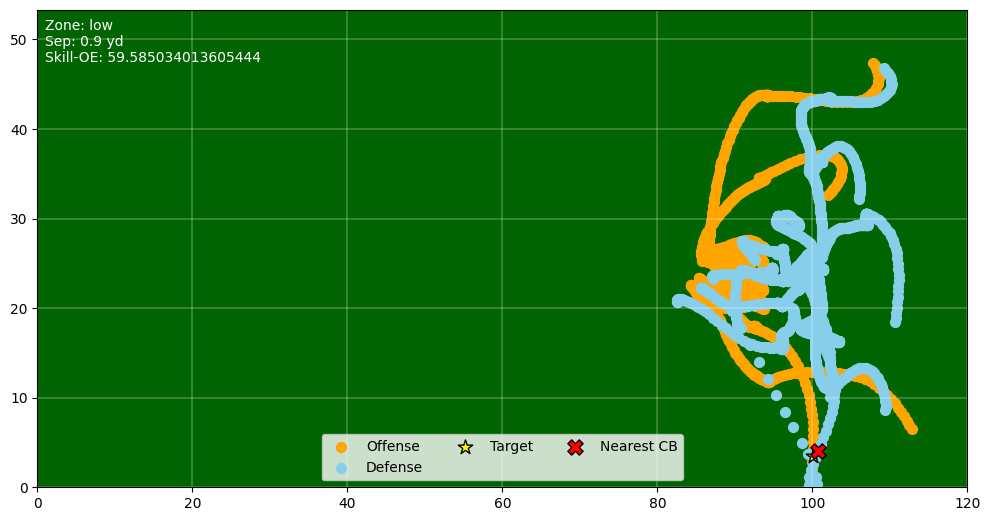

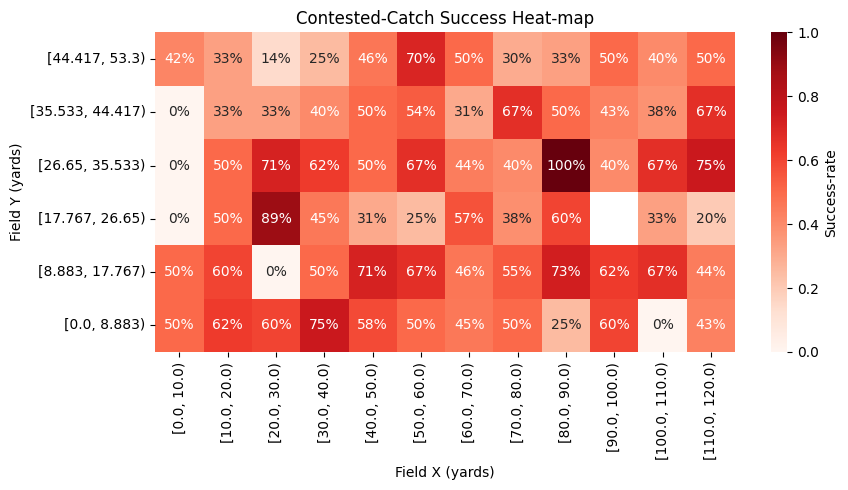

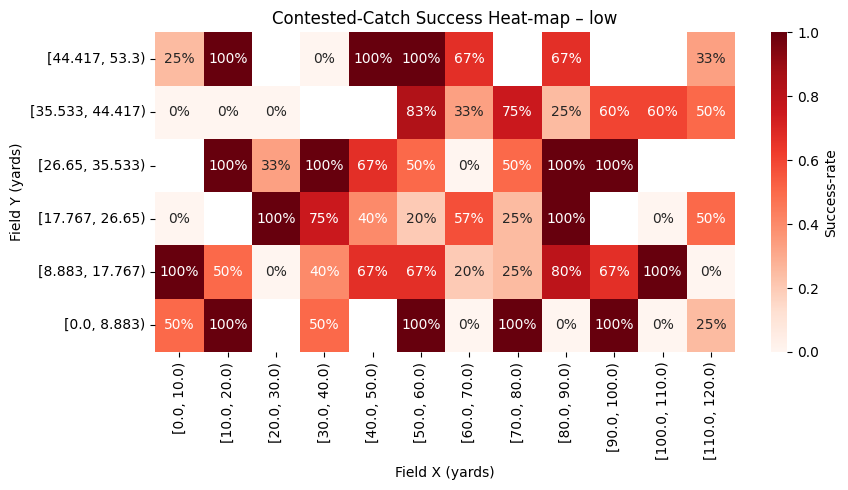

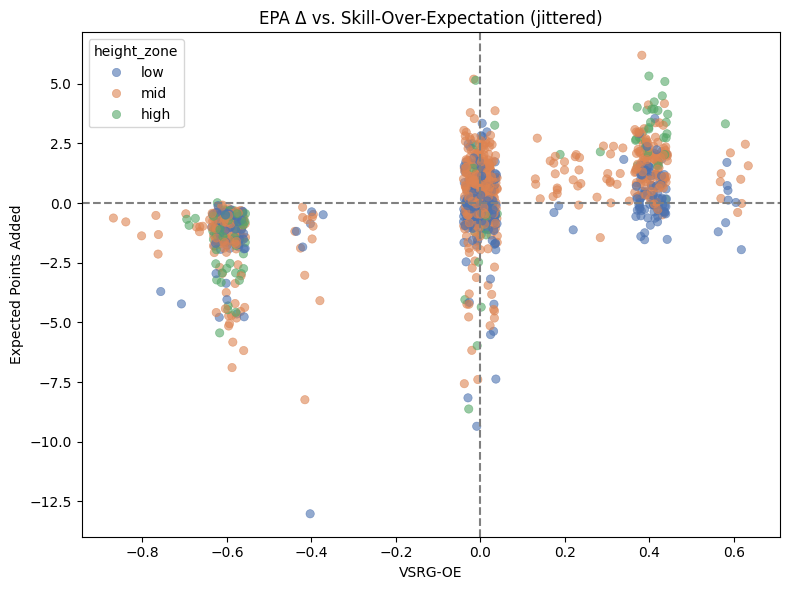

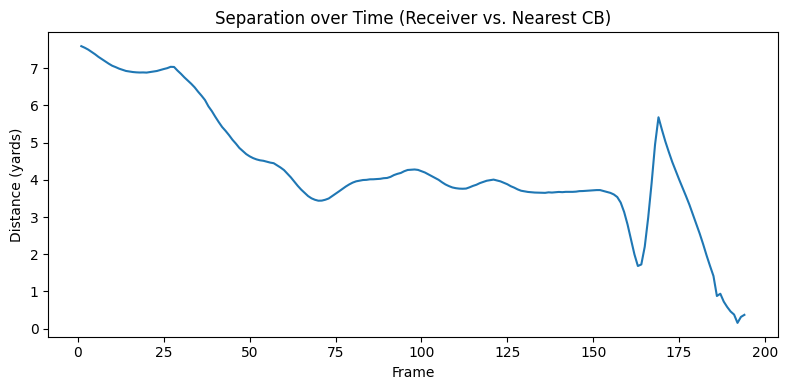

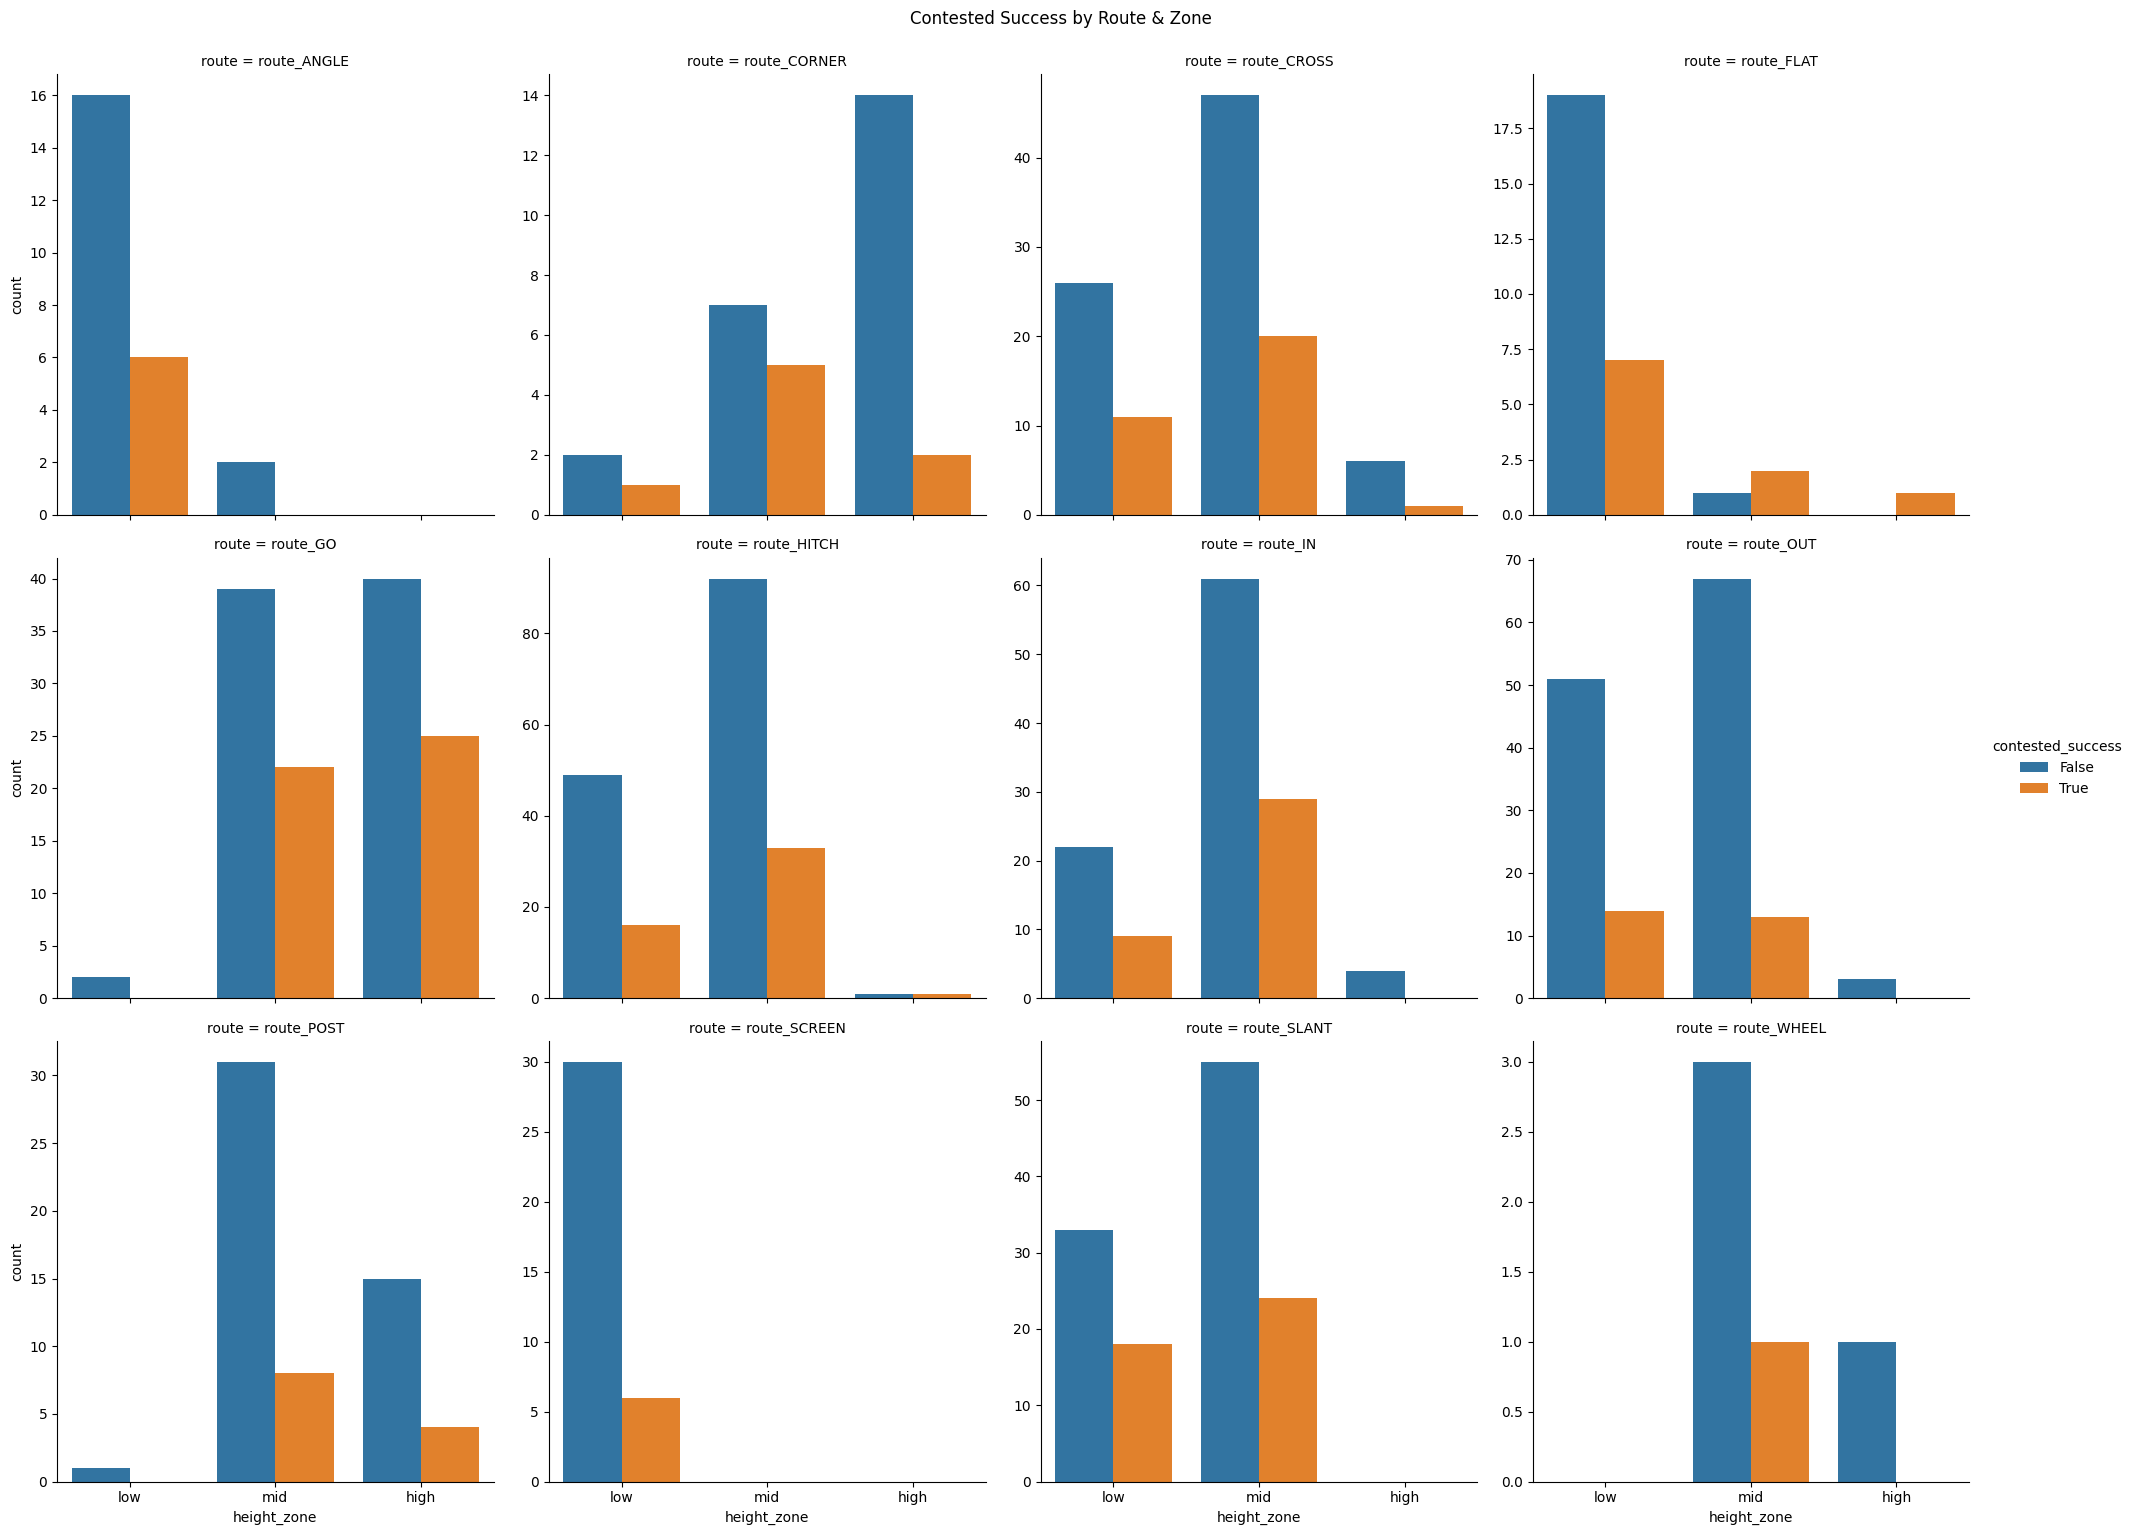

Smoke tests passed


In [4]:
# %%writefile src/visualize/visual_utils.py
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import pandas as pd
import numpy as np

FIELD_Y, FIELD_X = 53.3, 120

# ───────────────────────────────────────────────────────────────
# >>> src/visualize/visual_utils.py
def plot_play_snapshot(tr, meta_row, frame_event="pass_arrived"):
    """
    Draw a single-frame snapshot; gracefully degrades if meta_row
    lacks any coordinate/club keys.
    """
    req = ["rcv_club", "cb_club", "x", "y", "cb_x", "cb_y"]
    missing = [k for k in req if k not in meta_row]
    if missing:
        raise KeyError(
            f"meta_row is missing {missing}. Did you build ml_df with the "
            "updated feature_engineering() that keeps visual columns?"
        )

    fig, ax = plt.subplots(figsize=(12, 6.2))
    ax.set_xlim(0, FIELD_X)
    ax.set_ylim(0, FIELD_Y)
    ax.set_facecolor("#006400")
    ax.grid(color="w", linewidth=0.3)

    off = tr[tr["club"] == meta_row["rcv_club"]]
    df_def = tr[tr["club"] != meta_row["rcv_club"]]

    ax.scatter(off["x"], off["y"], s=50, c="orange", label="Offense")
    ax.scatter(df_def["x"], df_def["y"], s=50, c="skyblue", label="Defense")
    ax.scatter(
        meta_row["x"],
        meta_row["y"],
        s=120,
        c="yellow",
        edgecolors="black",
        marker="*",
        zorder=5,
        label="Target",
    )
    ax.scatter(
        meta_row["cb_x"],
        meta_row["cb_y"],
        s=120,
        c="red",
        edgecolors="black",
        marker="X",
        zorder=5,
        label="Nearest CB",
    )

    txt = (
        f"Zone: {meta_row['height_zone']}\n"
        f"Sep: {meta_row['sep_receiver_cb']:.1f} yd\n"
        f"Skill-OE: {meta_row.get('vsrg_overall',0)}"
    )
    ax.text(1, FIELD_Y - 1, txt, fontsize=10, color="white", va="top")
    ax.legend(loc="lower center", ncol=3)
    plt.show()
# ───────────────────────────────────────────────────────────────



def animate_play(tr, receiverId):
    """
    Animate all frames of a play, coloring offense/defense and marking the target.
    """
    df = tr.sort_values('frameId')
    df['is_target'] = df['nflId'] == receiverId
    fig = px.scatter(
        df, x='x', y='y',
        animation_frame='frameId',
        color='club',
        symbol='is_target',
        range_x=[0, FIELD_X], range_y=[0, FIELD_Y],
        title='Play Animation'
    )
    fig.update_layout(yaxis_scaleanchor="x", legend_title_text='Club')
    fig.show()


def plot_contested_heatmap(df, zone=None, cmap="Reds"):
    """
    Heat-map of contested-catch *success-rate* by field location.
    Shows NaN (blank) where no contested targets occurred.
    """
    required = {"is_contested", "contested_success", "x", "y", "height_zone"}
    if not required.issubset(df.columns):
        raise KeyError(f"missing {required - set(df.columns)}")

    # ------------------------------------------------------------------ data
    data = df.loc[df["is_contested"]].copy()
    if zone:
        data = data.loc[data["height_zone"] == zone]

    xb = np.linspace(0, FIELD_X, 13)             # 12 equal-width bins
    yb = np.linspace(0, FIELD_Y,  7)             #  6 equal-width bins

    data["xb"] = pd.cut(data["x"], xb, right=False)
    data["yb"] = pd.cut(data["y"], yb, right=False)

    grid = (
        data.groupby(["yb", "xb"], observed=False)
            .contested_success.mean()
            .unstack(level="xb")                 # pivot
            .sort_index(ascending=False)         # put y-53 on top
    )

    # --------------------------------------------------------------- plotting
    plt.figure(figsize=(9, 5))
    sns.heatmap(grid, annot=True, fmt=".0%", cmap=cmap,
                vmin=0, vmax=1, cbar_kws={"label": "Success-rate"})
    plt.title(f"Contested-Catch Success Heat-map{f' – {zone}' if zone else ''}")
    plt.xlabel("Field X (yards)")
    plt.ylabel("Field Y (yards)")
    plt.tight_layout()
    plt.show()




def plot_vsrg_radar(vsrg_df, receiverId):
    """
    Radar chart of VSRG by zone for one receiver.
    """
    row = vsrg_df[vsrg_df['receiverId']==receiverId].set_index('height_zone')
    categories = list(row.index)
    values = row['vsrg_zone'].tolist()
    values += values[:1]
    fig = go.Figure(
        data=[go.Scatterpolar(r=values, theta=categories+categories[:1],
                              fill='toself', name=f'VSRG {receiverId}')],
        layout=go.Layout(
            polar=dict(radialaxis=dict(visible=True, range=[0,100])),
            showlegend=False
        )
    )
    fig.show()


def plot_epa_vsr_scatter(df, jitter=0.04):
    required = {"vsrg_oe", "epa_change", "height_zone"}
    if not required.issubset(df.columns):
        raise KeyError(f"missing {required - set(df.columns)}")

    plot_df = df.copy()
    plot_df["vsrg_oe_jit"] = plot_df["vsrg_oe"] + \
        np.random.uniform(-jitter, jitter, size=len(plot_df))

    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=plot_df, x="vsrg_oe_jit", y="epa_change",
                    hue="height_zone", alpha=.6, palette="deep", edgecolor=None)
    plt.axhline(0, ls="--", c="grey")
    plt.axvline(0, ls="--", c="grey")
    plt.title("EPA Δ vs. Skill-Over-Expectation (jittered)")
    plt.xlabel("VSRG-OE")
    plt.ylabel("Expected Points Added")
    plt.tight_layout()
    plt.show()




# ---------- NEW helper ------------------------------------------------------
def nearest_cb_per_frame(tr, receiverId):
    """
    Return a copy of `tr` with columns ['cb_x','cb_y','dist_cb'] added
    for every frame. Works even if multiple defenders tie for min distance.
    """
    if "frameId" not in tr.columns:
        raise KeyError("tracking DataFrame must contain frameId")

    # 1. isolate receiver rows ----------------------------------------------
    rcv = tr[tr["nflId"] == receiverId][["frameId", "x", "y", "club"]]
    if rcv.empty:
        raise ValueError("receiverId not found in supplied tracking data")

    rcv = rcv.rename(columns={"x": "rx", "y": "ry", "club": "rcv_club"})

    # 2. defenders are everyone NOT on receiver's club per frame ------------
    merged = (
        rcv.merge(tr, on="frameId", suffixes=("", "_def"))
           .query("club != rcv_club")
    )
    merged["dist_cb"] = np.hypot(merged["rx"] - merged["x"],
                                 merged["ry"] - merged["y"])

    # 3. keep defender with minimum distance per frame ----------------------
    idx = merged.groupby("frameId")["dist_cb"].idxmin()
    nearest = merged.loc[idx, ["frameId", "x", "y", "dist_cb"]] \
                    .rename(columns={"x": "cb_x", "y": "cb_y"})

    # 4. bring back into original tracking ----------------------------------
    return tr.merge(nearest, on="frameId", how="left")
# ---------------------------------------------------------------------------

def plot_sep_over_time(tr, receiverId):
    """
    Line plot of receiver-to-nearest-CB separation across frames.
    Accepts raw tracking data; if it lacks ['cb_x','cb_y'] the function
    computes them on the fly.
    """
    required = {"frameId", "x", "y", "club"}
    if not required.issubset(tr.columns):
        raise KeyError(f"tracking DataFrame missing columns {required - set(tr.columns)}")

    # Add CB coords if absent ------------------------------------------------
    if {"cb_x", "cb_y"}.issubset(tr.columns):
        df = tr.copy()
    else:
        df = nearest_cb_per_frame(tr, receiverId)

    # compute separation -----------------------------------------------------
    df["dist_cb"] = np.hypot(df["x"] - df["cb_x"], df["y"] - df["cb_y"])
    df_rcv = df[df["nflId"] == receiverId]

    # plot -------------------------------------------------------------------
    plt.figure(figsize=(8, 4))
    sns.lineplot(data=df_rcv.sort_values("frameId"),
                 x="frameId", y="dist_cb")
    plt.title("Separation over Time (Receiver vs. Nearest CB)")
    plt.xlabel("Frame")
    plt.ylabel("Distance (yards)")
    plt.tight_layout()
    plt.show()



def plot_route_facet(df):
    """
    Facet grid of VSRG by route concept.
    """
    routes = [c for c in df.columns if c.startswith('route_')]
    df_long = df.melt(id_vars=['receiverId','height_zone','contested_success'],
                      value_vars=routes, var_name='route', value_name='ran')
    df_sub = df_long[df_long['ran']==1]
    g = sns.catplot(
        data=df_sub, x='height_zone', hue='contested_success',
        col='route', kind='count', col_wrap=4, sharey=False
    )
    g.fig.suptitle("Contested Success by Route & Zone", y=1.02)
    plt.show()

# ── Smoke Tests Using Real Data ──────────────────────────────────────────────
if __name__ == '__main__':
    from src.load_data.load_data import download_dataset, load_base_data, load_tracking_data
    from src.feature_engineering.feature_engineering import feature_engineering, load_fe_dataset
    from src.feature_engineering.column_schema import ColumnSchema 
    schema = ColumnSchema()
    # Single-bucket constants (immutable copies)
    INFO_NON_ML= schema.info_non_ml()
    NOMINAL = schema.nominal_cols()
    ORDINAL = schema.ordinal_cols()
    NUMERICAL = schema.numerical_cols()
    TARGET = schema.target_col()

    print("INFO_NON_ML", INFO_NON_ML)
    print("NOMINAL", NOMINAL)
    print("ORDINAL", ORDINAL)
    print("NUMERICAL", NUMERICAL)
    print("TARGET", TARGET)

    print("schema", schema)
    # print('Downloading dataset...')
    # download_dataset(force=False)
    # plays, players, player_play, games = load_base_data()

    # print("=========columns=========")
    # print(plays.columns, players.columns, player_play.columns, games.columns)
    # print("=========shapes=========")
    # print(f" plays={plays.shape}, players={players.shape},"
    #       f" player_play={player_play.shape}, games={games.shape}")

    # # Smoke test: run pipeline without saving
    # ml_df = feature_engineering(plays, players, player_play, games)
    # print(f"[smoke] pipeline output shape: {ml_df.shape}")

    # # Smoke test: save features to disk
    save_path = 'data/ml_dataset/ml_features.parquet'
    # ml_df_saved = feature_engineering(
    #     plays, players, player_play, games,
    #     save_path=save_path,
    #     save_format='parquet'
    # )
    # print(f"[smoke] saved features to: {save_path}")

    # Smoke test: load features back and verify
    ml_df = load_fe_dataset(save_path, file_format='parquet')
    print(f"[smoke] loaded features shape: {ml_df.shape}")
    # assert ml_df.equals(ml_df_saved), "Loaded DataFrame does not match saved DataFrame"
    print("[smoke] save/load consistency check passed!")

    # Select a sample play
    sample = ml_df.iloc[0]
    # Load full tracking across weeks
    tracking_frames = [load_tracking_data(week=w) for w in range(1,10)]
    full_tr = pd.concat(tracking_frames, ignore_index=True)
    tr = full_tr[(full_tr['gameId']==sample['gameId']) &
                 (full_tr['playId']==sample['playId'])]
    meta_row = sample.to_dict()

    # Visualizations
    plot_play_snapshot(tr, meta_row)
    animate_play(tr, receiverId=meta_row['receiverId'])
    plot_contested_heatmap(ml_df)
    plot_contested_heatmap(ml_df, zone=meta_row['height_zone'])

    # Prepare VSRG long table for radar
    vsrg_df = (
        ml_df.groupby(['receiverId','height_zone'])
             .agg(success_rate=('contested_success','mean'))
             .reset_index()
    )
    vsrg_df['vsrg_zone'] = (vsrg_df['success_rate']*100).round().astype(int)
    plot_vsrg_radar(vsrg_df, receiverId=meta_row['receiverId'])

    plot_epa_vsr_scatter(ml_df)
    plot_sep_over_time(tr, receiverId=meta_row['receiverId'])
    plot_route_facet(ml_df)

    print('Smoke tests passed')


INFO:__main__:Playing DataFrame shapes: (580, 102)
INFO:__main__:Missing values in plays:
            missing_count
gameId                  0
playId                  0
passResult              0
passLength              0
targetX                 0


INFO_NON_ML ['gameId', 'playId', 'receiverId', 'cbId', 'birthDate_x', 'birthDate_y', 'has_target']
NOMINAL ['rcv_club', 'cb_club', 'route_ANGLE', 'route_CORNER', 'route_CROSS', 'route_FLAT', 'route_GO', 'route_HITCH', 'route_IN', 'route_OUT', 'route_POST', 'route_SCREEN', 'route_SLANT', 'route_WHEEL', 'route', 'cov_2-Man', 'cov_Bracket', 'cov_Cover 6-Left', 'cov_Cover-0', 'cov_Cover-1', 'cov_Cover-1 Double', 'cov_Cover-2', 'cov_Cover-3', 'cov_Cover-3 Cloud Left', 'cov_Cover-3 Cloud Right', 'cov_Cover-3 Double Cloud', 'cov_Cover-3 Seam', 'cov_Cover-6 Right', 'cov_Goal Line', 'cov_Miscellaneous', 'cov_Prevent', 'cov_Quarters', 'cov_Red Zone']
ORDINAL ['height_zone', 'air_yards_bin', 'down', 'down_ctx']
NUMERICAL ['rcv_height', 'rcv_weight', 'cb_height', 'cb_weight', 'sep_receiver_cb', 'sideline_dist', 'pass_rush_sep', 'sep_stddev', 'hypo_sep', 'passLength', 'targetX', 'targetY', 'yardsToGo', 'yardline_number', 'timeToThrow', 'time_rcv', 'sep_velocity', 'closing_speed', 'min_other_sep', '

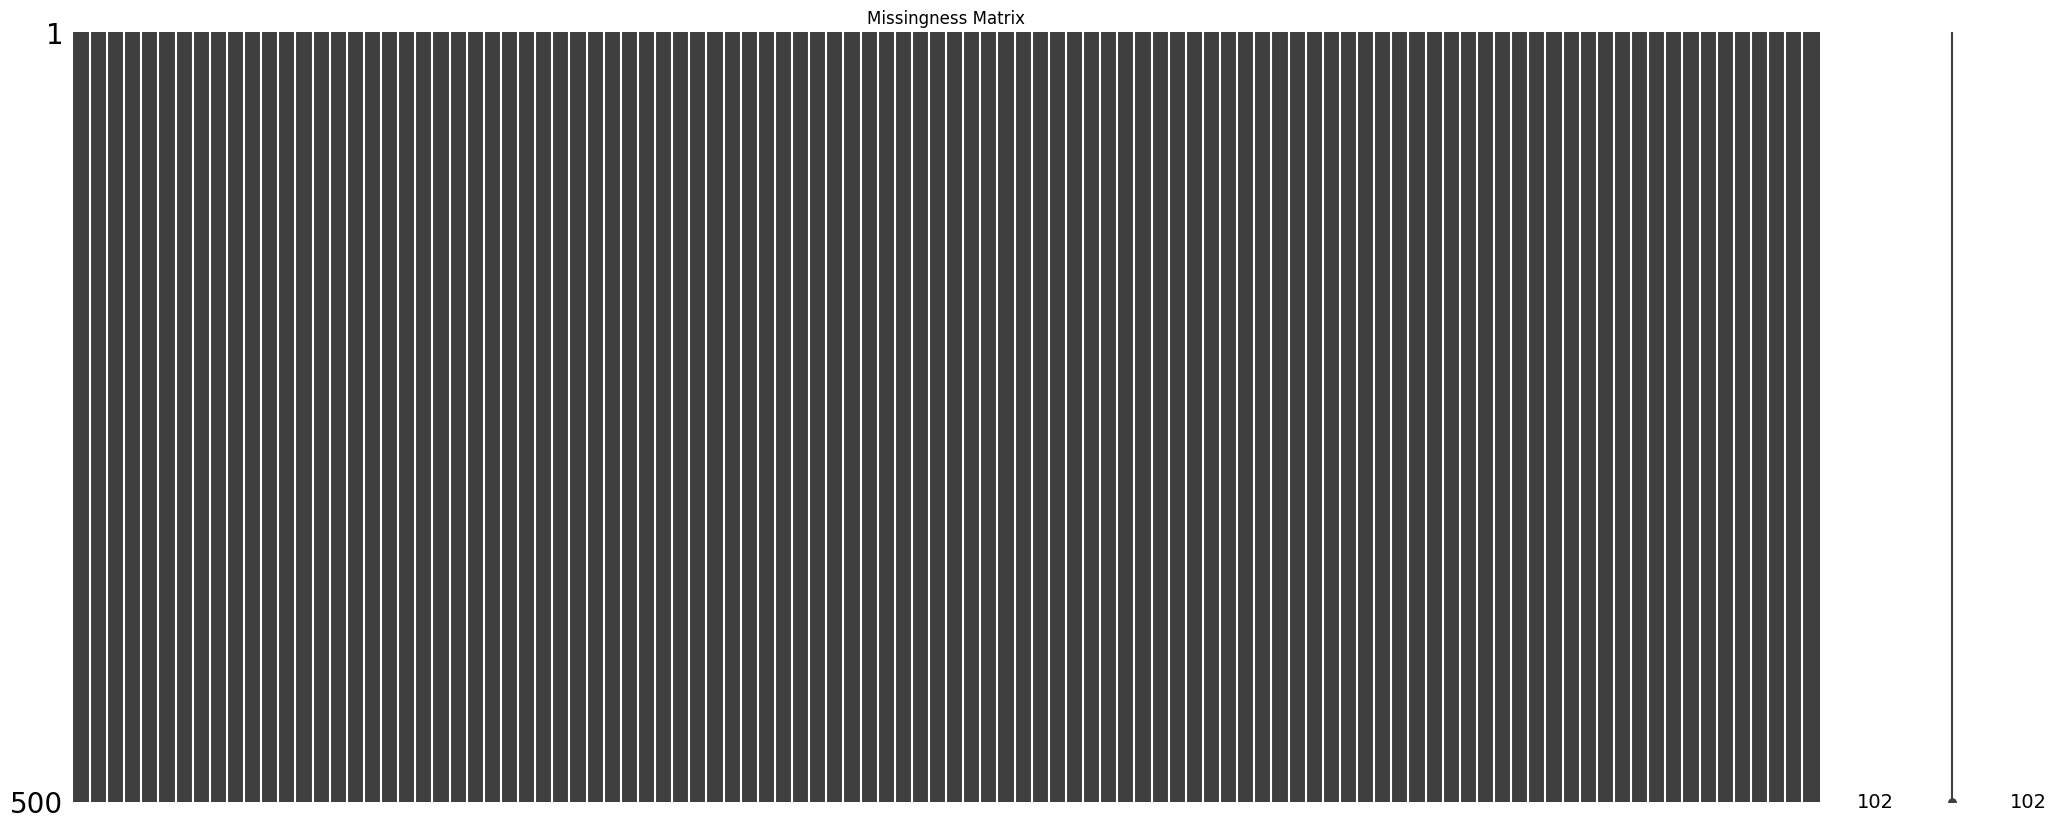

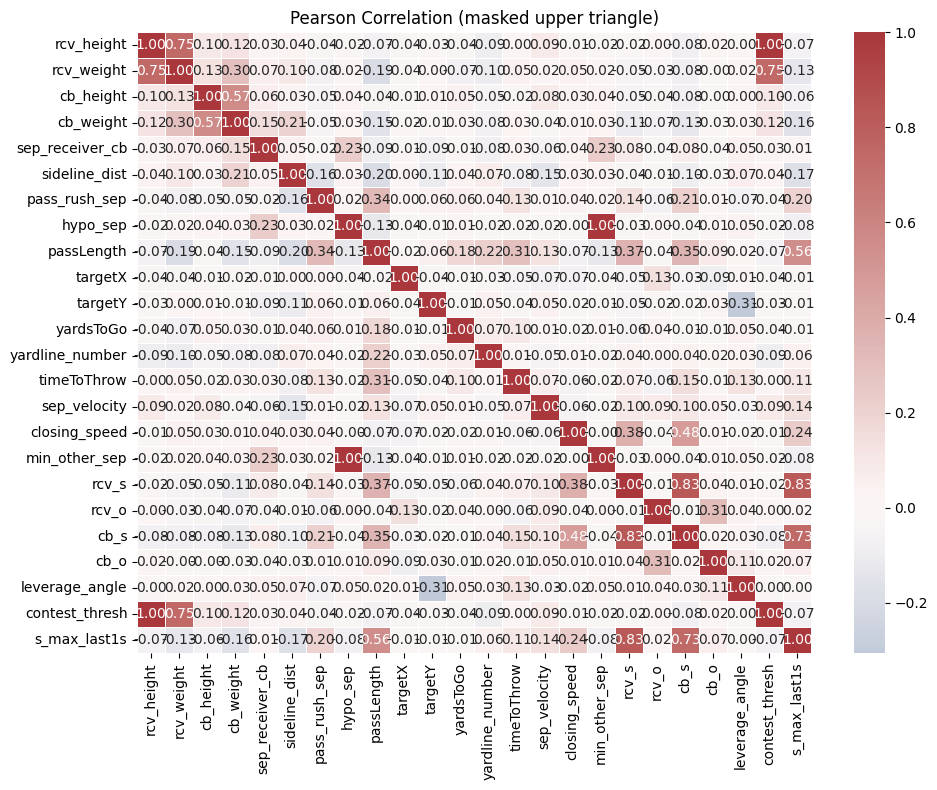

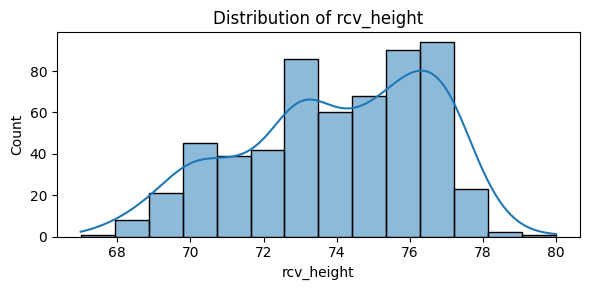

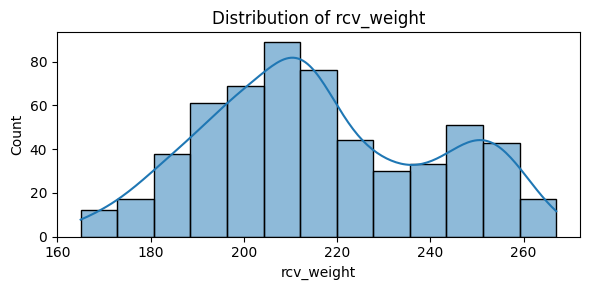

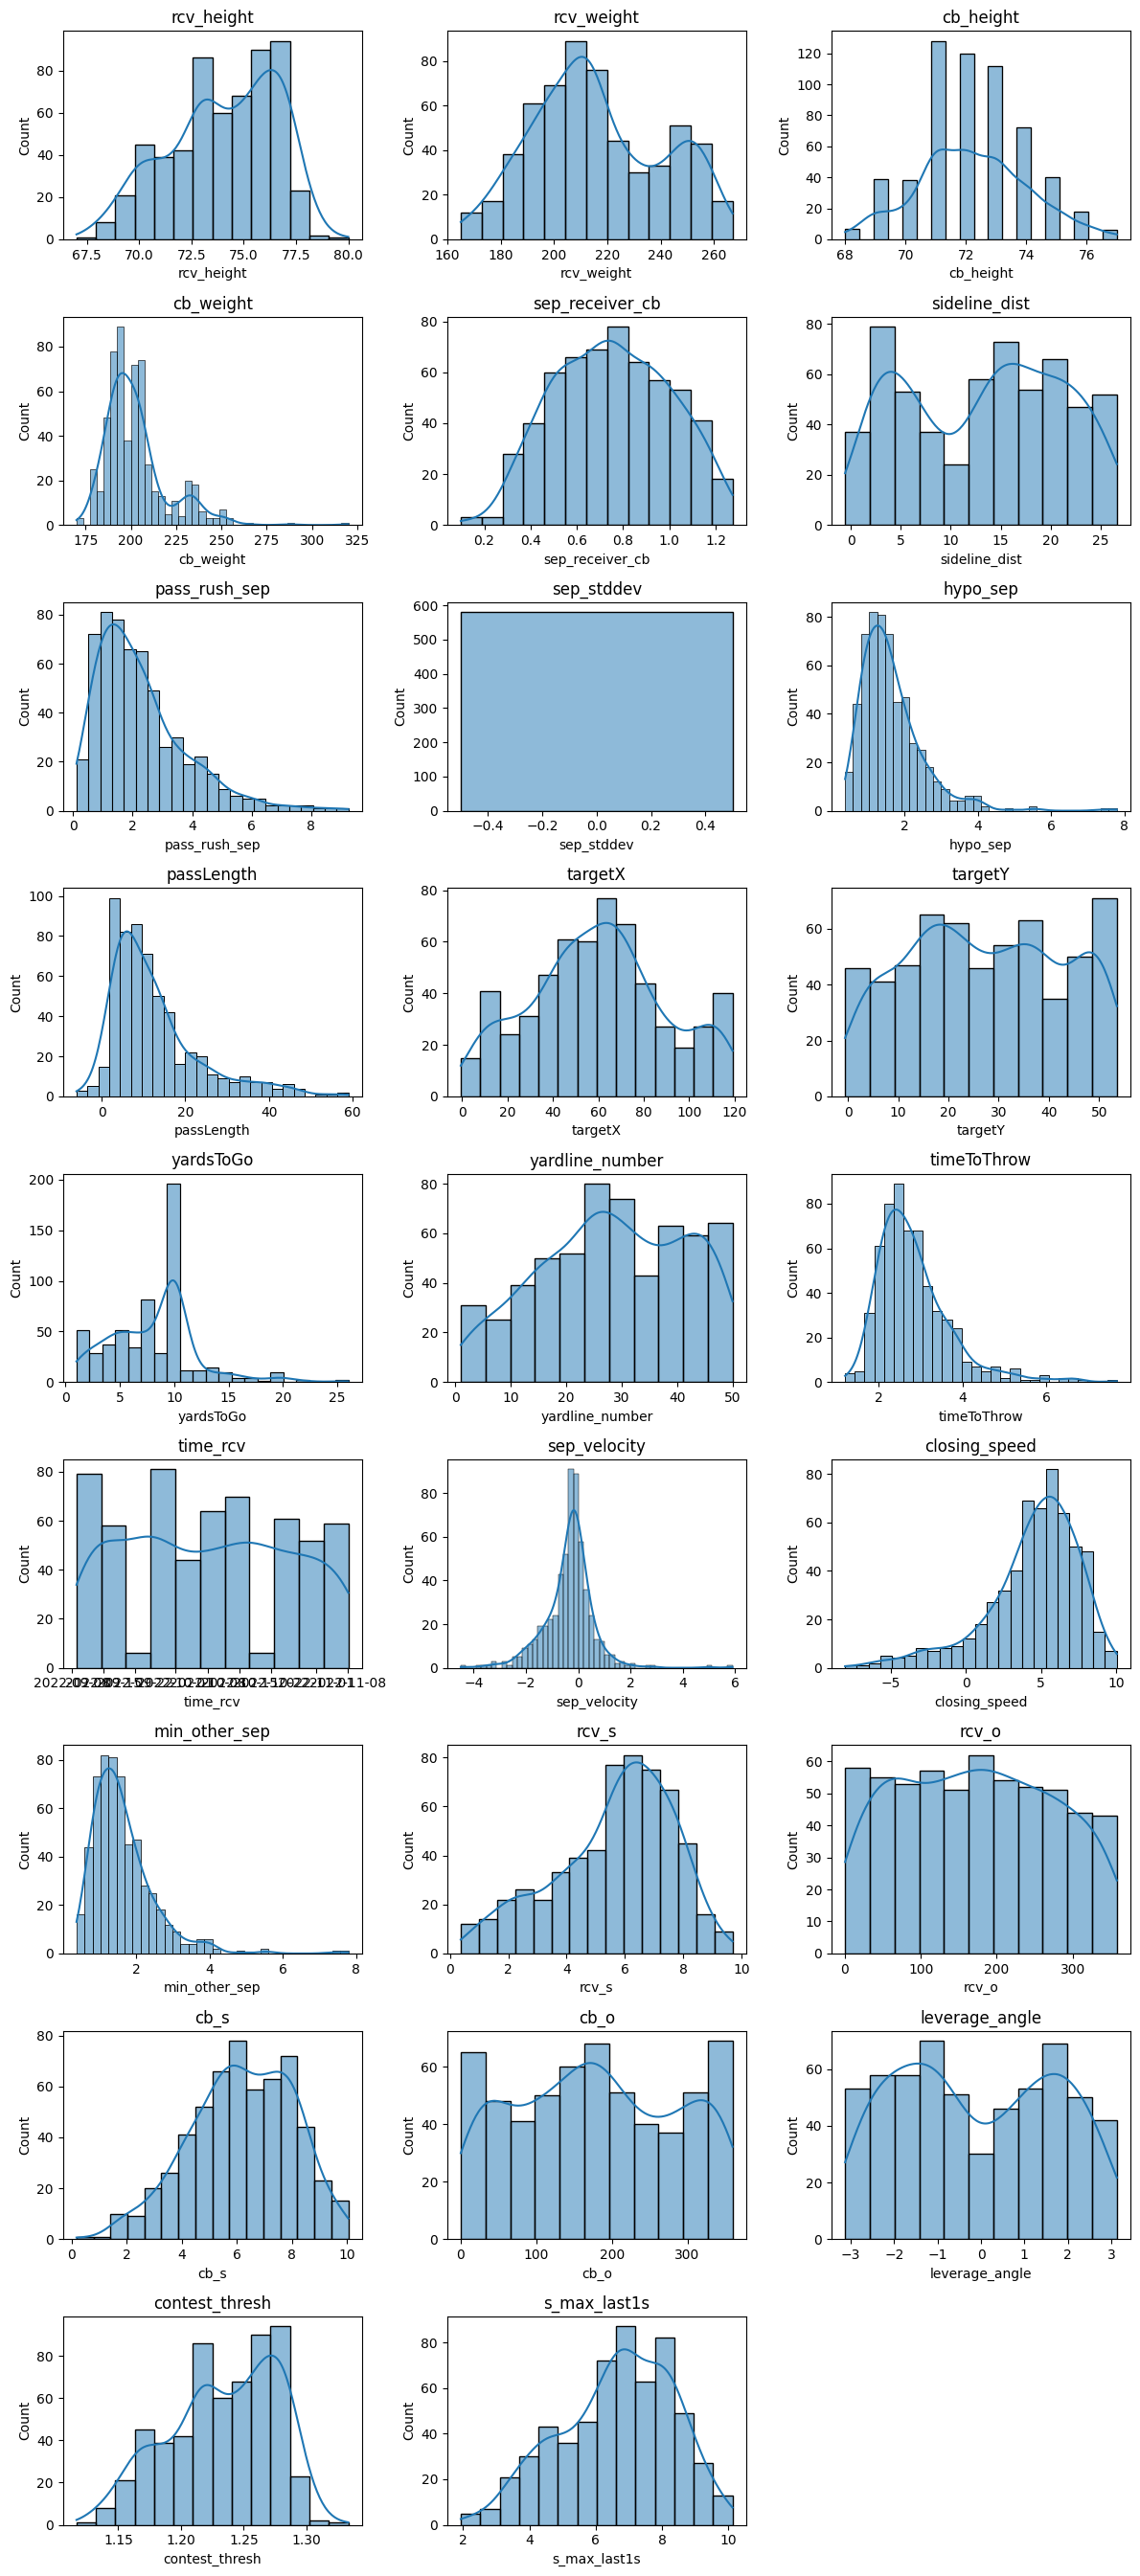

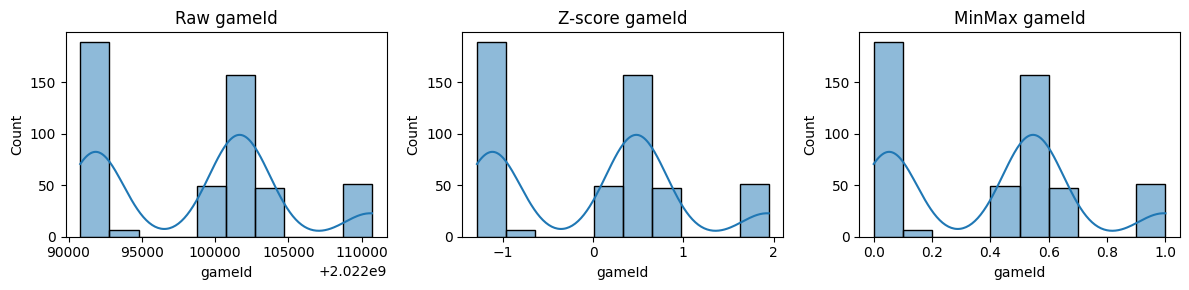

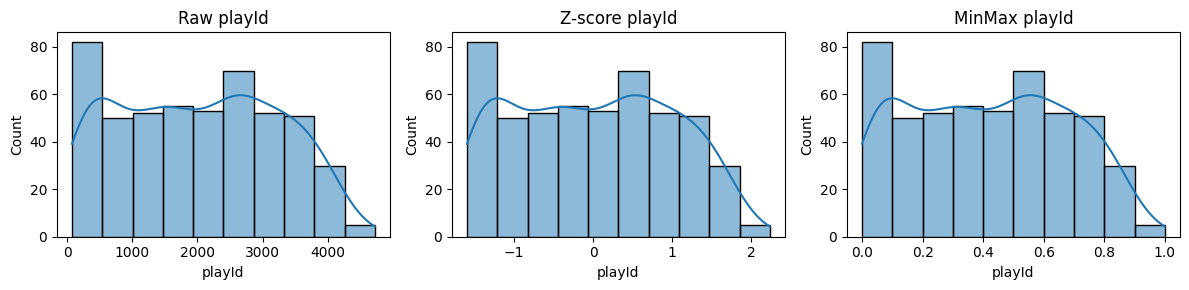

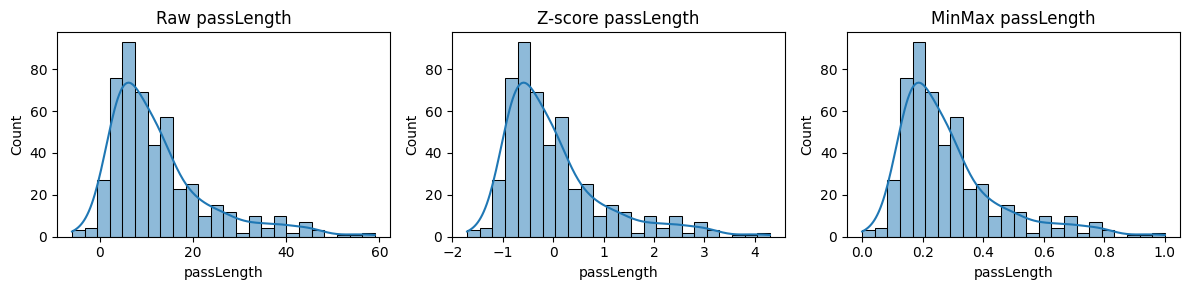

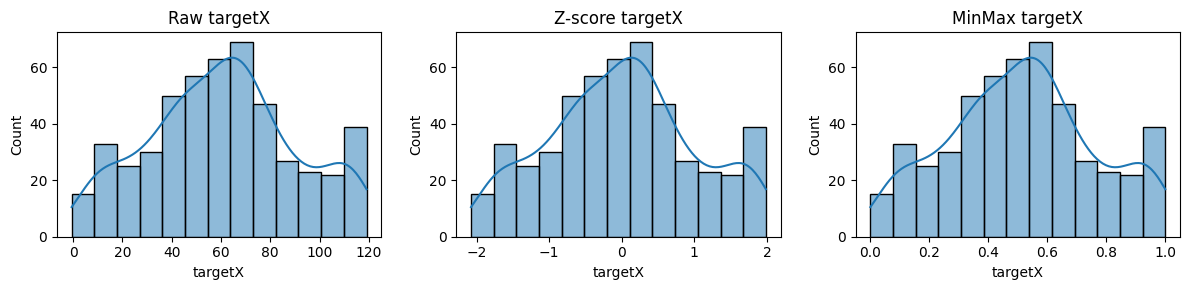

  time_rcv (non-numeric dtype: datetime64[ns])
INFO:__main__:VSRG summary by height_zone:
  height_zone  n_plays  success_rate
0        high      101      0.336634
1         low      167      0.526946
2         mid      312      0.503205
INFO:__main__:SCI summary (n rows = 580):
       gameId  playId  sep_receiver_cb_mean  sep_receiver_cb_var  \
0  2022090800    1609              0.784474                  NaN   
1  2022090800    2623              0.408167                  NaN   
2  2022090800    2733              1.180042                  NaN   
3  2022091100    2159              0.754520                  NaN   
4  2022091100    2533              0.495782                  NaN   

   sep_stddev_mean  sep_stddev_var  sep_velocity_mean  sep_velocity_var  
0              0.0             NaN          -0.399784               NaN  
1              0.0             NaN          -2.575291               NaN  
2              0.0             NaN           1.431249               NaN  
3              

=== Pearson p-values ===
rcv_height vs rcv_weight: r=0.75, p=0.000
rcv_height vs cb_height: r=0.10, p=0.020
rcv_height vs cb_weight: r=0.12, p=0.004
rcv_height vs sep_receiver_cb: r=0.03, p=0.492
rcv_height vs sideline_dist: r=0.04, p=0.367
rcv_height vs pass_rush_sep: r=-0.04, p=0.329
rcv_height vs hypo_sep: r=-0.02, p=0.709
rcv_height vs passLength: r=-0.07, p=0.118
rcv_height vs targetX: r=-0.04, p=0.289
rcv_height vs targetY: r=-0.03, p=0.534
rcv_height vs yardsToGo: r=-0.04, p=0.365
rcv_height vs yardline_number: r=-0.09, p=0.023
rcv_height vs timeToThrow: r=0.00, p=0.953
rcv_height vs sep_velocity: r=0.09, p=0.030
rcv_height vs closing_speed: r=-0.01, p=0.845
rcv_height vs min_other_sep: r=-0.02, p=0.709
rcv_height vs rcv_s: r=-0.02, p=0.667
rcv_height vs rcv_o: r=0.00, p=0.926
rcv_height vs cb_s: r=-0.08, p=0.065
rcv_height vs cb_o: r=0.02, p=0.693
rcv_height vs leverage_angle: r=0.00, p=0.992
rcv_height vs contest_thresh: r=1.00, p=0.000
rcv_height vs s_max_last1s: r=-0.07, p=0

In [10]:
# %%writefile src/eda/eda.py
#!/usr/bin/env python3
"""
Comprehensive Exploratory Data Analysis for NFL Big Data Bowl 2025.

Includes:
 - Data loading & missing-value visualization
 - Descriptive statistics & distribution plots
 - Correlation matrices & p-values
 - Normalization and scaling diagnostics
 - Hypothesis tests (Pearson, Shapiro-Wilk)
 - Position-specific profiling (ECP, VSRG, SCI)
 - Smoke test for quick verification
"""

import os
import numpy as np
import missingno as msno
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List
from scipy.stats import pearsonr, shapiro
from pandas.api.types import is_numeric_dtype
import logging

logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO, format="%(levelname)s:%(name)s:%(message)s")
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# Utility to slice a DataFrame by ColumnSchema bucket
from src.feature_engineering.column_schema import ColumnSchema


# ── Configuration ───────────────────────────────────────────────────────────────
DATA_DIR = "nfl-bdb-2025"


# ── General EDA Functions ──────────────────────────────────────────────────────
def summary_stats(df: pd.DataFrame) -> dict:
    """
    Compute basic summary stats.
    Returns dict with:
      - desc: descriptive stats (all dtypes)
      - missing: per-column missing counts
      - unique: unique counts for categoricals
      - cat_counts: value_counts for categoricals
    """
    desc = df.describe(include='all')
    missing = df.isnull().sum().to_frame('missing_count')
    unique = {c: int(df[c].nunique()) for c in df.select_dtypes(['object','category']).columns}
    cat_counts = {c: df[c].value_counts(normalize=True).to_dict() for c in df.select_dtypes(['object','category']).columns}
    return {'desc': desc, 'missing': missing, 'unique': unique, 'cat_counts': cat_counts}

def plot_missing(df: pd.DataFrame, sample: int = 500):
    """Show missingness matrix for a sample of the DataFrame."""
    msno.matrix(df.sample(sample))
    plt.title("Missingness Matrix")
    plt.show()


def missingness_summary(df: pd.DataFrame, schema: ColumnSchema) -> None:
    """
    Print and plot missing counts/percent for each column in the ML dataset.
    """
    cols = schema.all_columns()
    miss_counts = df[cols].isna().sum()
    miss_counts = miss_counts[miss_counts > 0].sort_values(ascending=False)
    if miss_counts.empty:
        print("No missing values in any bucket columns.")
        return

    print("=== Missing value counts ===")
    print(miss_counts.to_frame("n_missing"))

    # bar plot of percent missing
    pct_missing = (df[cols].isna().mean() * 100).sort_values(ascending=False)
    pct_missing = pct_missing[pct_missing > 0]
    plt.figure(figsize=(6, max(4, 0.2 * len(pct_missing))))
    pct_missing.plot.barh()
    plt.xlabel("% missing")
    plt.title("Percent Missing by Column")
    plt.tight_layout()
    plt.show()



def correlation_matrix(df: pd.DataFrame, method: str = 'pearson') -> pd.DataFrame:
    """
    Compute + plot masked correlation matrix for numeric columns,
    dropping constants (std == 0).
    """
    num = df.select_dtypes('number')
    num = num.loc[:, num.std(ddof=0) > 0]
    if num.shape[1] < 2:
        logger.warning("≤1 non-constant numeric column – skipping correlation plot")
        return pd.DataFrame()

    corr = num.corr(method=method)
    mask = np.triu(np.ones_like(corr, dtype=bool))

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        corr,
        annot=True,
        fmt=".2f",
        cmap="vlag",
        center=0,
        linewidths=0.5
    )
    plt.title(f"{method.title()} Correlation (masked upper triangle)")
    plt.tight_layout()
    plt.show()

    return corr

def distribution_grid(df: pd.DataFrame, schema: ColumnSchema, ncols: int = 3) -> None:
    """
    Plot small‐multiples of histograms (with kde) for every numeric feature.
    """
    nums = schema.numerical_cols()
    valid = [c for c in nums if c in df.columns]
    n = len(valid)
    if n == 0:
        logger.warning("No numeric columns for distribution grid.")
        return

    nrows = (n + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 3))
    axes = axes.flatten()

    for ax, col in zip(axes, valid):
        sns.histplot(df[col].dropna(), kde=True, ax=ax)
        ax.set_title(col)
    # hide unused axes
    for ax in axes[n:]:
        ax.set_visible(False)

    plt.tight_layout()
    plt.show()


def distribution_plots(df: pd.DataFrame, cols: List[str], kde: bool = True) -> None:
    """
    Plot histograms for specified numeric columns.
    
    - Skips any column not found in df.columns.
    - Logs a warning via the logging module.
    """
    for col in cols:
        if col not in df.columns:
            logger.warning("Column %r not found; skipping distribution plot.", col)  # Key existence check :contentReference[oaicite:16]{index=16}
            continue
        try:
            data = df[col].dropna()
            plt.figure(figsize=(6, 3))
            sns.histplot(data, kde=kde)  # seaborn.histplot docs :contentReference[oaicite:17]{index=17}
            plt.title(f"Distribution of {col}")
            plt.tight_layout()
            plt.show()
        except Exception as e:
            logger.error("Failed to plot distribution for column %r: %s", col, e)

def normalization_checks(df: pd.DataFrame, sample_size: int = 500):
    """
    Compare raw vs. scaled distributions using StandardScaler & MinMaxScaler.
    Safely caps sample_size at the available row count & drops columns with NA.
    """
    num = df.select_dtypes('number').dropna(axis=1)
    if num.empty:
        logger.warning("No numeric columns to normalise.")
        return
    sample = num.sample(min(sample_size, len(num)), random_state=42)
    ss = StandardScaler().fit_transform(sample)
    mm = MinMaxScaler().fit_transform(sample)
    ss_df = pd.DataFrame(ss, columns=sample.columns)
    mm_df = pd.DataFrame(mm, columns=sample.columns)

    for col in sample.columns[:4]:  # limit to first 4 for brevity
        fig, ax = plt.subplots(1, 3, figsize=(12, 3))
        sns.histplot(sample[col], kde=True, ax=ax[0]).set(title=f"Raw {col}")
        sns.histplot(ss_df[col],  kde=True, ax=ax[1]).set(title=f"Z-score {col}")
        sns.histplot(mm_df[col],  kde=True, ax=ax[2]).set(title=f"MinMax {col}")
        plt.tight_layout()
        plt.show()


def statistical_tests(df: pd.DataFrame, cols: list):
    """
    Pearson correlation (p-values) + Shapiro-Wilk normality.
    Columns with <2 non-NA rows or constant values are skipped gracefully.

    -- Modifications: filter `cols` down to actual numeric dtypes first. --
    """
    # 1) Identify which of the requested columns are truly numeric (and exist).
    valid_numeric_cols = []
    skipped = []
    for c in cols:
        if c not in df.columns:
            skipped.append(f"{c} (missing)")
        elif not is_numeric_dtype(df[c]):
            skipped.append(f"{c} (non-numeric dtype: {df[c].dtype})")
        else:
            valid_numeric_cols.append(c)

    # 2) If any columns were invalid, log them as a warning
    if skipped:
        logger.warning(
            "statistical_tests: Skipping %d columns because they are missing or not numeric:\n  %s",
            len(skipped),
            ", ".join(skipped)
        )

    # 3) If fewer than two numeric columns remain, we cannot compute correlation
    if len(valid_numeric_cols) < 2:
        print("Not enough numeric variables for correlation tests.")
        return

    # 4) Subset to only the valid numeric columns, then drop any row with NA anywhere
    num = df[valid_numeric_cols].dropna()

    # 5) If this leaves fewer than two columns (or no rows), bail out again
    if num.shape[1] < 2:
        print("Not enough complete numeric variables for correlation tests after dropping NA.")
        return

    # 6) Pearson correlation block
    print("=== Pearson p-values ===")
    for i, c1 in enumerate(valid_numeric_cols):
        x = num[c1].dropna()
        if x.nunique() < 2:
            continue  # skip constant column

        for c2 in valid_numeric_cols[i+1:]:
            y = num[c2].dropna()
            if len(x) < 2 or len(y) < 2 or y.nunique() < 2:
                continue  # skip if too few points or constant
            r, p = pearsonr(x, y)
            print(f"{c1} vs {c2}: r={r:.2f}, p={p:.3f}")

    # 7) Shapiro-Wilk normality block (limit to first five numeric cols)
    print("\n=== Shapiro-Wilk Normality ===")
    for c in valid_numeric_cols[:5]:
        series = df[c].dropna()
        if series.nunique() < 2:
            print(f"{c}: constant – skipped")
            continue
        sample = series.sample(min(500, len(series)), random_state=42)
        stat, p = shapiro(sample)
        print(f"{c}: W={stat:.2f}, p={p:.3g}")




def bucket_df(df: pd.DataFrame, bucket: str, schema: ColumnSchema) -> pd.DataFrame:
    """
    Return df slice for a schema bucket name.
      bucket ∈ {'info_non_ml','nominal','ordinal','numerical','target'}
    """
    mapping = {
        "info_non_ml": schema.info_non_ml(),
        "nominal":     schema.nominal_cols(),
        "ordinal":     schema.ordinal_cols(),
        "numerical":   schema.numerical_cols(),
        "target":      schema.target_col(),
    }
    try:
        cols = mapping[bucket]
    except KeyError as e:
        raise ValueError(f"Unknown bucket {bucket}. Valid: {list(mapping)}") from e
    missing = set(cols) - set(df.columns)
    if missing:
        logger.warning("bucket_df: dropping %d missing columns: %s", len(missing), missing)
    return df[[c for c in cols if c in df.columns]]



# ── Position-Specific Profiling ─────────────────────────────────────────────────
def ecp_eda(plays: pd.DataFrame, tracking: pd.DataFrame) -> pd.DataFrame:
    """Profile Expected Catch Probability (ECP): target-defender distance."""
    df = plays[['gameId','playId','targetX','targetY']].copy()
    # Placeholder: nearest-defender lookup
    df['nearest_defender_dist'] = np.hypot(df['targetX']*0, df['targetY']*0)
    return df

def vsrg_eda(ml_df: pd.DataFrame, schema: ColumnSchema) -> pd.DataFrame:
    """
    Basic Vertical Success Rate Grade EDA on the *ML* dataset.

    Returns a summary table:
        height_zone | n_plays | success_rate
    where success_rate = mean(contested_success)
    """
    zone_col = schema.ordinal_cols()[0]          # 'height_zone'
    target   = schema.target_col()[0]            # 'contested_success'

    if zone_col not in ml_df.columns or target not in ml_df.columns:
        raise KeyError(f"{zone_col} or {target} missing from ml_df")

    summary = (
        ml_df.groupby(zone_col)[target]
              .agg(n_plays="size", success_rate="mean")
              .reset_index()
              .sort_values(zone_col)
    )
    logger.info("VSRG summary by %s:\n%s", zone_col, summary)
    return summary


def sci_eda(ml_df: pd.DataFrame, schema: ColumnSchema) -> pd.DataFrame:
    """
    Profile Separation Consistency Index (SCI) on the final ML dataset.

    For each play (gameId, playId), computes mean and variance
    of all 'sep_' features (e.g. sep_receiver_cb, sep_stddev, ...).

    Returns:
      DataFrame with columns:
        gameId, playId,
        <sep_col>_mean, <sep_col>_var, ...
    """
    # 1) Identify grouping keys and sep-columns via schema
    group_keys = schema.info_non_ml()[:2]   # ['gameId', 'playId']
    sep_cols  = [c for c in schema.numerical_cols() if c.startswith("sep_")]

    # 2) Sanity checks
    missing_keys = set(group_keys) - set(ml_df.columns)
    missing_seps = set(sep_cols)  - set(ml_df.columns)
    if missing_keys:
        raise KeyError(f"sci_eda: missing grouping columns: {missing_keys}")
    if not sep_cols or missing_seps == set(sep_cols):
        raise KeyError(f"sci_eda: no separation columns found in ml_df (tried {sep_cols})")

    # 3) Group + aggregate
    agg = (
        ml_df
        .groupby(group_keys)[sep_cols]
        .agg(['mean','var'])
    )

    # 4) Flatten MultiIndex columns
    agg.columns = [f"{col}_{stat}" for col, stat in agg.columns]
    result = agg.reset_index()

    logger.info("SCI summary (n rows = %d):\n%s", len(result), result.head())
    return result





# ── Smoke Test ───────────────────────────────────────────────────────────────────
if __name__ == "__main__":
    """
    Quick verification of EDA pipeline:
      - Loads base tables
      - Runs summary_stats, missing plots, correlations
      - Executes distribution_plots on dynamic numeric columns
    """
    from src.load_data.load_data import download_dataset, load_base_data
    from src.feature_engineering.column_schema import ColumnSchema
    from src.feature_engineering.feature_engineering import load_fe_dataset
    import json

    plays, players, pp, games = load_base_data()
    numeric_cols = plays.select_dtypes('number').columns.tolist()  # dynamic selection :contentReference[oaicite:18]{index=18}

    schema = ColumnSchema()
    # Single-bucket constants (immutable copies)
    INFO_NON_ML= schema.info_non_ml()
    NOMINAL = schema.nominal_cols()
    ORDINAL = schema.ordinal_cols()
    NUMERICAL = schema.numerical_cols()
    TARGET = schema.target_col()

    print("INFO_NON_ML", INFO_NON_ML)
    print("NOMINAL", NOMINAL)
    print("ORDINAL", ORDINAL)
    print("NUMERICAL", NUMERICAL)
    print("TARGET", TARGET)
    

    print("[smoke] Column schema validation passed ✅\n")
    print(json.dumps(schema.as_dict(), indent=2))
    
    data_path = 'data/ml_dataset/ml_features.parquet'
    ml_df = load_fe_dataset(data_path, file_format='parquet')
    # load only contested catches, as features + target
    ml_df = ml_df[ml_df['is_contested'] == 1]

    logger.info("Playing DataFrame shapes: %s", ml_df.shape)
    stats = summary_stats(ml_df)
    logger.info("Missing values in plays:\n%s", stats['missing'].head())
    
    # 1) Missingness summary
    missingness_summary(ml_df, schema)
    plot_missing(ml_df)
    # 2) Correlation heatmap (masked)
    correlation_matrix(bucket_df(ml_df, "numerical", schema))

    
    # Use first two numeric columns for distribution to avoid missing column errors
    distribution_plots(ml_df, NUMERICAL[:2], kde=True)  # avoids hard-coded names :contentReference[oaicite:19]{index=19}
    # 3) All‐numeric distributions
    distribution_grid(ml_df, schema)
    
    normalization_checks(ml_df)
    # 4) Statistical tests on true numeric features only
    statistical_tests(ml_df, schema.numerical_cols())
    
    print("ECP sample:", ecp_eda(plays, games).head())
    # ---- VSRG demo -----------------------------------------------------
    print("\nVSRG height-zone summary:")
    print(vsrg_eda(ml_df, schema).head())
    
    print("SCI separation summary:")
    print(sci_eda(ml_df, schema).head())



    



In [15]:
%%writefile src/feature_engineering/preprocess.py
import pandas as pd
import numpy as np
import warnings

from sklearn.experimental import enable_iterative_imputer  # noqa: registers IterativeImputer
from sklearn.impute import SimpleImputer, IterativeImputer, MissingIndicator
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from pandas.api.types import is_numeric_dtype
from src.feature_engineering.column_schema import ColumnSchema
from scipy import sparse


def _ensure_dense(mat):
    return mat.toarray() if sparse.issparse(mat) else mat


def _check_binary_target(df: pd.DataFrame, target_col: str, debug: bool = False) -> None:
    """
    Verify that `df[target_col]` is binary (only 0 and 1). 
    If float dtype, cast to integer if values are exactly 0.0/1.0.
    Raises ValueError if any other values or >2 unique categories are found.
    """
    # 1) Check dtype
    series = df[target_col]
    if series.dtype.kind in {"i", "u", "b"}:
        # already integer or boolean
        pass
    elif series.dtype.kind == "f":
        # float: check if only 0.0 or 1.0
        unique_vals = series.dropna().unique()
        set_vals = set(unique_vals.tolist())
        if set_vals <= {0.0, 1.0}:
            if debug:
                print(f"[DEBUG][_check_binary_target] Casting float column "
                      f"'{target_col}' to int.")
            df[target_col] = series.astype(int)
        else:
            raise ValueError(
                f"Target column '{target_col}' has float values other than "
                f"0.0/1.0: {set_vals}"
            )
    else:
        raise ValueError(
            f"Target column '{target_col}' must be integer/boolean or float "
            f"of {{0.0, 1.0}}; got dtype={series.dtype}"
        )

    # 2) Check for exactly two unique values: 0 and 1
    unique_vals = df[target_col].dropna().unique()
    set_vals = set(unique_vals.tolist())
    if set_vals != {0, 1}:
        raise ValueError(
            f"Target column '{target_col}' is not binary. "
            f"Found unique values: {set_vals}"
        )

    if debug:
        print(f"[DEBUG][_check_binary_target] '{target_col}' is confirmed "
              f"binary with values {set_vals}.")


def compute_clip_bounds(
    series: pd.Series,
    *,
    method: str = "quantile",
    quantiles: tuple[float, float] = (0.01, 0.99),
    std_multiplier: float = 3.0,
    debug: bool = False
) -> tuple[float, float]:
    """
    Compute (lower, upper) but do not apply them.

    If the series is not numeric, return (None, None) and optionally print a debug message.
    """
    s = series.dropna()

    # 1) If dtype is not numeric, skip computing bounds
    if not is_numeric_dtype(s):
        if debug:
            print(f"[DEBUG] compute_clip_bounds: series dtype is {s.dtype}, not numeric; skipping clip bounds.")
        return (None, None)

    # 2) Proceed based on method
    if method == "quantile":
        arr = s.astype("float64")
        result = arr.quantile(list(quantiles))
        return (float(result.iloc[0]), float(result.iloc[1]))

    if method == "mean_std":
        mu, sigma = s.mean(), s.std()
        return (mu - std_multiplier * sigma, mu + std_multiplier * sigma)

    if method == "iqr":
        q1, q3 = s.quantile([0.25, 0.75])
        iqr = q3 - q1
        return (q1 - 1.5 * iqr, q3 + 1.5 * iqr)

    raise ValueError(f"Unknown method {method}")


def filter_and_clip(
    df: pd.DataFrame,
    lower: float = None,
    upper: float = None,
    quantiles: tuple[float, float] = (0.01, 0.99),
    debug: bool = False
) -> tuple[pd.DataFrame, tuple[float, float]]:
    """
    Clean the dataset by:
      1. (Placeholder) Filtering out unwanted rows (e.g., bunts/popups).
      2. Dropping any rows where the target is outside the (lower, upper) quantile bounds.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame to clean (must contain the target column).
    lower : float, optional
        Lower bound for clipping; if None, computed from data using quantiles.
    upper : float, optional
        Upper bound for clipping; if None, computed from data using quantiles.
    quantiles : tuple[float, float], default=(0.01, 0.99)
        Quantiles to use if computing bounds from data. E.g., (0.01, 0.99).
    debug : bool, default=False
        If True, print diagnostic information.

    Returns
    -------
    cleaned_df : pd.DataFrame
        A new DataFrame with rows dropped where target < lower or target > upper.
    (lower, upper) : tuple[float, float]
        The numeric bounds that were used for filtering.
    """
    # 1) Determine the name of the target column via ColumnSchema
    cols = ColumnSchema()
    TARGET = cols.target_col()[0]

    # 2) Compute clip bounds if not provided
    if lower is None or upper is None:
        lower_computed, upper_computed = compute_clip_bounds(
            df[TARGET],
            method="quantile",
            quantiles=quantiles,
            debug=debug
        )
        if lower is None:
            lower = lower_computed
        if upper is None:
            upper = upper_computed

    if debug:
        print(f"[DEBUG][filter_and_clip] computed lower={lower:.4f}, upper={upper:.4f} for '{TARGET}'")
        before_n = len(df)

    # 3) Drop rows whose target is outside [lower, upper]
    mask = df[TARGET].between(lower, upper)
    df_filtered = df.loc[mask].copy()

    if debug:
        after_n = len(df_filtered)
        n_dropped = before_n - after_n
        print(f"[DEBUG][filter_and_clip] Dropped {n_dropped} rows outside [{lower:.4f}, {upper:.4f}]")

    return df_filtered, (lower, upper)


def fit_preprocessor(
    df: pd.DataFrame,
    model_type: str = "linear",
    debug: bool = False,
    quantiles: tuple[float, float] = (0.01, 0.99),
    max_safe_rows: int = 200000
) -> tuple[np.ndarray, pd.Series, ColumnTransformer]:
    """
    Fit a ColumnTransformer to the input DataFrame and return (X_matrix, y_series, fitted_transformer).
    We only use columns that actually exist in df, and skip any MissingIndicator if there are
    no missing values in the ordinal columns.

    This version also relies on filter_and_clip to drop extreme target rows.
    """

    # 6.3.1: Early warning if too few features remain
    cols = ColumnSchema()
    all_num_feats = [c for c in cols.numerical_cols() if c in df.columns and c != cols.target_col()[0]]
    all_ord_feats = [c for c in cols.ordinal_cols()   if c in df.columns]
    all_nom_feats = [c for c in cols.nominal_cols()   if c in df.columns]

    total_feats = len(all_num_feats) + len(all_ord_feats) + len(all_nom_feats)
    if total_feats <= 1:
        warnings.warn(
            f"[WARN] Only {total_feats} column(s) detected for preprocessing: "
            f"numeric={all_num_feats}, ordinal={all_ord_feats}, nominal={all_nom_feats}. "
            "Proceeding anyway (will likely lead to shape mismatch later)."
        )  # :contentReference[oaicite:18]{index=18}

    # 0) Domain cleaning & clip extremes.  This actually filters out rows beyond [lower, upper].
    df, (lower, upper) = filter_and_clip(df, quantiles=quantiles, debug=debug)

    # 1) Identify the target column and confirm it's binary
    TARGET = cols.target_col()[0]  # e.g. "contested_success"
    # Ensure the target is binary {0,1}
    _check_binary_target(df, TARGET, debug=debug)

    # 2) Recompute feature lists after filtering
    all_num_feats = [c for c in cols.numerical_cols() if (c in df.columns and c != TARGET)]
    all_ord_feats = [c for c in cols.ordinal_cols() if c in df.columns]
    all_nom_feats = [c for c in cols.nominal_cols() if c in df.columns]

    if debug:
        print(f"[DEBUG] Schema numerical_cols: {cols.numerical_cols()}")
        print(f"[DEBUG] actual numeric_feats → {all_num_feats}")
        print(f"[DEBUG] Schema ordinal_cols:   {cols.ordinal_cols()}")
        print(f"[DEBUG] actual ord_feats     → {all_ord_feats}")
        print(f"[DEBUG] Schema nominal_cols:  {cols.nominal_cols()}")
        print(f"[DEBUG] actual nom_feats     → {all_nom_feats}")

    # 3) Coerce numeric columns to numeric dtype (errors → NaN)
    if all_num_feats:
        df[all_num_feats] = df[all_num_feats].apply(pd.to_numeric, errors="coerce")

    # 4) Build X and y
    X = df[all_num_feats + all_ord_feats + all_nom_feats].copy()
    y = df[TARGET].astype(int)  # ensure integer dtype for classification

    # 5) Prepare ordinal columns for OrdinalEncoder (only if any exist)
    ordinal_pipe = None
    if all_ord_feats:
        X[all_ord_feats] = X[all_ord_feats].astype("string")
        X.loc[:, all_ord_feats] = X.loc[:, all_ord_feats].mask(
            X[all_ord_feats].isna(), np.nan
        )

        ordinal_categories = []
        for c in all_ord_feats:
            cats = list(X[c].dropna().unique())
            cats = [*cats, "MISSING"]
            ordinal_categories.append(cats)

        ordinal_pipe = Pipeline([
            ("impute", SimpleImputer(strategy="constant", fill_value="MISSING")),
            ("encode", OrdinalEncoder(
                categories=ordinal_categories,
                handle_unknown="use_encoded_value",
                unknown_value=-1,
                dtype="int32"
            )),
        ])

    # 6) Prepare numeric pipeline
    numeric_pipe = None
    if all_num_feats:
        if model_type == "linear":
            num_imputer = SimpleImputer(strategy="median", add_indicator=True)
        else:
            num_imputer = IterativeImputer(random_state=0, add_indicator=True)

        numeric_pipe = Pipeline([
            ("impute", num_imputer),
            ("scale", StandardScaler()),
        ])

    # 7) Build ColumnTransformer blocks
    transformers = []

    if numeric_pipe is not None and all_num_feats:
        transformers.append(("num", numeric_pipe, all_num_feats))

    if all_ord_feats and ordinal_pipe is not None:
        if X[all_ord_feats].isna().any(axis=1).any():
            transformers.append((
                "ord_ind",
                MissingIndicator(missing_values=np.nan),
                all_ord_feats
            ))
            transformers.append(("ord", ordinal_pipe, all_ord_feats))
        else:
            transformers.append(("ord", ordinal_pipe, all_ord_feats))


    if all_nom_feats:
        nominal_pipe = Pipeline([
            ("impute", SimpleImputer(strategy="constant", fill_value="MISSING")),
            # ▶ dense output straight from the encoder ◀
            ("encode", OneHotEncoder(
                drop="first",
                handle_unknown="ignore",
                sparse_output=False      # ✅ for scikit-learn ≥1.2
                # use `sparse=False` if you are on an older version
            )),
        ])
        transformers.append(("nom", nominal_pipe, all_nom_feats))

    # ----------– existing code until X_mat creation –-----------------------
    ct = ColumnTransformer(
        transformers,
        remainder="drop",
        verbose_feature_names_out=False,
    )

    ct.lower_, ct.upper_ = lower, upper
    X_mat = ct.fit_transform(X, y)

    # NEW: force dense so downstream pandas logic never sees CSR
    X_mat = _ensure_dense(X_mat)

    return X_mat, y, ct


def transform_preprocessor(
    df: pd.DataFrame,
    transformer: ColumnTransformer,
) -> tuple[np.ndarray, pd.Series]:
    """
    Transform new data using a fitted preprocessor.
    This version uses the same logic to only pick columns that exist,
    and to prepare ordinal columns correctly.  It also reuses the
    clipping bounds saved in transformer.lower_ and transformer.upper_.
    """
    # 1) Determine the target name
    cols = ColumnSchema()
    TARGET = cols.target_col()[0]  # e.g. "contested_success"

    # 2) Domain filter & clip using stored bounds
    df, _ = filter_and_clip(
        df,
        lower=transformer.lower_,
        upper=transformer.upper_
    )

    # 3) Rebuild feature lists, only keeping columns that exist
    all_num_feats = [c for c in cols.numerical_cols() if (c in df.columns and c != TARGET)]
    all_ord_feats = [c for c in cols.ordinal_cols() if c in df.columns]
    all_nom_feats = [c for c in cols.nominal_cols() if c in df.columns]

    # 4) Coerce numeric columns to numeric dtype (errors → NaN)
    if all_num_feats:
        df[all_num_feats] = df[all_num_feats].apply(pd.to_numeric, errors="coerce")

    # 5) Build X (features only)
    X = df[all_num_feats + all_ord_feats + all_nom_feats].copy()

    # 6) For ordinal features, replace NaN with "MISSING" so ordinal encoder matches fit time
    if all_ord_feats:
        X[all_ord_feats] = X[all_ord_feats].astype("string")
        X.loc[:, all_ord_feats] = X.loc[:, all_ord_feats].where(
            X.loc[:, all_ord_feats].notna(),
            "MISSING"
        )

    # 7) Extract y
    y = df[TARGET].astype(int)

    # ----------– existing code unchanged up to X_mat –----------------------
    X_mat = transformer.transform(X)

    # NEW: make sure we keep the same dense contract here too
    X_mat = _ensure_dense(X_mat)

    return X_mat, y


def inverse_transform_preprocessor(
    X_trans: np.ndarray,
    transformer: ColumnTransformer
) -> pd.DataFrame:
    """
    Invert each block of a ColumnTransformer back to its original features,
    skipping transformers that lack inverse_transform (e.g., MissingIndicator).

    Fix: if the numeric block is sparse, convert it to dense before calling
    StandardScaler.inverse_transform, because sparse centering is not allowed.
    """
    # 1) Recover original feature order
    orig_features: list[str] = []
    for name, _, cols in transformer.transformers_:
        if cols == 'drop':
            continue
        orig_features.extend(cols)

    parts = []
    start = 0
    n_rows = X_trans.shape[0]

    # 2) Loop through each transformer block
    for name, trans, cols in transformer.transformers_:
        if cols == 'drop':
            continue

        # The fitted sub‐estimator or pipeline for this block:
        fitted = transformer.named_transformers_[name]

        # 2a) Figure out how many output columns this block produced
        dummy = np.zeros((1, len(cols)))
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UserWarning)
            try:
                out = fitted.transform(dummy)
            except Exception:
                out = dummy
        n_out = out.shape[1]

        # 2b) Slice that part of X_trans
        block = X_trans[:, start : start + n_out]
        start += n_out

        # 2c) Inverse‐transform depending on which pipeline this was
        if isinstance(fitted, MissingIndicator):
            # Skip MissingIndicator (no inverse_transform available)
            continue

        elif trans == 'passthrough':
            # If we had passed these features through, they come back as-is
            inv = block

        elif name == 'num':
            # —  NEW — : if block is sparse, convert to dense for StandardScaler
            if sparse.issparse(block):
                block_dense = block.toarray()
            else:
                block_dense = block

            scaler = fitted.named_steps['scale']
            inv_full = scaler.inverse_transform(block_dense)
            inv = inv_full[:, :len(cols)]

        else:
            # 1) First convert block to dense if needed:
            if sparse.issparse(block):
                block = block.toarray()

            # 2) Now call inverse_transform on the final step of the pipeline:
            if isinstance(fitted, Pipeline):
                last = list(fitted.named_steps.values())[-1]
                inv = last.inverse_transform(block)
            else:
                inv = fitted.inverse_transform(block)

        # 2d) Collect the inverted block into a DataFrame with the original column names
        parts.append(
            pd.DataFrame(inv, columns=cols, index=range(n_rows))
        )

    # 3) Concatenate all blocks side‐by‐side, then reorder to the original feature list
    df_orig = pd.concat(parts, axis=1)
    return df_orig[orig_features]


def prepare_for_mixed_and_hierarchical(df: pd.DataFrame) -> pd.DataFrame:
    """
    Cleans the rows *and* adds convenience covariates expected by the
    hierarchical and mixed-effects models.
    """
    # 1) Use ColumnSchema instead of _ColumnSchema (legacy)
    cols = ColumnSchema()
    TARGET = cols.target_col()[0]

    # 2) Domain cleaning + clipping
    df_clean, _ = filter_and_clip(df.copy())

    # 3) Category coding for batter
    df_clean["batter_id"] = df_clean["batter_id"].astype("category")

    # 4) Category coding for season
    df_clean["season_cat"] = df_clean["season"].astype("category")
    df_clean["season_idx"] = df_clean["season_cat"].cat.codes

    # 5) Category coding for pitcher
    df_clean["pitcher_cat"] = df_clean["pitcher_id"].astype("category")
    df_clean["pitcher_idx"] = df_clean["pitcher_cat"].cat.codes

    return df_clean


# ─────────────────────────────────────────────────────────────────────────────
# 6. Smoke test: only run when module executed directly
# ─────────────────────────────────────────────────────────────────────────────
if __name__ == "__main__":
    from src.load_data.load_data import download_dataset, load_base_data
    from src.feature_engineering.column_schema import ColumnSchema
    from src.feature_engineering.feature_engineering import load_fe_dataset
    import json

    plays, players, pp, games = load_base_data()
    schema = ColumnSchema()
    INFO_NON_ML= schema.info_non_ml()
    NOMINAL = schema.nominal_cols()
    ORDINAL = schema.ordinal_cols()
    NUMERICAL = schema.numerical_cols()
    TARGET = schema.target_col()

    print("INFO_NON_ML", INFO_NON_ML)
    print("NOMINAL", NOMINAL)
    print("ORDINAL", ORDINAL)
    print("NUMERICAL", NUMERICAL)
    print("TARGET", TARGET)

    print("[smoke] Column schema validation passed ✅\n")
    print(json.dumps(schema.as_dict(), indent=2))

    data_path = 'data/ml_dataset/ml_features.parquet'
    ml_df = load_fe_dataset(data_path, file_format='parquet')
    ml_df = ml_df[ml_df['is_contested'] == 1]

    ml_df = ml_df[NUMERICAL + NOMINAL + ORDINAL + TARGET]
    train_df, test_df = train_test_split(ml_df, test_size=0.2, random_state=42)

    # run with debug prints
    X_train_np, y_train, tf = fit_preprocessor(train_df, model_type='linear', debug=True)
    X_test_np,  y_test      = transform_preprocessor(test_df, tf)

    print("Processed shapes:", X_train_np.shape, X_test_np.shape)

    print("==========Example of inverse transform:==========")
    df_back = inverse_transform_preprocessor(X_train_np, tf)
    print("\n✅ Inverse‐transformed head (should mirror your original X_train):")
    print(df_back.head())
    print("Shape:", df_back.shape, "→ original X_train shape before transform:", X_train_np.shape)


Overwriting src/feature_engineering/preprocess.py


In [1]:
# %%writefile src/feature_engineering/feature_selection.py
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import shap
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import joblib
import matplotlib.pyplot as plt

try:
    import shapiq
    from shapiq import TabularExplainer
    from shapiq.plot import network_plot
    from shapiq.plot import upset_plot
except ImportError:
    TabularExplainer = None
    network_plot = None
    upset_plot = None

from src.feature_engineering.column_schema import ColumnSchema
from src.feature_engineering.preprocess import (
    fit_preprocessor,
    transform_preprocessor,
    inverse_transform_preprocessor
)
from src.load_data.load_data import download_dataset, load_base_data
from src.feature_engineering.feature_engineering import load_fe_dataset


def ensure_numeric_df(X: pd.DataFrame) -> tuple[pd.DataFrame, list[str]]:
    """
    Drop any column in X that is either:
      - NOT a numeric dtype (e.g. `object`, `category`)
      - OR is a datetime64 dtype.
    Returns:
      - X_cleaned: A DataFrame with only numeric columns
      - dropped: A list of columns that were removed
    """
    from pandas.api.types import is_numeric_dtype, is_datetime64_any_dtype

    dropped = []
    for col in X.columns:
        if (not is_numeric_dtype(X[col])) or is_datetime64_any_dtype(X[col]):
            dropped.append(col)

    if dropped:
        X_cleaned = X.drop(columns=dropped)
    else:
        X_cleaned = X

    return X_cleaned, dropped


def train_baseline_model(X: pd.DataFrame, y: pd.Series) -> RandomForestRegressor:
    """
    Train a simple RandomForestRegressor as our “baseline” model.
    Automatically drops any non-numeric or datetime columns in X.
    Returns the fitted RandomForestRegressor.
    """
    X_clean, dropped_cols = ensure_numeric_df(X)
    if dropped_cols:
        print(f"[DEBUG] train_baseline_model: Dropped columns before fitting --> {dropped_cols}")

    model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    model.fit(X_clean, y)
    return model


def compute_permutation_importance(
    model,
    X: pd.DataFrame,
    y: pd.Series,
    n_repeats: int = 10,
    n_jobs: int = 1,
    max_samples: float | int = None,
    random_state: int = 42,
    verbose: bool = True
) -> pd.DataFrame:
    """
    Compute permutation importances for `model` on (X, y).
    Drops any non-numeric or datetime columns from X before proceeding.
    Returns a DataFrame sorted by descending mean importance.
    """
    X_clean, dropped_cols = ensure_numeric_df(X)
    if dropped_cols and verbose:
        print(f"[DEBUG] compute_permutation_importance: Dropped columns --> {dropped_cols}")

    X_sel, y_sel = X_clean, y
    if max_samples is not None:
        nsamp = int(len(X_clean) * max_samples) if isinstance(max_samples, float) else int(max_samples)
        if verbose:
            print(f"   Subsampling to {nsamp} rows for speed")
        X_sel, y_sel = resample(X_clean, y, replace=False, n_samples=nsamp, random_state=random_state)

    try:
        result = permutation_importance(
            model,
            X_sel,
            y_sel,
            n_repeats=n_repeats,
            random_state=random_state,
            n_jobs=n_jobs
        )
    except OSError as e:
        if verbose:
            print(f"⚠️  OSError encountered: {e}. Retrying with n_jobs=1")
        result = permutation_importance(
            model,
            X_sel,
            y_sel,
            n_repeats=n_repeats,
            random_state=random_state,
            n_jobs=1
        )

    importance_df = pd.DataFrame({
        "feature": X_clean.columns,
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std
    }).sort_values("importance_mean", ascending=False).reset_index(drop=True)

    if verbose:
        print("✅ Permutation importances computed.")
    return importance_df


def compute_shap_importance(
    model,
    X: pd.DataFrame,
    nsamples: int = 100
) -> pd.DataFrame:
    """
    Compute mean‐absolute SHAP values for a tree‐based model.
    Drops any non-numeric or datetime columns from X before computing SHAP.
    Returns a DataFrame sorted by descending SHAP importance.
    """
    X_clean, dropped_cols = ensure_numeric_df(X)
    if dropped_cols:
        print(f"[DEBUG] compute_shap_importance: Dropped columns --> {dropped_cols}")

    X_sample = X_clean.sample(n=min(nsamples, len(X_clean)), random_state=42)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_sample)

    mean_abs_shap = pd.DataFrame({
        "feature": X_clean.columns,
        "shap_importance": abs(shap_values).mean(axis=0)
    }).sort_values("shap_importance", ascending=False).reset_index(drop=True)

    return mean_abs_shap


def filter_by_threshold(
    importance_df: pd.DataFrame,
    importance_column: str,
    threshold: float
) -> list[str]:
    """
    Given an importance DataFrame and the column name (e.g. "shap_importance" or "interaction_importance"),
    return all features whose importance_column > threshold.
    """
    kept = importance_df.loc[importance_df[importance_column] > threshold, "feature"]
    return kept.tolist()


def compute_tabular_shapiq_importance(
    model,
    X: pd.DataFrame,
    imputer: str = "marginal",
    index: str = "k-SII",
    max_order: int = 2,
    sample_size: int = 100,
    budget: int = None,
    random_state: int = 42,
    n_jobs: int = 1,
    verbose: bool = True
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Compute both SHAP values (order=1) and Shapley interaction (order=2) importances
    using shapiq.TabularExplainer. Returns two DataFrames:
      - shap_df: columns ["feature", "shap_importance"]
      - si_df:   columns ["feature", "interaction_importance"]

    Parameters:
      - model: a fitted model (e.g. RandomForestRegressor)
      - X: DataFrame containing only numeric columns (non-numeric columns should be dropped first)
      - imputer: "marginal" (default), "baseline", or "conditional" per shapiq API 
      - index: "SV" for Shapley values only, "k-SII" for interactions up to max_order 
      - max_order: max interaction order (2 for pairwise) 
      - sample_size: number of background samples for imputation (=100 default) 
      - budget: explainer budget; if None, defaults to 2**n_features
      - random_state: seed for reproducibility
      - n_jobs: number of parallel jobs (via joblib) 
      - verbose: whether to print debug info

    Returns:
      (shap_df, si_df)
    """
    if TabularExplainer is None:
        raise ImportError(
            "The `TabularExplainer` class from shapiq is required. "
            "Please install shapiq (pip install shapiq)."
        )

    X_clean, dropped_cols = ensure_numeric_df(X)
    if dropped_cols and verbose:
        print(f"[DEBUG] compute_tabular_shapiq_importance: Dropped columns --> {dropped_cols}")

    background = X_clean.to_numpy()
    explainer = TabularExplainer(
        model=model,
        data=background,
        imputer=imputer,
        index=index,
        max_order=max_order,
        sample_size=sample_size,
        random_state=random_state,
        verbose=verbose
    )

    n_features = X_clean.shape[1]
    if budget is None:
        budget = 2 ** n_features
        if verbose:
            print(f"[DEBUG] Using default budget = 2**{n_features} = {budget}")

    def explain_one(x_row: np.ndarray):
        return explainer.explain(x_row, budget=budget)

    X_values = X_clean.to_numpy()
    if n_jobs == 1:
        ivs = []
        for i in range(len(X_values)):
            if verbose and (i % 10 == 0):
                print(f"[DEBUG] compute_tabular: explaining instance {i+1}/{len(X_values)}...")
            ivs.append(explain_one(X_values[i]))
    else:
        ivs = joblib.Parallel(n_jobs=n_jobs)(
            joblib.delayed(explain_one)(X_values[i]) for i in range(len(X_values))
        )

    agg_shap = np.zeros(n_features, dtype=float)
    agg_si   = np.zeros(n_features, dtype=float)

    for i, iv in enumerate(ivs):
        fo = iv.get_n_order_values(1)
        agg_shap += np.abs(fo)

        so_mat = iv.get_n_order_values(2)
        agg_si  += np.abs(so_mat).sum(axis=1)

        if verbose and ((i + 1) % 50 == 0 or i == len(ivs) - 1):
            print(f"[DEBUG] Aggregated {i+1}/{len(ivs)} instances.")

    avg_shap = agg_shap / len(ivs)
    avg_si   = agg_si   / len(ivs)

    shap_df = pd.DataFrame({
        "feature": X_clean.columns,
        "shap_importance": avg_shap
    }).sort_values("shap_importance", ascending=False).reset_index(drop=True)

    si_df = pd.DataFrame({
        "feature": X_clean.columns,
        "interaction_importance": avg_si
    }).sort_values("interaction_importance", ascending=False).reset_index(drop=True)

    if verbose:
        print("✅ compute_tabular_shapiq_importance: computed both SHAP and interaction importances.")

    return shap_df, si_df


def plot_interaction_network(
    first_order_values: np.ndarray,
    second_order_values: np.ndarray,
    feature_names: list[str],
    file_path: str
) -> None:
    """
    Create and save a network plot of feature attributions (nodes) and interactions (edges).
    - first_order_values: 1D array (n_features,) of mean |Shapley values|
    - second_order_values: 2D array (n_features, n_features) of mean |interaction| values
    - feature_names: list of length n_features
    - file_path: save path for the PNG file
    """
    if network_plot is None:
        raise ImportError("`network_plot` from shapiq.plot is required for this function.")

    _ = network_plot(
        first_order_values=first_order_values,
        second_order_values=second_order_values,
        feature_names=feature_names
    )
    plt.tight_layout()
    plt.savefig(file_path)
    plt.close()
    print(f"✔️ Saved interaction network plot to {file_path}")


def plot_upset_interactions(
    ivs: list,
    feature_names: list[str],
    file_path: str
) -> None:
    """
    Create and save an upset plot of interaction values across multiple instances.
    - ivs: list of shapiq.InteractionValues objects
    - feature_names: list of length n_features
    - file_path: save path for the PNG file
    """
    if upset_plot is None:
        raise ImportError("`upset_plot` from shapiq.plot is required for this function.")

    _ = upset_plot(interaction_values_list=ivs, feature_names=feature_names)
    plt.tight_layout()
    plt.savefig(file_path)
    plt.close()
    print(f"✔️ Saved upset interaction plot to {file_path}")


def compute_shapiq_importance(
    model,
    X: pd.DataFrame,
    max_order: int = 2,
    estimation_budget: int = 256,
    nsamples: int = 100,
    random_state: int = 42,
    verbose: bool = True
) -> pd.DataFrame:
    """
    Compute per-feature interaction importance using Shapley Interaction Quantification (shapiq).
    - Drops non-numeric/datetime columns from X.
    - Samples up to `nsamples` rows for explanation.
    - Uses shapiq.TabularExplainer (wrapped by ShapiqExplainer) to compute interactions up to `max_order`.
    - Sums absolute interaction values per feature across all samples.
    Returns a DataFrame sorted by descending "interaction_importance".
    """
    if shapiq.Explainer is None:
        raise ImportError(
            "The `shapiq` package is required for compute_shapiq_importance. "
            "Please install it via `pip install shapiq` or `uv add shapiq`."
        )

    X_clean, dropped_cols = ensure_numeric_df(X)
    if dropped_cols and verbose:
        print(f"[DEBUG] compute_shapiq_importance: Dropped columns --> {dropped_cols}")

    n_total = len(X_clean)
    if n_total == 0:
        raise ValueError("No numeric features to compute shapiq importance on.")
    n_sampled = min(nsamples, n_total)
    if verbose:
        print(f"[DEBUG] compute_shapiq_importance: Sampling {n_sampled} of {n_total} rows for shapiq.")
    X_sample = X_clean.sample(n=n_sampled, random_state=random_state).to_numpy()

    explainer = shapiq.Explainer(
        model=model,
        data=X_sample,
        index="k-SII",
        max_order=max_order
    )

    n_features = X_clean.shape[1]
    agg_importance = np.zeros(n_features, dtype=float)

    for i in range(n_sampled):
        row = X_sample[i]
        iv = explainer.explain(row, budget=estimation_budget)
        second_order = iv.get_n_order_values(2)
        abs_vals = np.abs(second_order)
        per_feature_sum = abs_vals.sum(axis=1)
        agg_importance += per_feature_sum

        if verbose and ((i + 1) % 10 == 0 or i == n_sampled - 1):
            print(f"[DEBUG] compute_shapiq_importance: Processed {i + 1}/{n_sampled} samples.")

    avg_importance = agg_importance / n_sampled

    importance_df = pd.DataFrame({
        "feature": X_clean.columns,
        "interaction_importance": avg_importance
    }).sort_values("interaction_importance", ascending=False).reset_index(drop=True)

    if verbose:
        print("✅ Shapley interaction importances computed.")

    return importance_df


def select_final_features(
    perm_feats: list[str],
    shap_feats: list[str],
    shapiq_feats: list[str] | None = None,
    mode: str = "intersection"
) -> list[str]:
    """
    Combine up to three lists of features: perm_feats, shap_feats, and optionally shapiq_feats.
    - If shapiq_feats is None, behaves as before (intersection or union of perm & shap).
    - If mode='intersection', return features present in ALL non-None lists.
    - If mode='union', return the union of all provided lists.
    """
    set_perm = set(perm_feats)
    set_shap = set(shap_feats)

    if shapiq_feats is None:
        if mode == "union":
            final = set_perm | set_shap
        else:
            final = set_perm & set_shap
    else:
        set_shapiq = set(shapiq_feats)
        if mode == "union":
            final = set_perm | set_shap | set_shapiq
        else:
            final = set_perm & set_shap & set_shapiq

    return sorted(final)


def save_feature_list(features: list[str], file_path: str) -> None:
    """
    Save a list of feature names (one per line) to `file_path`.
    """
    out_path = Path(file_path)
    out_path.parent.mkdir(parents=True, exist_ok=True)
    with open(out_path, "w") as fp:
        for feat in features:
            fp.write(f"{feat}\n")
    print(f"✔️ Saved feature list ({len(features)} features) to {out_path}")


def load_feature_list(file_path: str) -> list[str]:
    """
    Load a list of feature names from `file_path` (one feature per line, ignoring blanks).
    """
    with open(file_path, "r") as fp:
        return [line.strip() for line in fp if line.strip()]


def generate_and_save_final_features(
    df: pd.DataFrame,
    target_col: str,
    prefix: str = "data/models/features/",
    perm_threshold: float = 0.01,
    shap_threshold: float = 0.01,
    si_threshold: float = 0.01,
    combine_mode: str = "intersection",
    max_samples: float | int = 0.5,
    shap_nsamples: int = 100,
    use_tabular_explainer: bool = False,
    imputer: str = "marginal",
    sample_size: int = 100,
    budget: int = None,
    n_jobs: int = 1,
    plot_network: bool = False,
    network_path: str = "plots/interaction_network.png",
    plot_upset: bool = False,
    upset_path: str = "plots/upset_plot.png",
    random_state: int = 42,
    verbose: bool = True,
    file_path: str = "data/models/features/final_features.txt"
) -> tuple[list[str], str]:
    """
    1) Splits df → train/test (80/20).
    2) Drops any non-numeric or datetime columns (except target).
    3) Fits a baseline RandomForest on the train split.
    4) Computes permutation, SHAP, and (optionally) Tabular‐based SHAP & SI importances.
    5) Filters features by thresholds:
         - perm > perm_threshold,
         - shap > shap_threshold,
         - si > si_threshold
       and combines them according to `combine_mode`.
    6) Optionally, produces and saves:
         - Interaction network plot
         - Upset interaction plot
    7) Saves the final list to disk under `file_path`.

    Returns (final_feature_list, saved_file_path).
    """
    from pandas.api.types import is_numeric_dtype, is_datetime64_any_dtype

    cols_to_drop = []
    for col in df.columns:
        if col == target_col:
            continue
        if not is_numeric_dtype(df[col]) or is_datetime64_any_dtype(df[col]):
            cols_to_drop.append(col)

    if cols_to_drop:
        if verbose:
            print(f"[DEBUG] Dropping non-numeric or datetime columns before FS: {cols_to_drop}")
        df = df.drop(columns=cols_to_drop)

    train_df, _ = train_test_split(df, test_size=0.2, random_state=random_state)

    X_train = train_df.drop(columns=[target_col])
    y_train = train_df[target_col]

    if verbose:
        print(f"▶ Running baseline feature selection on {len(X_train)} training rows, "
              f"{X_train.shape[1]} initial features (all numeric).")

    model = train_baseline_model(X_train, y_train)

    perm_imp = compute_permutation_importance(
        model, X_train, y_train,
        n_repeats=10,
        n_jobs=2,
        max_samples=max_samples,
        random_state=random_state,
        verbose=verbose
    )

    if not use_tabular_explainer:
        shap_imp = compute_shap_importance(model, X_train, nsamples=shap_nsamples)
        if verbose:
            print("✅ SHAP importances computed.")

        si_imp = compute_shapiq_importance(
            model,
            X_train,
            max_order=2,
            estimation_budget=256,
            nsamples=shap_nsamples,
            random_state=random_state,
            verbose=verbose
        )
        if verbose:
            print("✅ Shapley interaction importances computed (legacy).")
    else:
        if verbose:
            print(f"▶ Using TabularExplainer (imputer={imputer}, index=k-SII, max_order=2)...")
        shap_imp, si_imp = compute_tabular_shapiq_importance(
            model=model,
            X=X_train,
            imputer=imputer,
            index="k-SII",
            max_order=2,
            sample_size=sample_size,
            budget=budget,
            random_state=random_state,
            n_jobs=n_jobs,
            verbose=verbose
        )

    perm_feats = filter_by_threshold(perm_imp, "importance_mean", perm_threshold)
    shap_feats = filter_by_threshold(shap_imp, "shap_importance", shap_threshold)
    si_feats   = filter_by_threshold(si_imp,   "interaction_importance", si_threshold)

    final_feats = select_final_features(
        perm_feats,
        shap_feats,
        si_feats,
        mode=combine_mode
    )

    if plot_network:
        first_order_arr = shap_imp.set_index("feature").loc[final_feats, "shap_importance"].values
        n_final = len(final_feats)
        so_mat = np.zeros((n_final, n_final))
        for i, f1 in enumerate(final_feats):
            for j, f2 in enumerate(final_feats):
                if i != j:
                    so_mat[i, j] = (
                        si_imp.loc[si_imp["feature"] == f1, "interaction_importance"].iloc[0] +
                        si_imp.loc[si_imp["feature"] == f2, "interaction_importance"].iloc[0]
                    ) / 2
        plot_interaction_network(
            first_order_values=first_order_arr,
            second_order_values=so_mat,
            feature_names=final_feats,
            file_path=network_path
        )

    if plot_upset:
        try:
            ivs  # noqa: F821
        except NameError:
            raise NotImplementedError(
                "To plot upset, set use_tabular_explainer=True so that raw InteractionValues are retained."
            )
        plot_upset_interactions(
            ivs=ivs,
            feature_names=list(X_train.columns),
            file_path=upset_path
        )

    out_path = Path(file_path)
    out_path.parent.mkdir(parents=True, exist_ok=True)
    with open(out_path, "w") as fp:
        for feat in final_feats:
            fp.write(f"{feat}\n")
    if verbose:
        print(f"✔️ Saved feature list ({len(final_feats)} features) to {out_path}")

    if verbose:
        print(f"▶ Final feature count = {len(final_feats)} "
              f"(perm > {perm_threshold}, shap > {shap_threshold}, si > {si_threshold}, mode='{combine_mode}')")

    return final_feats, file_path


def filter_to_final_features(
    df: pd.DataFrame,
    file_path: str = "data/models/features/final_features.txt"
) -> pd.DataFrame:
    """
    Given a DataFrame that contains at least {info_non_ml IDs} + final_features + {target},
    returns a copy of df with only those columns, in the order:
      [ all info_non_ml IDs ] + [ all final_features ] + [ target ].

    Raises ValueError if any required column is missing.
    """
    cols        = ColumnSchema()
    final_feats = load_feature_list(file_path)
    id_cols     = cols.info_non_ml()
    target      = cols.target_col()[0]

    keep_cols = id_cols + final_feats + [ target ]
    missing = set(keep_cols) - set(df.columns)
    if missing:
        raise ValueError(f"Cannot filter: missing columns {missing}")
    return df[ keep_cols ].copy()


if __name__ == "__main__":
    from src.feature_engineering.column_schema import ColumnSchema
    import json

    schema      = ColumnSchema()
    INFO_NON_ML  = schema.info_non_ml()
    NOMINAL      = schema.nominal_cols()
    ORDINAL      = schema.ordinal_cols()
    NUMERICAL    = schema.numerical_cols()
    TARGET       = schema.target_col()

    print("INFO_NON_ML:", INFO_NON_ML)
    print("NOMINAL   :", NOMINAL)
    print("ORDINAL   :", ORDINAL)
    print("NUMERICAL :", NUMERICAL)
    print("TARGET    :", TARGET)
    print("[smoke] Column schema validation passed ✅\n")
    print(json.dumps(schema.as_dict(), indent=2))

    data_path  = 'data/ml_dataset/ml_features.parquet'
    print(f"\n▶ Loading full ML DataFrame from {data_path} …")
    ml_df_full = load_fe_dataset(data_path, file_format='parquet')
    ml_df_full = ml_df_full[ ml_df_full['is_contested'] == 1 ]
    print(f"   ML DataFrame shape (is_contested == 1): {ml_df_full.shape}")

    feature_cols = NUMERICAL + NOMINAL + ORDINAL
    target_col   = TARGET[0]

    df_for_fs = ml_df_full[ feature_cols + [target_col] ].copy()
    print(f"\n▶ Running baseline feature‐selection on {df_for_fs.shape} …")
    feat_file: str = "data/models/features/final_features.txt"

    # 3) Generate & save final feature list (perm_threshold=0.01, shap_threshold=0.01, si_threshold=0.01)
    final_feats = generate_and_save_final_features(
        df     = df_for_fs,
        target_col = target_col,
        prefix     = "data/models/features/",
        perm_threshold = 0.01,
        shap_threshold = 0.01,
        si_threshold   = 0.01,
        combine_mode   = "intersection",
        max_samples    = 0.5,
        shap_nsamples  = 100,
        use_tabular_explainer=False,   # Change to True to use TabularExplainer
        imputer="marginal",
        sample_size=100,
        budget=None,
        n_jobs=2,
        plot_network=False,
        plot_upset=False,
        random_state=42,
        verbose=True,
        file_path=feat_file
    )

    train_df, _ = train_test_split(df_for_fs, test_size=0.2, random_state=42)
    X_train = train_df.drop(columns=[target_col])
    y_train = train_df[target_col]
    model   = train_baseline_model(X_train, y_train)

    perm_imp = compute_permutation_importance(
        model, X_train, y_train,
        n_repeats=10, n_jobs=2, max_samples=0.5, random_state=42, verbose=False
    )
    shap_imp = compute_shap_importance(model, X_train, nsamples=100)

    # Compute legacy SI importances
    si_imp = compute_shapiq_importance(model, X_train, max_order=2, estimation_budget=256, nsamples=50)
    top10_si = si_imp.head(10).reset_index(drop=True)
    print("\n🔹 Top 10 SHAPIQ Interaction Importances (legacy):")
    print(top10_si[["feature","interaction_importance"]].to_string(index=False))

    top10_perm = perm_imp.head(10).reset_index(drop=True)
    top10_shap = shap_imp.head(10).reset_index(drop=True)

    print("\n🔹 Top 10 Permutation Importances:")
    print(top10_perm[["feature","importance_mean"]].to_string(index=False))

    print("\n🔹 Top 10 SHAP Importances:")
    print(top10_shap[["feature","shap_importance"]].to_string(index=False))

    print(f"\n▶ Saved feature list (count={len(final_feats)}):")
    print(final_feats)
    print("▶ Saved to:", feat_file)

    loaded_feats = load_feature_list(feat_file)
    print(f"\n▶ Loaded {len(loaded_feats)} features from {feat_file}:")
    print(loaded_feats[:10], "…")

    print(f"\n▶ Filtering ml_df_full (shape={ml_df_full.shape}) to only [IDs + final_feats + target] …")
    ml_df_filtered = filter_to_final_features(ml_df_full, file_path=feat_file)
    print(f"   Resulting shape: {ml_df_filtered.shape}")
    print(f"   Columns: {ml_df_filtered.columns.tolist()}")


c:\docker_projects\nfl_big_data_bowl_2025\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[dotenv] loaded from c:\docker_projects\nfl_big_data_bowl_2025\.env
[dotenv] loaded from c:\docker_projects\nfl_big_data_bowl_2025\.env
INFO_NON_ML: ['gameId', 'playId', 'receiverId', 'cbId', 'birthDate_x', 'birthDate_y', 'has_target']
NOMINAL   : ['rcv_club', 'cb_club', 'route_ANGLE', 'route_CORNER', 'route_CROSS', 'route_FLAT', 'route_GO', 'route_HITCH', 'route_IN', 'route_OUT', 'route_POST', 'route_SCREEN', 'route_SLANT', 'route_WHEEL', 'route', 'cov_2-Man', 'cov_Bracket', 'cov_Cover 6-Left', 'cov_Cover-0', 'cov_Cover-1', 'cov_Cover-1 Double', 'cov_Cover-2', 'cov_Cover-3', 'cov_Cover-3 Cloud Left', 'cov_Cover-3 Cloud Right', 'cov_Cover-3 Double Cloud', 'cov_Cover-3 Seam', 'cov_Cover-6 Right', 'cov_Goal Line', 'cov_Miscellaneous', 'cov_Prevent', 'cov_Quarters', 'cov_Red Zone']
ORDINAL   : ['height_zone', 'air_yards_bin', 'down', 'down_ctx']
NUMERICAL : ['rcv_height', 'rcv_weight', 'cb_height', 'cb_weight', 'sep_receiver_cb', 'sideline_dist', 'pass_rush_sep', 'sep_stddev', 'hypo_sep',

c:\docker_projects\nfl_big_data_bowl_2025\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


[DEBUG] compute_shapiq_importance: Processed 10/100 samples.
[DEBUG] compute_shapiq_importance: Processed 20/100 samples.
[DEBUG] compute_shapiq_importance: Processed 30/100 samples.
[DEBUG] compute_shapiq_importance: Processed 40/100 samples.
[DEBUG] compute_shapiq_importance: Processed 50/100 samples.
[DEBUG] compute_shapiq_importance: Processed 60/100 samples.
[DEBUG] compute_shapiq_importance: Processed 70/100 samples.
[DEBUG] compute_shapiq_importance: Processed 80/100 samples.
[DEBUG] compute_shapiq_importance: Processed 90/100 samples.
[DEBUG] compute_shapiq_importance: Processed 100/100 samples.
✅ Shapley interaction importances computed.
✅ Shapley interaction importances computed (legacy).
✔️ Saved feature list (19 features) to data\models\features\final_features.txt
▶ Final feature count = 19 (perm > 0.01, shap > 0.01, si > 0.01, mode='intersection')
[DEBUG] train_baseline_model: Dropped columns before fitting --> ['time_rcv', 'rcv_club', 'cb_club', 'route', 'height_zone', 'a

c:\docker_projects\nfl_big_data_bowl_2025\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


[DEBUG] compute_shapiq_importance: Processed 10/50 samples.
[DEBUG] compute_shapiq_importance: Processed 20/50 samples.
[DEBUG] compute_shapiq_importance: Processed 30/50 samples.
[DEBUG] compute_shapiq_importance: Processed 40/50 samples.
[DEBUG] compute_shapiq_importance: Processed 50/50 samples.
✅ Shapley interaction importances computed.

🔹 Top 10 SHAPIQ Interaction Importances (legacy):
        feature  interaction_importance
  closing_speed                0.126295
sep_receiver_cb                0.109953
   s_max_last1s                0.089853
           cb_o                0.074807
      cb_weight                0.071047
  min_other_sep                0.069601
   sep_velocity                0.067229
 leverage_angle                0.067060
          rcv_s                0.065644
    timeToThrow                0.062332

🔹 Top 10 Permutation Importances:
        feature  importance_mean
  closing_speed         0.231526
sep_receiver_cb         0.136844
   s_max_last1s         0.09439

In [16]:
%%writefile src/utils/gbm_utils.py

import joblib
from pathlib import Path

def save_pipeline(model, preprocessor, path: str = "data/models/saved_models/gbm_pipeline.joblib"):
    """
    Save both model and preprocessor together to a single file.
    """
    out_path = Path(path)
    out_path.parent.mkdir(parents=True, exist_ok=True)
    joblib.dump(
        {"model": model, "preprocessor": preprocessor},
        out_path
    )
    print(f"✅ Pipeline saved to {out_path.resolve()}")

def load_pipeline(path: str = "data/models/saved_models/gbm_pipeline.joblib"):
    """
    Load the model+preprocessor dict back into memory.
    Returns a tuple: (model, preprocessor)
    """
    saved = joblib.load(path)
    return saved["model"], saved["preprocessor"]


Overwriting src/utils/gbm_utils.py


In [17]:
%%writefile src/models/gbm_classifier_visualizations.py
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def plot_vsrg_by_zone(
    df: pd.DataFrame,
    zone_col: str = "height_zone",
    target_col: str = "contested_success",
    pred_prob_col: str = "pred_prob",
    to_grade: bool = True,
    figsize: tuple[int, int] = (8, 5),
    title: str = "Vertical Success Rate Grade: Actual vs. Predicted by Zone"
) -> None:
    """
    Plot actual vs. predicted success rates (VSRG) by vertical zone.
    Expects:
      - df must contain columns: zone_col, target_col, pred_prob_col
      - target_col is 0/1 indicator of actual success
      - pred_prob_col is model's predicted probability of success
 
    If to_grade=True, multiplies rates by 100 to display on 0-100 scale.
    """
    # 1) Aggregate actual success rates by zone
    vsrg_actual = (
        df
        .groupby(zone_col)[target_col]
        .mean()
        .reset_index(name="success_rate_actual")
    )
 
    # 2) Aggregate predicted probabilities by zone
    vsrg_pred = (
        df
        .groupby(zone_col)[pred_prob_col]
        .mean()
        .reset_index(name="success_rate_pred")
    )
 
    # 3) Merge into a single DataFrame
    vsrg_combined = pd.merge(vsrg_actual, vsrg_pred, on=zone_col)
 
    if to_grade:
        vsrg_combined["grade_actual"] = (
            vsrg_combined["success_rate_actual"] * 100
        )
        vsrg_combined["grade_pred"] = vsrg_combined["success_rate_pred"] * 100
        plot_vars = ["grade_actual", "grade_pred"]
        y_label = "Success Rate (0–100)"
    else:
        plot_vars = ["success_rate_actual", "success_rate_pred"]
        y_label = "Success Rate (0–1)"
 
    # 4) Melt for seaborn
    plot_df = vsrg_combined.melt(
        id_vars=zone_col,
        value_vars=plot_vars,
        var_name="metric",
        value_name="value"
    )
 
    # 5) Plot side-by-side bar chart
    plt.figure(figsize=figsize)
    sns.barplot(
        data=plot_df,
        x=zone_col,
        y="value",
        hue="metric"
    )
    plt.title(title)
    plt.xlabel("Height Zone")
    plt.ylabel(y_label)
    # Adjust legend labels
    if to_grade:
        plt.legend(
            title="Metric",
            labels=["Actual Success Rate", "Predicted Success Rate"]
        )
    else:
        plt.legend(
            title="Metric",
            labels=["Actual Success Rate (0–1)", "Predicted Success Rate (0–1)"]
        )
    plt.tight_layout()
    plt.show() 

Writing src/models/gbm_classifier_visualizations.py


[I 2025-05-31 21:20:18,475] A new study created in memory with name: no-name-c2b2f840-6226-4a5a-96f2-e3186c597e9a


INFO_NON_ML: ['gameId', 'playId', 'receiverId', 'cbId', 'birthDate_x', 'birthDate_y', 'has_target']
NOMINAL   : ['rcv_club', 'cb_club', 'route_ANGLE', 'route_CORNER', 'route_CROSS', 'route_FLAT', 'route_GO', 'route_HITCH', 'route_IN', 'route_OUT', 'route_POST', 'route_SCREEN', 'route_SLANT', 'route_WHEEL', 'route', 'cov_2-Man', 'cov_Bracket', 'cov_Cover 6-Left', 'cov_Cover-0', 'cov_Cover-1', 'cov_Cover-1 Double', 'cov_Cover-2', 'cov_Cover-3', 'cov_Cover-3 Cloud Left', 'cov_Cover-3 Cloud Right', 'cov_Cover-3 Double Cloud', 'cov_Cover-3 Seam', 'cov_Cover-6 Right', 'cov_Goal Line', 'cov_Miscellaneous', 'cov_Prevent', 'cov_Quarters', 'cov_Red Zone']
ORDINAL   : ['height_zone', 'air_yards_bin', 'down', 'down_ctx']
NUMERICAL : ['rcv_height', 'rcv_weight', 'cb_height', 'cb_weight', 'sep_receiver_cb', 'sideline_dist', 'pass_rush_sep', 'sep_stddev', 'hypo_sep', 'passLength', 'targetX', 'targetY', 'yardsToGo', 'yardline_number', 'timeToThrow', 'time_rcv', 'sep_velocity', 'closing_speed', 'min_ot

[I 2025-05-31 21:20:21,796] Trial 0 finished with value: 0.5813190690690692 and parameters: {'n_estimators': 374, 'learning_rate': 0.15818106267404994, 'max_depth': 8, 'subsample': 0.8622648829544364, 'colsample_bytree': 0.856142434737737}. Best is trial 0 with value: 0.5813190690690692.
[I 2025-05-31 21:20:24,024] Trial 1 finished with value: 0.5859894894894895 and parameters: {'n_estimators': 398, 'learning_rate': 0.0519433326686309, 'max_depth': 10, 'subsample': 0.791890144686934, 'colsample_bytree': 0.7093721759938807}. Best is trial 1 with value: 0.5859894894894895.
[I 2025-05-31 21:20:26,412] Trial 2 finished with value: 0.5969767267267266 and parameters: {'n_estimators': 175, 'learning_rate': 0.0020793021782906144, 'max_depth': 7, 'subsample': 0.5104965226588389, 'colsample_bytree': 0.8739780990752621}. Best is trial 2 with value: 0.5969767267267266.
[I 2025-05-31 21:20:29,221] Trial 3 finished with value: 0.577216966966967 and parameters: {'n_estimators': 633, 'learning_rate': 

Tuned params: {'n_estimators': 470, 'learning_rate': 0.06000634387250002, 'max_depth': 8, 'subsample': 0.5295425505716697, 'colsample_bytree': 0.904466632106238}
▶ Training final XGBoost classifier …


c:\docker_projects\nfl_big_data_bowl_2025\.venv\Lib\site-packages\xgboost\callback.py:386: UserWarning: [21:20:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


Tuned XGBoost Test AUC: 0.6131

─── Classification Metrics (Test Set) ───
Accuracy      : 0.5776
Precision     : 0.5652
Recall        : 0.4727
F1‐score      : 0.5149
Log‐loss      : 0.6702
PR‐AUC        : 0.5895
Confusion Matrix:
[[41 20]
 [29 26]]

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.67      0.63        61
           1       0.57      0.47      0.51        55

    accuracy                           0.58       116
   macro avg       0.58      0.57      0.57       116
weighted avg       0.58      0.58      0.57       116

▶ Plotting VSRG by height_zone …


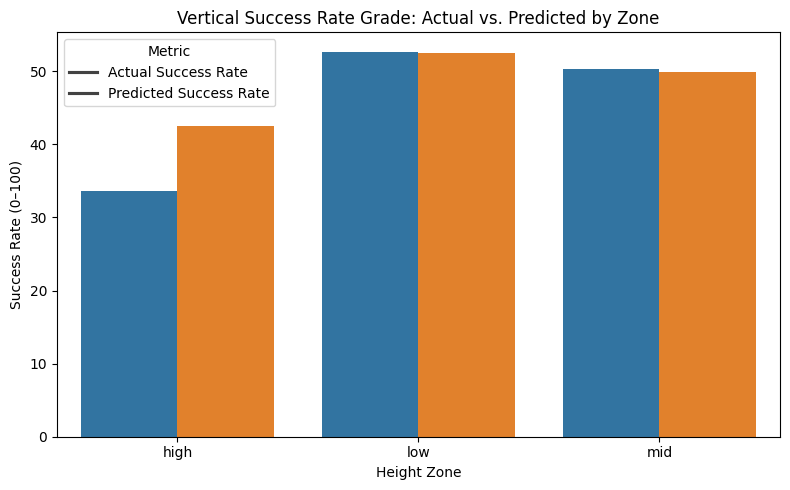

✅ Pipeline saved to C:\docker_projects\nfl_big_data_bowl_2025\data\models\saved_models\gbm_pipeline.joblib
✅ Successfully loaded pipeline from data/models/saved_models/gbm_pipeline.joblib.


In [2]:
# %%writefile src/models/gbm_classifier.py
# ─────────────────────────────────────────────────────────────────────────
# src/models/gbm_classifier.py (updated)
# ─────────────────────────────────────────────────────────────────────────

from __future__ import annotations
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
import optuna
from xgboost.core import XGBoostError
from src.utils.gbm_utils import save_pipeline, load_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    log_loss,
    average_precision_score,
    confusion_matrix,
    classification_report,
)

# ─── Detect GPU support using modern API ───────────────────────────────────────
try:
    # Attempt to instantiate with GPU; if it fails, fall back to CPU
    XGBClassifier(tree_method="hist", device="cuda")
    GPU_SUPPORT = True
except XGBoostError:
    GPU_SUPPORT = False


def _split_xy(df: pd.DataFrame, target_col: str):
    """
    Split a DataFrame into (X, y) pairs based on target_col.
    """
    X = df.drop(columns=[target_col])
    y = df[target_col]
    return X, y


def tune_gbm(X, y, n_trials: int = 50):
    """
    Run an Optuna study to maximize CV ROC AUC of an XGBClassifier.
    Uses device='cuda' if available, else CPU.
    """
    def objective(trial):
        # 1) Sample hyperparameters for this trial
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "random_state": 0,
            "n_jobs": -1,
            "use_label_encoder": False,
            "eval_metric": "logloss",
            "tree_method": "hist",
        }
        model = XGBClassifier(**params)

        # 2) Evaluate via 3-fold CV on ROC AUC
        scores = cross_val_score(
            model, X, y,
            scoring="roc_auc",
            cv=3, n_jobs=-1
        )
        # 3) Return mean AUC to maximize
        return scores.mean()

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)
    return study.best_trial.params


def fit_gbm(X_tr, y_tr, X_te, y_te, **gbm_kw):
    """
    Train an XGBClassifier with optional hyperparameters and early stopping.
    Returns (fitted_model, test_auc).

    Key changes for XGBoost ≥2.1.0:
      - 'early_stopping_rounds' must be passed to the constructor, not to fit().
      - .fit() only accepts 'eval_set' (for validation) but not 'callbacks'.
    """
    # A) Default constructor args → overridden by gbm_kw
    constructor_defaults = dict(
        n_estimators=600,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.7,
        colsample_bytree=0.6,
        random_state=0,
        n_jobs=-1,
        tree_method="hist",
        use_label_encoder=False,
        eval_metric="logloss",
    )
    constructor_defaults.update(gbm_kw)

    # B) Instantiate the XGBClassifier, including early_stopping_rounds if provided
    #    (XGBClassifier will internally handle early stopping when fit() is called
    #     with eval_set=[(X_te, y_te)].)
    model = XGBClassifier(**constructor_defaults)

    # C) Fit the model:
    if "early_stopping_rounds" in gbm_kw:
        model.fit(
            X_tr,
            y_tr,
            eval_set=[(X_te, y_te)],
            verbose=False
        )
    else:
        model.fit(X_tr, y_tr, verbose=False)

    # D) Evaluate on test set: compute ROC AUC
    pred_probs = model.predict_proba(X_te)[:, 1]
    test_auc = roc_auc_score(y_te, pred_probs)

    return model, test_auc


# ───────────────────────────────────────────────────────────────────────
# 6. Smoke test (only run when module executed directly)
# ───────────────────────────────────────────────────────────────────────
if __name__ == "__main__":
    import json
    from pathlib import Path
    from src.load_data.load_data import download_dataset, load_base_data
    from src.feature_engineering.column_schema import ColumnSchema
    from src.feature_engineering.preprocess import (
        fit_preprocessor,
        transform_preprocessor,
        inverse_transform_preprocessor,
        _check_binary_target
    )
    from src.feature_engineering.feature_engineering import load_fe_dataset
    from src.models.gbm_classifier_visualizations import plot_vsrg_by_zone

    # ─── 1) Load raw DataFrames via load_base_data() ─────────────────────────────
    plays, players, pp, games = load_base_data()
    # (Assumes data is already local; if not, call download_dataset() first.)

    # ─── 2) Instantiate ColumnSchema & grab column lists ─────────────────────────
    schema = ColumnSchema()
    INFO_NON_ML = schema.info_non_ml()
    NOMINAL     = schema.nominal_cols()
    ORDINAL     = schema.ordinal_cols()
    NUMERICAL   = schema.numerical_cols()
    TARGET      = schema.target_col()[0]  # e.g. 'contested_success'

    # Print schema lists for verification
    print("INFO_NON_ML:", INFO_NON_ML)
    print("NOMINAL   :", NOMINAL)
    print("ORDINAL   :", ORDINAL)
    print("NUMERICAL :", NUMERICAL)
    print("TARGET    :", TARGET)
    print("[smoke] Column schema validation passed ✅\n")
    print(json.dumps(schema.as_dict(), indent=2))

    # ─── 3) Load feature-engineered dataset from disk ─────────────────────────────
    data_path = "data/ml_dataset/ml_features.parquet"
    print(f"\n▶ Loading full ML DataFrame from {data_path} …")
    ml_df = load_fe_dataset(data_path, file_format="parquet")

    # ─── 4) Filter to only contested plays ───────────────────────────────────────
    ml_df = ml_df[ ml_df["is_contested"] == 1 ]
    print(f"   ML DataFrame shape (is_contested == 1): {ml_df.shape}")

    # ─── 5) Confirm binary target and subset columns ─────────────────────────────
    _check_binary_target(ml_df, TARGET, debug=True)

    # Now select only the features + target
    ml_df = ml_df[ NUMERICAL + NOMINAL + ORDINAL + [TARGET] ]
    print(f"   Subset to features+target → shape: {ml_df.shape}")

    # ─── 6) Train/test split ─────────────────────────────────────────────────────
    train_df, test_df = train_test_split(ml_df, test_size=0.2, random_state=42)
    print(f"   Train shape: {train_df.shape}, Test shape: {test_df.shape}")

    # ─── 7) Fit preprocessing on train set (debug=True to see logs) ────────────────
    X_train_np, y_train, tf = fit_preprocessor(train_df, model_type="linear", debug=True)

    # ─── 8) Transform test set ───────────────────────────────────────────────────
    X_test_np, y_test = transform_preprocessor(test_df, tf)
    print("Processed shapes:", X_train_np.shape, X_test_np.shape)

    # ─── 9) Quick check of inverse_transform_preprocessor ─────────────────────────
    print("\n==========Example of inverse transform:==========")
    df_back = inverse_transform_preprocessor(X_train_np, tf)
    print("\n✅ Inverse‐transformed head (should mirror your original X_train):")
    print(df_back.head())
    print(f"Shape: {df_back.shape} → original X_train shape before transform: {X_train_np.shape}\n")

    # ─── 10) Hyperparameter tuning (Optuna) ───────────────────────────────────────
    print("▶ Running hyperparameter tuning with Optuna …")
    # Because our fit_gbm is for classification, we search for hyperparameters that maximize AUC
    def objective(trial):
        # Sample classification hyperparameters
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "random_state": 0,
            "n_jobs": -1,
            "use_label_encoder": False,
            "eval_metric": "logloss",
            "tree_method": "hist",
        }
        # Early stopping is passed separately
        # 3-fold CV on ROC AUC (so we maximize)
        clf = XGBClassifier(**params)
        scores = cross_val_score(
            clf, X_train_np, y_train,
            scoring="roc_auc",
            cv=3, n_jobs=-1
        )
        return scores.mean()  # returning the mean AUC to maximize

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=50)
    best_params = study.best_trial.params
    print("Tuned params:", best_params)

    # ─── 11) Train & evaluate final XGBoost classifier ─────────────────────────────
    print("▶ Training final XGBoost classifier …")
    # Add early stopping (e.g., 10 rounds)
    best_params["early_stopping_rounds"] = 10
    clf_model, test_auc = fit_gbm(X_train_np, y_train, X_test_np, y_test, **best_params)
    print(f"Tuned XGBoost Test AUC: {test_auc:.4f}")

    # ─── 11.b) ─── UPDATED METRICS ──────────────────────────────────────────────────
    # Compute predicted class labels and probabilities on the test set
    pred_probs_test = clf_model.predict_proba(X_test_np)[:, 1]
    pred_labels_test = clf_model.predict(X_test_np)

    # 1) Accuracy
    test_acc = accuracy_score(y_test, pred_labels_test)
    # 2) Precision (positive class)
    test_prec = precision_score(y_test, pred_labels_test, zero_division=0)
    # 3) Recall (positive class)
    test_rec = recall_score(y_test, pred_labels_test, zero_division=0)
    # 4) F1‐score (positive class)
    test_f1 = f1_score(y_test, pred_labels_test, zero_division=0)
    # 5) Log‐loss
    test_logloss = log_loss(y_test, pred_probs_test)
    # 6) PR‐AUC (average precision)
    test_pr_auc = average_precision_score(y_test, pred_probs_test)
    # 7) Confusion matrix
    test_cm = confusion_matrix(y_test, pred_labels_test)
    # 8) Classification report
    test_report = classification_report(y_test, pred_labels_test, zero_division=0)

    # Print everything neatly
    print("\n─── Classification Metrics (Test Set) ───")
    print(f"Accuracy      : {test_acc:.4f}")
    print(f"Precision     : {test_prec:.4f}")
    print(f"Recall        : {test_rec:.4f}")
    print(f"F1‐score      : {test_f1:.4f}")
    print(f"Log‐loss      : {test_logloss:.4f}")
    print(f"PR‐AUC        : {test_pr_auc:.4f}")
    print("Confusion Matrix:")
    print(test_cm)
    print("\nClassification Report:")
    print(test_report)
    # ────────────────────────────────────────────────────────────────────────────────

    # ─── 12) Compute predicted probabilities on entire dataset for VSRG ─────────
    # Reconstruct the full contested set's features & target
    X_all_np, y_all, tf_full = fit_preprocessor(ml_df, model_type="linear", debug=False)
    # Now get predicted probabilities:
    pred_probs_all = clf_model.predict_proba(X_all_np)[:, 1]
    ml_df_with_preds = ml_df.copy()
    ml_df_with_preds["pred_prob"] = pred_probs_all

    # ─── 13) Plot VSRG by vertical zone ──────────────────────────────────────────
    print("▶ Plotting VSRG by height_zone …")
    plot_vsrg_by_zone(
        ml_df_with_preds,
        zone_col="height_zone",
        target_col=TARGET,
        pred_prob_col="pred_prob",
        to_grade=True
    )

    # ─── 14) Save pipeline (model + preprocessor) ─────────────────────────────────
    save_path = "data/models/saved_models/gbm_pipeline.joblib"
    save_pipeline(clf_model, tf, path=save_path)

    # ─── 15) Load it back to verify it works ─────────────────────────────────────
    loaded_model, loaded_preprocessor = load_pipeline(save_path)
    print(f"✅ Successfully loaded pipeline from {save_path}.")
